# Quantum walks via efficient block encoding circuits

This notebook was developed as part of “**Implementation Challenge**” by Classiq and Quantum Coalition. 
___

### **Introduction**

Block encoding is a well known technique in quantum computing used to embed non-unitary matrices on a quantum computer that only allows for unitary evolution. 

***Definition:***  
    Let $ a, n, m \in \mathbb{N} $ such that $ m = a + n $. An $ m $ -qubit unitary $ U $  is said to be an $(\alpha, a)$ -block-encoding of an $ n $ -qubit operator $ A $  if  

$$
\tilde{A} = \left( \langle 0 |^{\otimes a} \otimes I_n \right) U \left( |0 \rangle^{\otimes a} \otimes I_n \right)
\tag{1}
$$  

where,  $A = \alpha \tilde{A}$ . The parameters $(\alpha, a)$  represent the *subnormalization factor* (which adjusts for encoding matrices of any norm), and the *number of ancilla qubits* used in the block-encoding scheme respectively. 

Efficiently block encoding arbitrary matrices is a very difficult problem and this task is not trivial even for well structured and sparse matrices. The [paper by Camps et al. 2023](https://arxiv.org/abs/2203.10236), provides for: 

- Efficient quantum circuits for block encoding certain kinds of matrices. This is useful in many applications, especially ones involving problems of linear algebra. Moreover, given an efficient block encoding of a matrix $\tilde{A}$, its possible to efficiently construct a block encoding of certain polynomials of $\tilde{A}$ through quantum singular value transformations (QSVT). 

- The block encoding techniques for $ \tilde{A}= \frac{A}{\alpha}$ is problematic in applications like quantum walks, where $A$ is a symmetric stochastic matrix representing a random walk. The scaling factor($\alpha$) in the block-encoding process introduces a loss of quantum efficiency. To address this, an alternative method that directly block-encodes a symmetric stochastic $A$ is discussed. This enables an efficient block encoding for a Chebyshev polynomial $T_P(A)$ .  

- The above approach provides a new perspective on quantum walks, differing from the conventional Szegedy quantum walk framework. A clear connection between Chebyshev polynomial $T_P(A)$ and Szegedy quantum walk with stochastic matrix $A$ is also established.
___

### **Notebook contents**
- Efficient block encoding of the adjacency matrix of an extended binary tree and its comparison to block encoding using a linear combination of unitaries
- Exact hermitian block encoding of the adjacency matrix of a directed cyclic graph and its connection to Szegedy quantum walk
- **Application:** Detecting a marked vertex on a graph using quantum walks via block encoding circuits

___


In [1]:
# import all necessary modules
import builtins
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np

import classiq
from classiq import *
from classiq.execution import *
from classiq.synthesis import set_execution_preferences

## Section 1: Block encoding the adjacency matrix of an extended binary tree graph
___
**Block encoding theorem:** 
    Let $ c(j, \ell) $ be a function that gives the row index of the $\ell$ th (among a list of $ s $) non-zero matrix elements in the $j$ th column of an $s$-sparse matrix $ A \in \mathbb{C}^{N \times N} $ with $ N = 2^n $, where $ s = 2^m $. If there exists a unitaries $ O_c $ and $ O_A $ such that  

$$
O_c |{\ell}\rangle \ket{j} = |{\ell}\rangle |{c(j, \ell)}\rangle,
\tag{2}
$$  

$$
O_A |{0}\rangle |{\ell}\rangle |{j}\rangle = \left( A_{c(j,\ell),j} |{0}\rangle + \sqrt{1 - |A_{c(j,\ell),j}|^2} |{1}\rangle \right) |{\ell}\rangle |{j}\rangle,
\tag{3}
$$  

then, 

$$
U_A = (I_2 \otimes D_s \otimes I_N)(I_2 \otimes O_c)O_A(I_2 \otimes D_s \otimes I_N),
\tag{4}
$$
block encodes $ A/s $. Here $ D_s $ is called a diffusion operator and is defined as  $D_s \equiv H \otimes H \otimes \cdots \otimes H, $ where there are $ m $ Hadamard gates $ H $.

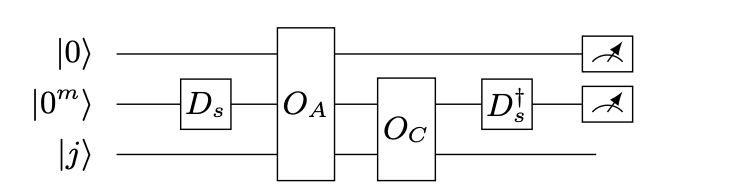


___
An **extended binary tree** is a balanced binary tree with an additional root node. A standard balanced binary tree of depth $ n $ has $ 2^n - 1 $ vertices. By adding an extra root, the total number of vertices becomes $ 2^n $.

##### Construction:
1. **Vertices**: The new root is labeled as $ 0 $, and the original root becomes its child.
2. **Edges**: Each parent node connects to two child nodes except for leaves.
3. **Weights**:
   - A self-loop weight $ \alpha $ is assigned to internal nodes.
   - The root and leaves get a self-loop weight $ \gamma $.
   - Parent-child connections have a weight $ \beta $.

##### Example: Extended binary tree graph for $ n = 3 $

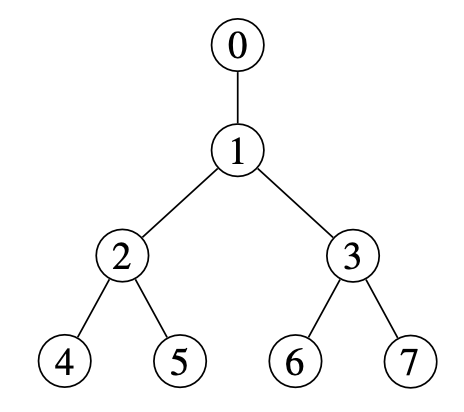

##### Corresponding Adjacency Matrix:

$$
A =
\begin{bmatrix}
\gamma & \beta & 0 & 0 & 0 & 0 & 0 & 0 \\
\beta & \alpha & \beta & \beta & 0 & 0 & 0 & 0 \\
0 & \beta & \alpha & 0 & \beta & \beta & 0 & 0 \\
0 & \beta & 0 & \alpha & 0 & 0 &  \beta & \beta \\
0 & 0 & \beta & 0 & \gamma & 0 & 0 & 0 \\
0 & 0 & \beta & 0 & 0 & \gamma & 0 & 0 \\
0 & 0 & 0 & \beta & 0 & 0 & \gamma & 0 \\
0 & 0 & 0 & \beta & 0 & 0 & 0 & \gamma
\end{bmatrix}
\tag {5}
$$

This adjacency matrix encodes the structure and weights of the extended binary tree.

In [2]:
def extended_binary_tree_matrix(n, alpha=0.5, beta=0.3, gamma=0.7):
    """
    Generate the adjacency matrix for an extended binary tree of size n x n.

    Parameters:
    - n (int): Number of vertices (should be 2^k).
    - alpha (float): Internal nodes' self-loop weight.
    - beta (float): Edge weight between parent and child nodes.
    - gamma (float): Self-loop weight for root and leaves.

    Returns:
    - A (numpy.ndarray): The adjacency matrix.
    """
    if not (n & (n - 1) == 0):
        raise ValueError("n must be a power of 2.")

    A = np.zeros((n, n))

    # Root node self-loop
    A[0, 0] = gamma

    # Root (node 0) connects only to node 1
    A[0, 1] = beta
    A[1, 0] = beta

    # Assign weights for parent-child relationships
    for parent in range(1, n // 2):  # Internal nodes
        left_child = 2 * parent
        right_child = 2 * parent + 1

        if left_child < n:
            A[parent, left_child] = beta
            A[left_child, parent] = beta
        if right_child < n:
            A[parent, right_child] = beta
            A[right_child, parent] = beta

    # Internal nodes self-loops
    for i in range(1, n // 2):
        A[i, i] = alpha

    # Leaf nodes self-loops
    for i in range(n // 2, n):
        A[i, i] = gamma

    return A


# Example
n = 8  # 8 vertices (3 levels + root) , 8 * 8 matrix
A = extended_binary_tree_matrix(n, alpha=0.5, beta=0.3, gamma=0.7)
print(A)

[[0.7 0.3 0.  0.  0.  0.  0.  0. ]
 [0.3 0.5 0.3 0.3 0.  0.  0.  0. ]
 [0.  0.3 0.5 0.  0.3 0.3 0.  0. ]
 [0.  0.3 0.  0.5 0.  0.  0.3 0.3]
 [0.  0.  0.3 0.  0.7 0.  0.  0. ]
 [0.  0.  0.3 0.  0.  0.7 0.  0. ]
 [0.  0.  0.  0.3 0.  0.  0.7 0. ]
 [0.  0.  0.  0.3 0.  0.  0.  0.7]]


Because each column of the matrix $A$  has at most four nonzero elements, we would typically need only two qubits to encode $\ell$ in the function $c(j, \ell)$. 

But here, we use a different mapping for $l$. The $\ell$ th nonzero element in each column is mapped to a specific **type** of nonzero entry. Here, **type** represents type of each node in the graph. To accommodate this mapping, an additional qubit is required to encode $\ell$. The function $c(j, \ell)$ describing the nonzero pattern of the adjacency matrix  $A$ is:

$$
c(j, \ell) =
\begin{cases} 
    2j & \text{if } \ell = 0 \text{ and } j < 2^{n-1} \text{ (left child)}, \\
    2j + 1 & \text{if } \ell = 1 \text{ and } j < 2^{n-1} \text{ (right child)}, \\
    j/2 & \text{if } \ell = 2 \text{ and } j \text{ is even (parent)}, \\
    (j - 1)/2 & \text{if } \ell = 3 \text{ and } j \text{ is odd (parent)}, \\
    j & \text{if } 3 < \ell < 8 \text{ (diagonal)}.
\end{cases}
$$

Here, $j$ and $\ell$ have bit representations $[j_{n-1} \cdots j_1 j_0]$ and $[\ell_2 \ell_1 \ell_0]$, respectively. Since this function involves multiplying and dividing the column index $j$ by 2, the $O_C$ circuit includes controlled subcircuits to handle these operations, along with controlled $L$-shift and $R$-shift circuits for additions and subtractions when $\ell = 1$ or $\ell = 3$.

#### L and R shift circuits:

$L$ and $R$ operators correspond to the addition and subtraction arithmetic operations, i.e., $+1$ and $−1$, respectively. 

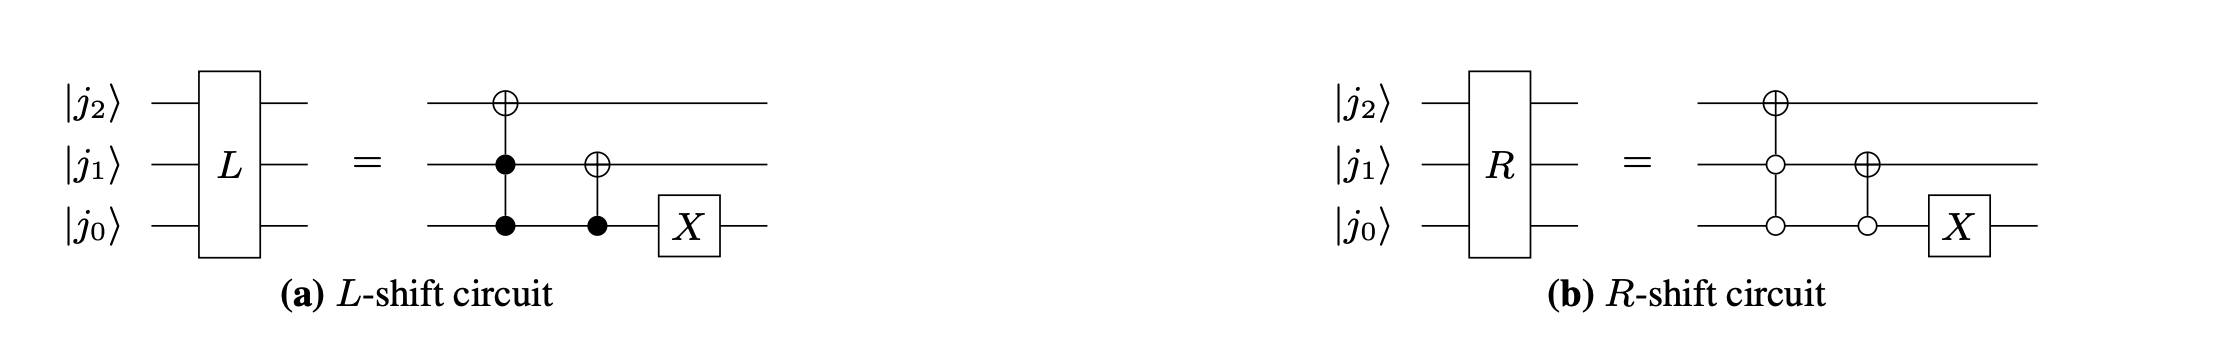



But rather than implementing these circuits at a low-level, we use high-level functionality of classiq for transforming $j$ to $j+1$ (using the assignment `j+=1`) and $j$ to $j-1$ (using the assignment `j-=1`).

#### Circuits for multiplying and dividing a quantum variable by $2$:

Note: Shown is the case for a three qubit register ($n=3$). Generalization is straightforward. The measured register contains the following information: If its $\ket{1}$, (which is for the case when $j \ge 2^{n-1}$ in case of $M_2$ operation), then the result of the operation is simply discarded post measurement.

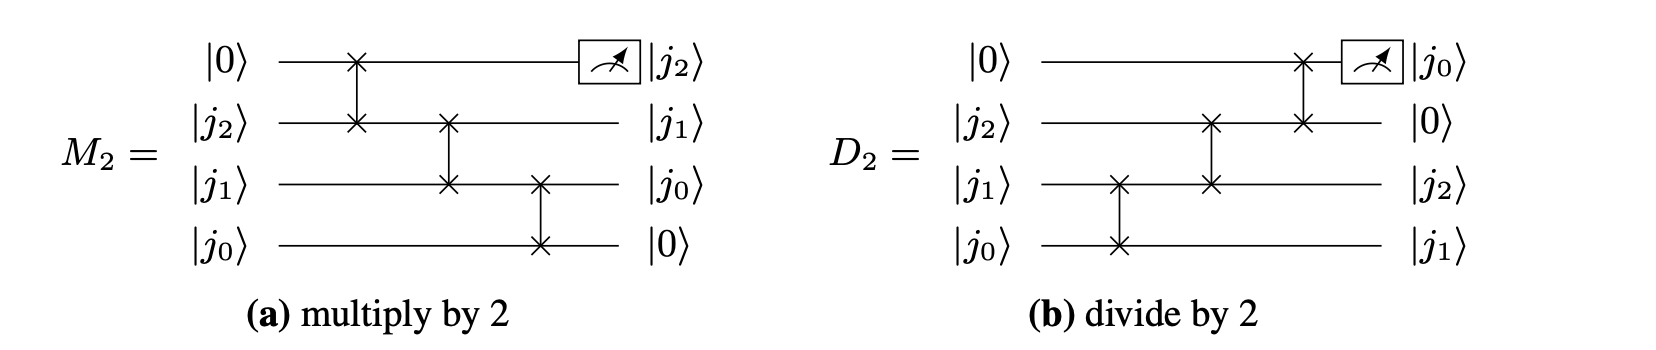


#### $O_A$ and $O_C$ circuits

Using the above quantum circuits, the below quantum circuits provides for the oracle operations $O_A$ and $O_C$ respectively as required by the block encoding theorem. Details can be found in [paper by Camps et al. 2023](https://arxiv.org/abs/2203.10236).

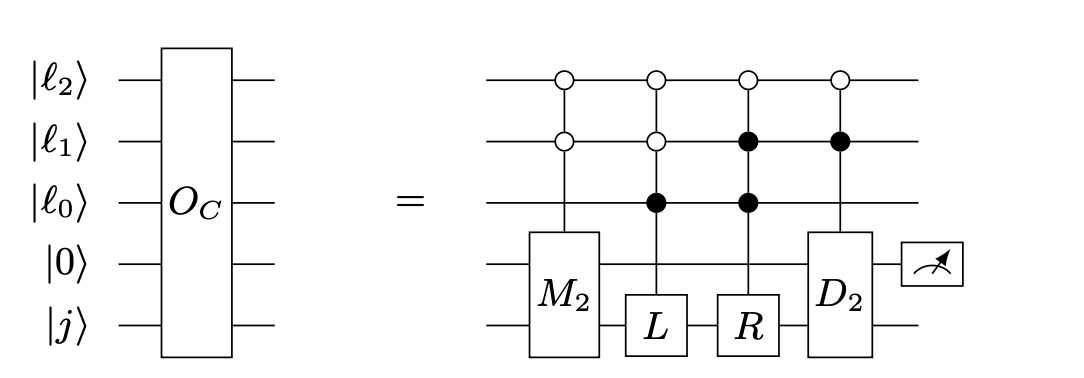 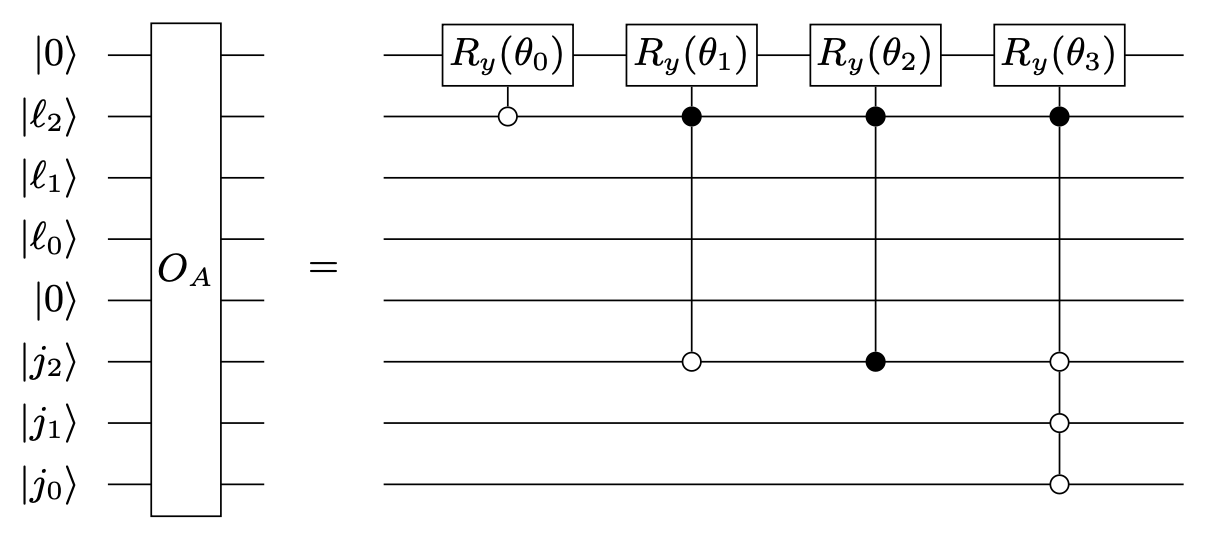




Here, the angles are related are related to the matrix values in equation $5$ as follows:

$$
\theta_0 = 2\arccos(\beta)
$$

$$
\theta_1 = 2\arccos\left(\frac{\alpha}{4}\right)
$$

$$
\theta_2 = 2\arccos\left(\frac{\gamma}{4}\right)
$$

$$
\theta_3 = 2\arccos\left(\frac{\gamma}{4} - \frac{\beta}{2}\right) - \theta_1
$$

With this, the full block encoding circuit for the $8 \times 8$ case looks like, 

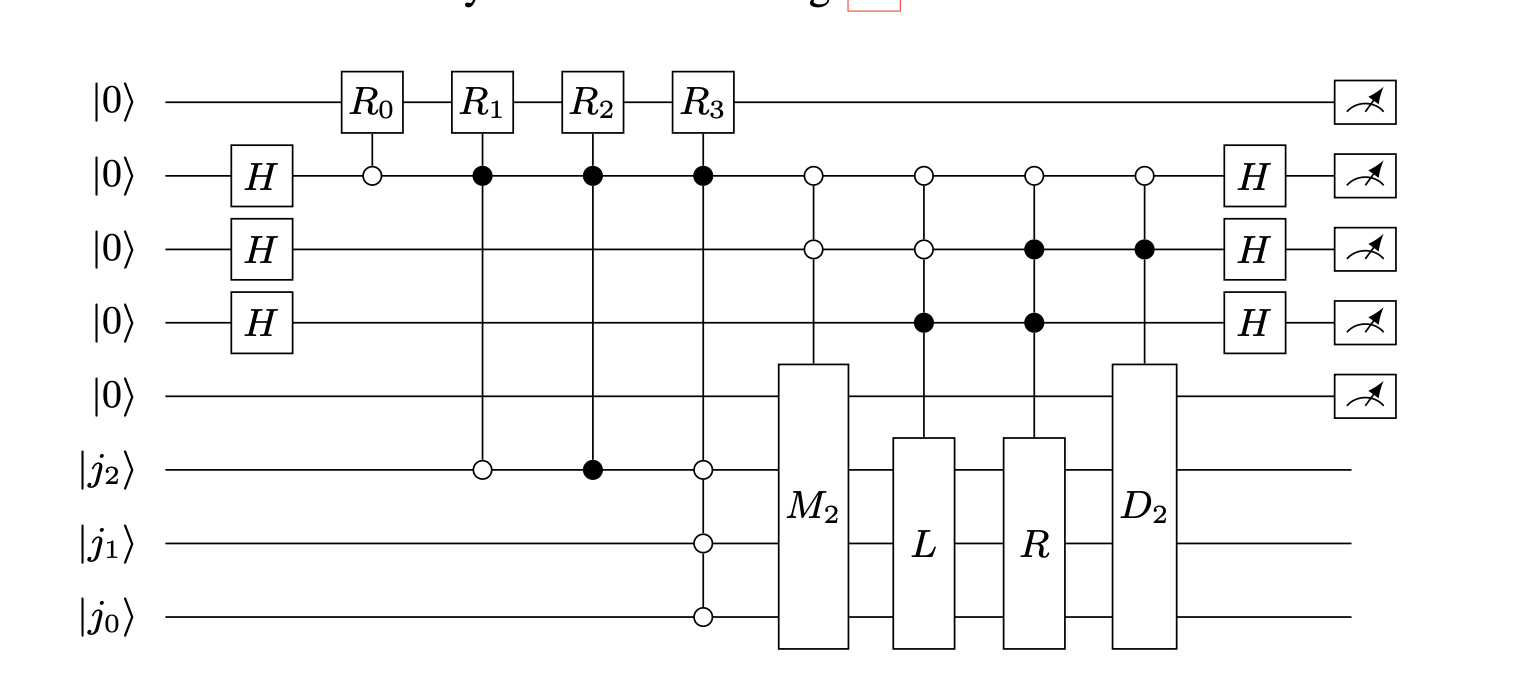 


The below is an implementation of the full block encoding using Classiq. Note that, we obtain the action of $\frac {A}{8}$ on the register $\ket{j}$ when the other registers are projected on the ground state.

In [3]:
# these angles are relevant for block encoding quantum circuit
beta_angle = 0.3
alpha_angle = 0.5
gamma_angle = 0.7

theta_0 = 2 * (np.arccos(beta_angle))
theta_1 = 2 * (np.arccos(alpha_angle / 4))
theta_2 = 2 * (np.arccos(gamma_angle / 4))
theta_3 = 2 * np.arccos((gamma_angle / 4) - (beta_angle / 2)) - theta_1


@qfunc
def L_shift(jarr: QNum):
    jarr += 1


@qfunc
def R_shift(jarr: QNum):
    jarr -= 1


@qfunc
def M2(j: QArray, anc_M: QBit):
    """quantum circuit for numtiplying 2 to the register j.
    Note: inverse of M2 is D2"""
    SWAP(j[j.len - 1], anc_M)
    repeat(j.len - 1, lambda i: SWAP(j[j.len - 1 - i], j[j.len - 2 - i]))


@qfunc
def O_A_extendedBT(l_array: QArray, j: QNum, data: QNum, ancilla: QBit):
    """quantum circuit for O_A circuit for block encoding the adjacency matrix of an extended binary tree"""
    j_array = QArray()

    within_apply(
        lambda: bind(j, j_array),
        lambda: (
            control(l_array[2] == 0, lambda: RY(theta_0, data)),
            control(
                l_array[2] == 1,
                lambda: control(
                    j_array[int(np.log2(n)) - 1] == 0, lambda: RY(theta_1, data)
                ),
            ),
            control(
                l_array[2] == 1,
                lambda: control(
                    j_array[int(np.log2(n)) - 1] == 1, lambda: RY(theta_2, data)
                ),
            ),
        ),
    )

    control(l_array[2] == 1, lambda: control(j == 0, lambda: RY(theta_3, data)))


@qfunc
def O_C_extendedBT(l: QNum, j: QNum, ancilla: QBit):
    """quantum circuit for O_C circuit for block encoding the adjacency matrix of an extended binary tree"""
    l_array = QArray()
    within_apply(
        lambda: bind(l, l_array),
        lambda: control(
            l_array[2] == 0, lambda: control(l_array[1] == 0, lambda: M2(j, ancilla))
        ),
    )

    control(l == 1, lambda: L_shift(j))
    control(l == 3, lambda: R_shift(j))

    within_apply(
        lambda: bind(l, l_array),
        lambda: control(
            l_array[2] == 0,
            lambda: control(l_array[1] == 1, lambda: invert(lambda: M2(j, ancilla))),
        ),
    )


@qfunc
def BE_extendedBT(l: QNum, j: QNum, data: QNum, ancilla: QBit):
    O_A_extendedBT(l, j, data, ancilla)
    O_C_extendedBT(l, j, ancilla)


def get_projected_state_vector(
    execution_result,
    measured_var: str,
    projections: dict,
) -> np.ndarray:
    """
    This function returns a reduced statevector from execution results.
    measured var: the name of the reduced variable
    projections: on which values of the other variables to project, e.g., {"ind": 1}
    Note: For this function to work properly all variables, except auxiliary qubits, must be declared as
    output of the model.
    """
    projected_size = len(execution_result.output_qubits_map[measured_var])
    proj_statevector = np.zeros(2**projected_size).astype(complex)
    for sample in execution_result.parsed_state_vector:
        if all(
            int(sample.state[key]) == projections[key] for key in projections.keys()
        ):
            value = int(sample.state[measured_var])
            proj_statevector[value] += sample.amplitude
    global_phase = np.angle(proj_statevector[0])
    return np.real(proj_statevector / np.exp(1j * global_phase))

In [4]:
@qfunc
def main(j: Output[QNum], l: Output[QNum], data: Output[QNum], anc_M: Output[QBit]):
    allocate(1, anc_M)
    allocate(1, data)
    allocate(3, l)
    allocate(int(np.log2(n)), j)

    apply_to_all(
        H, j
    )  # example state on which the block encoding is applied, this can be any log2(n) qubit state
    within_apply(lambda: apply_to_all(H, l), lambda: BE_extendedBT(l, j, data, anc_M))


qmod = create_model(
    main,
    out_file="extended_binary_tree_matrix_block_encoding",
)
backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
qmod = set_execution_preferences(
    qmod,
    execution_preferences=ExecutionPreferences(
        num_shots=1000, backend_preferences=backend_preferences
    ),
)
qprog = synthesize(qmod)
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print("The circuit width is:", circuit_width)
print("The circuit depth is:", circuit_depth)
show(qprog)

job = execute(qprog)
results = job.result()[0].value

# Post-processing to get the reduced state vector of the register j when rest of the registers are in zero state
reduced_state = get_projected_state_vector(
    results, "j", {"l": 0, "data": 0, "anc_M": 0}
)
reduced_state = reduced_state
print("The reduced state vector for j is:")
print(np.real(reduced_state))

# theoretical reduced state vector
theoretical_reduced_state = (
    np.matmul(A, [1 / np.sqrt(n) for i in range(n)]) / 8
)  # 8 is the alpha factor of the block encoding
print("Theoretical reduced state vector for j is:")
print(theoretical_reduced_state)

assert np.allclose(
    reduced_state, theoretical_reduced_state, atol=1e-4
), "Implementation is incorrect"

The circuit width is: 9
The circuit depth is: 657
Quantum program link: https://platform.classiq.io/circuit/2w524bnGfQimhYNRyOzZhGoWCsj?login=True&version=0.75.0
The reduced state vector for j is:
[0.04419417 0.06187184 0.06187184 0.06187184 0.04419417 0.04419417
 0.04419417 0.04419417]
Theoretical reduced state vector for j is:
[0.04419417 0.06187184 0.06187184 0.06187184 0.04419417 0.04419417
 0.04419417 0.04419417]


##### **Note:** The above code is general, that is it  works for any $2^n \times 2^n$ extended binary tree matrix. The alpha factor is always $8$. Also, the number of ancilla qubits required for block encoding is $5$ irrespective of the matrix size. It can be shown that the technique is efficient as the overall gate complexity is of the order of $poly(n)$ (as justified through the plots in $1.1$).

#### $1.1 $ Comparison with LCU based block encoding

We now compare this block encoding technique with the generic block encoding of a linear combination of unitaries (LCU) and show that its more efficient than the LCU based block encoding. For more details on the LCU technique refer [this documentation](https://docs.classiq.io/latest/classiq_101/quantum_primitives_with_classiq/linear_combination_of_unitaries/?h=linear+com). Below, we just use the codes from the linked documentation.


In [5]:
U_minus2 = [
    [-1, 0],
    [0, -1],
]  # this unitary has been added as the adjacecny matrix can have negative values for the coefficents in the LCU


def get_normalized_lcu_coef(lcu_coef):

    normalization_factor = builtins.sum(np.abs(lcu_coef))
    prepare_prob = [c / normalization_factor for c in lcu_coef]
    coef_size = int(np.ceil(np.log2(len(prepare_prob))))
    prepare_prob += [0] * (2**coef_size - len(prepare_prob))

    return normalization_factor, coef_size, prepare_prob


@qfunc
def apply_pauli_term(pauli_string: PauliTerm, x: QArray[QBit], pcr: CReal):
    repeat(
        count=x.len,
        iteration=lambda index: (
            switch(
                pauli_string.pauli[index],
                [
                    lambda: IDENTITY(x[pauli_string.pauli.len - index - 1]),
                    lambda: X(x[pauli_string.pauli.len - index - 1]),
                    lambda: Y(x[pauli_string.pauli.len - index - 1]),
                    lambda: Z(x[pauli_string.pauli.len - index - 1]),
                ],
            )
        ),
    )

    if_(condition=pcr < 0, then=lambda: unitary(U_minus2, x[0]))


@qfunc
def prepare_ca(
    pauli_terms_list: CArray[PauliTerm],
    system_qubits: QArray[QBit],
    ancillary_qubits: QNum,
    real_list: CArray[CReal],
):
    repeat(
        count=pauli_terms_list.len,
        iteration=lambda i: control(
            ancillary_qubits == i,
            lambda: (
                pcr := real_list[i],
                repeat(
                    count=1,
                    iteration=lambda _: apply_pauli_term(
                        pauli_terms_list[i], system_qubits, pcr
                    ),
                ),
            ),
        ),
    )


@qfunc
def prepare_c(ancillary_qubits: QArray[QBit]):
    inplace_prepare_state(list(prepare_probs_ham), 0, ancillary_qubits)


@qfunc
def main(
    ancillary_qubits: Output[QNum],
    system_qubits: Output[QNum],
):

    allocate(num_ancila_qubits, ancillary_qubits)
    allocate(num_system_qubits, system_qubits)

    inplace_prepare_amplitudes(amps, 0, system_qubits)

    within_apply(
        within=lambda: prepare_c(ancillary_qubits),
        apply=lambda: prepare_ca(
            A_classiq_pauli_list, system_qubits, ancillary_qubits, real_list
        ),
    )

(Note: Below code would take around $7$ minutes to execute for all sizes upto $16\times 16$, as the `matrix_to_hamiltonian` method is not time efficient for providing Pauli decomposition of large matrices.)

In [ ]:
N_size = [2, 4, 8, 16]
Depths_EBLCU = []
Widths_EBLCU = []
for N in N_size:
    A = extended_binary_tree_matrix(N, alpha=0.5, beta=0.3, gamma=0.7)

    A_classiq_pauli_list = matrix_to_hamiltonian(A)
    coefficients = [term.coefficient for term in A_classiq_pauli_list]
    real_list = []
    for num in coefficients:
        real_list.append(num.real if num.real else 0)
    normalization_ham, lcu_size_ham, prepare_probs_ham = get_normalized_lcu_coef(
        np.abs(coefficients).tolist()
    )
    num_system_qubits = int(np.log2(A.shape[0]))
    num_ancila_qubits = int(np.ceil(np.log2(len(A_classiq_pauli_list))))

    amps = [
        1 / np.sqrt(N) for k in range(N)
    ]  # example state on which the block encoding is applied, this can be any log2(n) qubit state

    qmod = create_model(main)

    preferences = Preferences(timeout_seconds=1000)
    qmod = set_preferences(qmod, preferences)
    qprog = synthesize(qmod)
    circuit_width = QuantumProgram.from_qprog(qprog).data.width
    circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
    Depths_EBLCU.append(circuit_depth)
    Widths_EBLCU.append(circuit_width)
    print("N=", N, "Done")

N= 2 Done
N= 4 Done
N= 8 Done
N= 16 Done


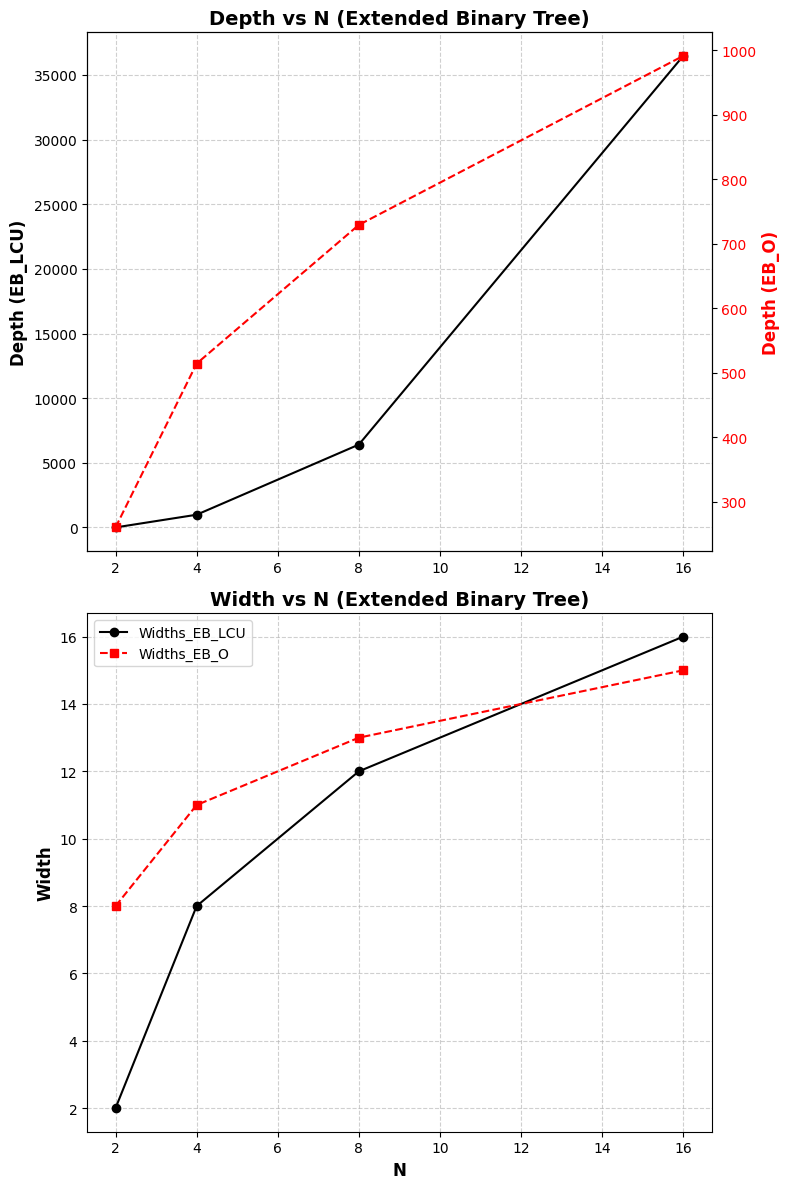

In [7]:
Depths_EB_O = []
Widths_EB_O = []


@qfunc
def main(j: Output[QNum], l: Output[QNum], data: Output[QNum], anc_M: Output[QBit]):
    allocate(1, anc_M)
    allocate(1, data)
    allocate(3, l)
    allocate(int(np.log2(n)), j)
    apply_to_all(H, j)

    within_apply(lambda: apply_to_all(H, l), lambda: BE_extendedBT(l, j, data, anc_M))


for n in N_size:
    A = extended_binary_tree_matrix(N, alpha=0.5, beta=0.3, gamma=0.7)

    qmod = create_model(main)
    qprog = synthesize(qmod)
    circuit_width = QuantumProgram.from_qprog(qprog).data.width
    circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
    Depths_EB_O.append(circuit_depth)
    Widths_EB_O.append(circuit_width)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# Plot Depths with twin y-axis
ax1 = axs[0]
ax1.plot(
    N_size,
    Depths_EBLCU,
    marker="o",
    linestyle="-",
    color="black",
    label="Depths_EB_LCU",
)
ax1.set_ylabel("Depth (EB_LCU)", color="black", fontsize=12, fontweight="bold")
ax1.tick_params(axis="y", labelcolor="black")

ax2 = ax1.twinx()
ax2.plot(
    N_size, Depths_EB_O, marker="s", linestyle="--", color="red", label="Depths_EB_O"
)
ax2.set_ylabel("Depth (EB_O)", color="red", fontsize=12, fontweight="bold")
ax2.tick_params(axis="y", labelcolor="red")

ax1.set_title("Depth vs N (Extended Binary Tree)", fontsize=14, fontweight="bold")
ax1.grid(True, linestyle="--", alpha=0.6)

# Plot Widths
axs[1].plot(
    N_size,
    Widths_EBLCU,
    marker="o",
    linestyle="-",
    color="black",
    label="Widths_EB_LCU",
)
axs[1].plot(
    N_size, Widths_EB_O, marker="s", linestyle="--", color="red", label="Widths_EB_O"
)
axs[1].set_ylabel("Width", fontsize=12, fontweight="bold")
axs[1].set_xlabel("N", fontsize=12, fontweight="bold")
axs[1].set_title("Width vs N (Extended Binary Tree)", fontsize=14, fontweight="bold")
axs[1].legend()
axs[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

##### Thus, compared to the generic LCU based block encoding approach, the resultant depths (and even widths) is significantly less.
___

## Section 2: Exact Hermitian block encoding of the adjacency matrix of a directed cyclic graph and its connection to Szegedy quantum walk

A directed cyclic graph has two edges emanating from every vertex and the graph is cyclic. Shown below is an example for $N=8$

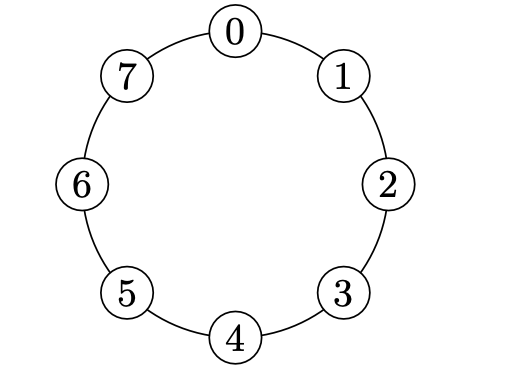


##### Corresponding Adjacency Matrix:

The weights associated with the two edges emanating from every vertex are $\beta$ and $\gamma$ respectively. A weight of $\alpha$ is assigned to each vertex. This weight can be viewed as the weight associated with a self-loop edge from a vertex to itself. Thus, the adjacency matrix is,


$$
A =
\begin{bmatrix}
\alpha & \gamma & 0 & 0 & 0 & 0 & 0 & \beta \\
\beta  & \alpha & \gamma & 0 & 0 & 0 & 0 & 0 \\
0 & \beta  & \alpha & \gamma & 0 & 0 & 0 & 0 \\
0 & 0 & \beta  & \alpha & \gamma & 0 & 0 & 0 \\
0 & 0 & 0 & \beta  & \alpha & \gamma & 0 & 0 \\
0 & 0 & 0 & 0 & \beta  & \alpha & \gamma & 0 \\
0 & 0 & 0 & 0 & 0 & \beta  & \alpha & \gamma \\
\gamma & 0 & 0 & 0 & 0 & 0 & \beta  & \alpha
\end{bmatrix}
\tag{6}
$$

Since, this is supposed to be a **stochastic matrix**, we impose the condition $\alpha + \beta + \gamma = 0$ and also $\alpha, \beta, \gamma \ge 0 $. 



**Theorem:** If $P$ is a symmetric stochastic Markov chain matrix, and if there exists a unitary operator $O_P$ that can be used to carry out the mapping
$
O_P |{0^n}\rangle |{j}\rangle = \sum_k \sqrt{P_{jk}} |{k}\rangle |{j}\rangle,
$ then the unitary operator
$$
U_P = O_P^\dagger \text{SWAP} \, O_P
$$
is a Hermitian block encoding of $P$, where the swap operator SWAP is defined as
$
\text{SWAP} |{i}\rangle |{j}\rangle = |{j}\rangle |{i}\rangle.
$

For proof refer the [paper by Camps et al. 2023](https://arxiv.org/abs/2203.10236). Here we focus on the implementation of the above unitary. For making $A$ symmetric, we impose an additional condition that $\gamma = \beta$.


In [8]:
def banded_circulant_stochastic_matrix(N, alpha, beta, gamma):
    """
    Generate a banded circulant stochastic matrix A of size N x N
    with parameters alpha, beta, gamma such that alpha + beta + gamma = 1.
    """
    # Ensure the parameters sum to 1
    if not np.isclose(alpha + beta + gamma, 1.0):
        raise ValueError("alpha, beta, and gamma must sum to 1.")

    # Initialize an N x N zero matrix
    A = np.zeros((N, N))

    # Fill the diagonal with alpha
    np.fill_diagonal(A, alpha)

    # Fill the first upper diagonal with gamma
    np.fill_diagonal(A[0 : N - 1, 1:N], gamma)

    # Fill the first lower diagonal with beta
    np.fill_diagonal(A[1:N, 0 : N - 1], beta)

    # Set the wrap-around elements for banded circulant nature
    A[0, N - 1] = beta  # Top-right corner (wrap-around lower diagonal)
    A[N - 1, 0] = gamma  # Bottom-left corner (wrap-around upper diagonal)

    return A


# Example
N = 8
alpha = 0.4
beta = 0.3
gamma = 0.3

A = banded_circulant_stochastic_matrix(N, alpha, beta, gamma)
print("Banded Circulant Stochastic Matrix:\n", A)

# Verify row sums
print("Row sums:", np.sum(A, axis=1))  # Should all be 1 since A is a stochastic matrix

n = int(np.log2(N))  # number of qubits for action of A

Banded Circulant Stochastic Matrix:
 [[0.4 0.3 0.  0.  0.  0.  0.  0.3]
 [0.3 0.4 0.3 0.  0.  0.  0.  0. ]
 [0.  0.3 0.4 0.3 0.  0.  0.  0. ]
 [0.  0.  0.3 0.4 0.3 0.  0.  0. ]
 [0.  0.  0.  0.3 0.4 0.3 0.  0. ]
 [0.  0.  0.  0.  0.3 0.4 0.3 0. ]
 [0.  0.  0.  0.  0.  0.3 0.4 0.3]
 [0.3 0.  0.  0.  0.  0.  0.3 0.4]]
Row sums: [1. 1. 1. 1. 1. 1. 1. 1.]


The full Hermitian block encoding circuit for the $8 \times 8$ case looks like, 

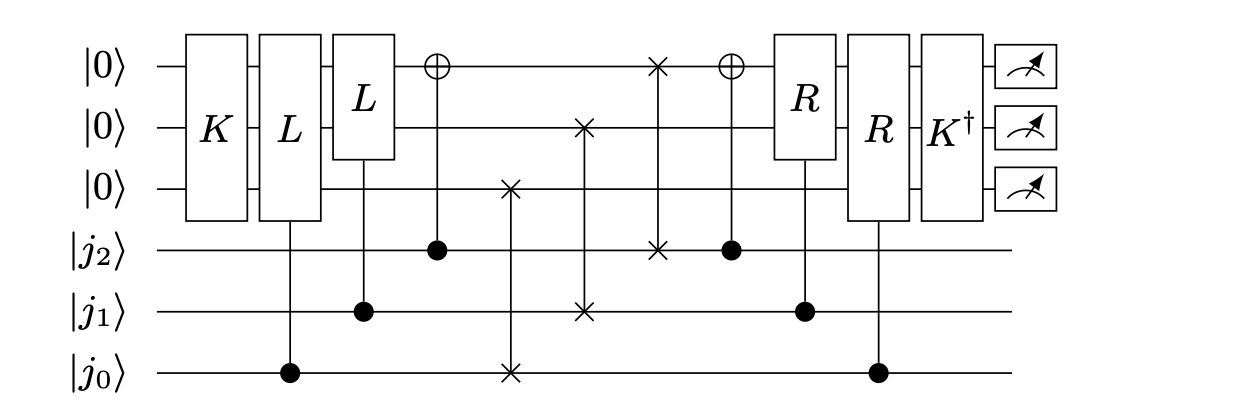 


Here $L$ and $R$ are operators for $+1$ and $-1$ defined earlier. The unitary $K$ is such that  $K |{0^n}\rangle = (\sqrt{\alpha} \quad \sqrt{\beta} \quad 0 \quad \cdots \quad 0 \quad \sqrt{\gamma})^T$ and has the following circuit composition:

<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAABGwAAAGWCAYAAAAtwRWEAAAMTmlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnltSIQQIhCIl9CaISAkgJYQWekcQlZAECCXGhKBiRxdXcK2ICJYVXQVR7ICIDXXVlUWxu5bFgsrKurguduVNCKDLvvK9+b65899/zvxzzrkz994BgN7Fl0rzUE0A8iUFsriQANaklFQWqQdgQAPoARqw5wvkUk5MTASAZbj9e3l9AyDK9qqjUuuf/f+1aAlFcgEASAzEGUK5IB/iQwDgrQKprAAAohTyFjMLpEpcDrGODDoIca0SZ6lwqxJnqPDlQZuEOC7EjwEgq/P5siwANPogzyoUZEEdOowWOEuEYgnE/hD75udPF0K8EGJbaAPnpCv12Rlf6WT9TTNjRJPPzxrBqlgGCzlQLJfm8Wf/n+n43yU/TzE8hw2s6tmy0DhlzDBvj3OnhyuxOsRvJRlR0RBrA4DiYuGgvRIzsxWhiSp71FYg58KcASbEE+V58bwhPk7IDwyH2AjiTEleVMSQTXGmOFhpA/OHVooLeAkQ60NcK5IHxQ/ZnJRNjxue90amjMsZ4p/xZYM+KPU/K3ITOSp9TDtbxBvSx5yKshOSIaZCHFgoToqCWAPiKHlufPiQTVpRNjdq2EamiFPGYgmxTCQJCVDpYxWZsuC4Iftd+fLh2LGT2WJe1BC+UpCdEKrKFfZYwB/0H8aC9YkknMRhHZF8UsRwLEJRYJAqdpwskiTGq3hcX1oQEKcai9tL82KG7PEAUV6IkjeHOEFeGD88trAALk6VPl4iLYhJUPmJV+Xww2JU/uD7QATggkDAAgpYM8B0kAPEHb1NvfBO1RMM+EAGsoAIOA4xwyOSB3sk8BoPisDvEImAfGRcwGCvCBRC/tMoVsmJRzjV1RFkDvUpVXLBE4jzQTjIg/eKQSXJiAdJ4DFkxP/wiA+rAMaQB6uy/9/zw+wXhgOZiCFGMTwjiz5sSQwiBhJDicFEO9wQ98W98Qh49YfVBWfjnsNxfLEnPCF0Eh4SrhO6CLeniYtlo7yMBF1QP3goPxlf5we3hppueADuA9WhMs7EDYEj7grn4eB+cGY3yHKH/FZmhTVK+28RfPWEhuwozhSUokfxp9iOHqlhr+E2oqLM9df5UfmaMZJv7kjP6Pm5X2VfCNvw0ZbYt9hB7Bx2CruAtWJNgIWdwJqxduyYEo+suMeDK254trhBf3Khzug18+XJKjMpd6537nH+qOorEM0qUG5G7nTpbJk4K7uAxYFfDBGLJxE4jWW5OLu4AaD8/qheb69iB78rCLP9C7f4VwB8TgwMDBz9woWdAGC/B3wlHPnC2bLhp0UNgPNHBApZoYrDlRcCfHPQ4e4zACbAAtjCeFyAO/AG/iAIhIFokABSwFTofTZc5zIwE8wFi0AJKAOrwDpQBbaAbaAW7AEHQBNoBafAj+AiuAyugztw9XSD56APvAYfEAQhITSEgRggpogV4oC4IGzEFwlCIpA4JAVJR7IQCaJA5iKLkTJkDVKFbEXqkP3IEeQUcgHpRG4jD5Ae5E/kPYqh6qgOaoxao+NQNspBw9EEdAqahc5Ai9Al6Aq0Eq1Bd6ON6Cn0Inod7UKfo/0YwNQwJmaGOWJsjItFY6lYJibD5mOlWAVWgzVgLfA5X8W6sF7sHU7EGTgLd4QrOBRPxAX4DHw+vhyvwmvxRvwMfhV/gPfhnwk0ghHBgeBF4BEmEbIIMwklhArCDsJhwlm4l7oJr4lEIpNoQ/SAezGFmEOcQ1xO3ETcSzxJ7CQ+IvaTSCQDkgPJhxRN4pMKSCWkDaTdpBOkK6Ru0luyGtmU7EIOJqeSJeRicgV5F/k4+Qr5KfkDRZNiRfGiRFOElNmUlZTtlBbKJUo35QNVi2pD9aEmUHOoi6iV1AbqWepd6is1NTVzNU+1WDWx2kK1SrV9aufVHqi9U9dWt1fnqqepK9RXqO9UP6l+W/0VjUazpvnTUmkFtBW0Otpp2n3aWw2GhpMGT0OosUCjWqNR44rGCzqFbkXn0KfSi+gV9IP0S/ReTYqmtSZXk685X7Na84jmTc1+LYbWeK1orXyt5Vq7tC5oPdMmaVtrB2kLtZdob9M+rf2IgTEsGFyGgLGYsZ1xltGtQ9Sx0eHp5OiU6ezR6dDp09XWddVN0p2lW617TLeLiTGtmTxmHnMl8wDzBvO9nrEeR0+kt0yvQe+K3hv9Mfr++iL9Uv29+tf13xuwDIIMcg1WGzQZ3DPEDe0NYw1nGm42PGvYO0ZnjPcYwZjSMQfG/GKEGtkbxRnNMdpm1G7Ub2xiHGIsNd5gfNq414Rp4m+SY1Juctykx5Rh6msqNi03PWH6G0uXxWHlsSpZZ1h9ZkZmoWYKs61mHWYfzG3ME82Lzfea37OgWrAtMi3KLdos+ixNLSMt51rWW/5iRbFiW2Vbrbc6Z/XG2sY62XqpdZP1Mxt9G55NkU29zV1bmq2f7QzbGttrdkQ7tl2u3Sa7y/aovZt9tn21/SUH1MHdQeywyaFzLGGs51jJ2JqxNx3VHTmOhY71jg+cmE4RTsVOTU4vxlmOSx23ety5cZ+d3ZzznLc73xmvPT5sfPH4lvF/uti7CFyqXa5NoE0InrBgQvOEl64OriLXza633BhukW5L3drcPrl7uMvcG9x7PCw90j02etxk67Bj2MvZ5z0JngGeCzxbPd95uXsVeB3w+sPb0TvXe5f3s4k2E0UTt0985GPuw/fZ6tPly/JN9/3et8vPzI/vV+P30N/CX+i/w/8px46Tw9nNeRHgHCALOBzwhuvFncc9GYgFhgSWBnYEaQclBlUF3Q82D84Krg/uC3ELmRNyMpQQGh66OvQmz5gn4NXx+sI8wuaFnQlXD48Prwp/GGEfIYtoiUQjwyLXRt6NsoqSRDVFg2he9NroezE2MTNijsYSY2Niq2OfxI2Pmxt3Lp4RPy1+V/zrhICElQl3Em0TFYltSfSktKS6pDfJgclrkrsmjZs0b9LFFMMUcUpzKik1KXVHav/koMnrJnenuaWVpN2YYjNl1pQLUw2n5k09No0+jT/tYDohPTl9V/pHfjS/ht+fwcvYmNEn4ArWC54L/YXlwh6Rj2iN6GmmT+aazGdZPllrs3qy/bIrsnvFXHGV+GVOaM6WnDe50bk7cwfykvP25pPz0/OPSLQluZIz002mz5reKXWQlki7ZnjNWDejTxYu2yFH5FPkzQU68Ee/XWGr+EbxoNC3sLrw7cykmQdnac2SzGqfbT972eynRcFFP8zB5wjmtM01m7to7oN5nHlb5yPzM+a3LbBYsGRB98KQhbWLqItyF/1c7Fy8pvivxcmLW5YYL1m45NE3Id/Ul2iUyEpuLvVeuuVb/Fvxtx3LJizbsOxzqbD0pzLnsoqyj8sFy3/6bvx3ld8NrMhc0bHSfeXmVcRVklU3Vvutrl2jtaZozaO1kWsby1nlpeV/rZu27kKFa8WW9dT1ivVdlRGVzRssN6za8LEqu+p6dUD13o1GG5dtfLNJuOnKZv/NDVuMt5Rtef+9+PtbW0O2NtZY11RsI24r3PZke9L2cz+wf6jbYbijbMennZKdXbVxtWfqPOrqdhntWlmP1ivqe3an7b68J3BPc4Njw9a9zL1l+8A+xb7f9qfvv3Eg/EDbQfbBhkNWhzYeZhwubUQaZzf2NWU3dTWnNHceCTvS1uLdcvio09GdrWat1cd0j608Tj2+5PjAiaIT/SelJ3tPZZ161Dat7c7pSaevnYk903E2/Oz5H4N/PH2Oc+7EeZ/zrRe8Lhz5if1T00X3i43tbu2Hf3b7+XCHe0fjJY9LzZc9L7d0Tuw8fsXvyqmrgVd/vMa7dvF61PXOG4k3bt1Mu9l1S3jr2e282y9/Kfzlw52Fdwl3S+9p3qu4b3S/5le7X/d2uXcdexD4oP1h/MM7jwSPnj+WP/7YveQJ7UnFU9Ondc9cnrX2BPdc/m3yb93Ppc8/9Jb8rvX7xhe2Lw794f9He9+kvu6XspcDfy5/ZfBq51+uf7X1x/Tff53/+sOb0rcGb2vfsd+de5/8/umHmR9JHys/2X1q+Rz++e5A/sCAlC/jD/4KYEB5tMkE4M+dANBSAGDAcyN1sup8OFgQ1Zl2EIH/hFVnyMHiDkAD/KeP7YV/NzcB2LcdAGuoT08DIIYGQIInQCdMGKnDZ7nBc6eyEOHZ4PuUTxn5GeDfFNWZ9Cu/R7dAqeoKRrf/AoYxgxygiKtGAAAAimVYSWZNTQAqAAAACAAEARoABQAAAAEAAAA+ARsABQAAAAEAAABGASgAAwAAAAEAAgAAh2kABAAAAAEAAABOAAAAAAAAAJAAAAABAAAAkAAAAAEAA5KGAAcAAAASAAAAeKACAAQAAAABAAAEbKADAAQAAAABAAABlgAAAABBU0NJSQAAAFNjcmVlbnNob3S6hE4IAAAACXBIWXMAABYlAAAWJQFJUiTwAAAB12lUWHRYTUw6Y29tLmFkb2JlLnhtcAAAAAAAPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iWE1QIENvcmUgNi4wLjAiPgogICA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPgogICAgICA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIgogICAgICAgICAgICB4bWxuczpleGlmPSJodHRwOi8vbnMuYWRvYmUuY29tL2V4aWYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj40MDY8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+MTEzMjwvZXhpZjpQaXhlbFhEaW1lbnNpb24+CiAgICAgICAgIDxleGlmOlVzZXJDb21tZW50PlNjcmVlbnNob3Q8L2V4aWY6VXNlckNvbW1lbnQ+CiAgICAgIDwvcmRmOkRlc2NyaXB0aW9uPgogICA8L3JkZjpSREY+CjwveDp4bXBtZXRhPgr3VQJMAAAAHGlET1QAAAACAAAAAAAAAMsAAAAoAAAAywAAAMsAADZsAAL1SgAANjhJREFUeAHs3Q28TVX+x/GfZ3qQ6IGQK1GEIaNHRo1RepDbA/JSJj0TydQt9SpKHmIkkx6kkVfxkvIU3ak0mkgqNb3UIBFdNYgUKcrlZv/XWv85p3uOc+455967195n789+vcw9Z+991trrvfZ09/2etdeu4KhFWBBAAAEEEEAAAQQQQAABBBBAAAEEfCNQgcDGN33BgSCAAAIIIIAAAggggAACCCCAAAJGgMCGEwEBBBBAAAEEEEAAAQQQQAABBBDwmQCBjc86hMNBAAEEEEAAAQQQQAABBBBAAAEECGw4BxBAAAEEEEAAAQQQQAABBBBAAAGfCRDY+KxDOBwEEEAAAQQQQAABBBBAAAEEEECAwIZzAAEEEEAAAQQQQAABBBBAAAEEEPCZAIGNzzqEw0EAAQQQQAABBBBAAAEEEEAAAQQIbDgHEEAAAQQQQAABBBBAAAEEEEAAAZ8JENj4rEM4HAQQQAABBBBAAAEEEEAAAQQQQIDAhnMAAQQQQAABBBBAAAEEEEAAAQQQ8JkAgY3POoTDQQABBBBAAAEEEEAAAQQQQAABBAhsOAcQQAABBBBAAAEEEEAAAQQQQAABnwkQ2PisQzgcBBBAAAEEEEAAAQQQQAABBBBAgMCGcwABBBBAAAEEEEAAAQQQQAABBBDwmQCBjc86hMNBAAEEEEAAAQQQQAABBBBAAAEECGw4BxBAAAEEEEAAAQQQQAABBBBAAAGfCYQusNm+fbtMmTJF+vXrJw0aNLDSHdOnT5c9e/ZI//79rdRHJQgggAACCCCAAAIIIIAAAgggkN0CoQtsHn74YRk2bJjk5eXJuHHjXO+9gwcPSrVq1aSoqEiWLFkinTp1cr1OKkAAAQQQQAABBBBAAAEEEEAAgewWCF1gM3ToUBk7dqwMGDBAnnzySSu916FDB1m+fLn07t1bZs6caaVOKkEAAQQQQAABBBBAAAEEEEAAgewVILBJs+/0CJlNmzbJ5s2bpWLFiuZ2qsaNG0uFChVSljBt2jS5/vrrpXr16rJ161Y5+uijU36GHRBAAAEEEEAAAQQQQAABBBBAILwCBDYp+n7nzp1mRM4LL7wg27Zti9k7JyfHBDF33XWX1KhRI2Zb8Td79+6VevXqyU8//SSTJk2SgQMHFt/MawQQQAABBBBAAAEEEEAAAQQQQCBGgMAmhiP2zapVqyQ3N1e+/PJLqVmzprmN6pJLLpEDBw7InDlzZOrUqVJYWCht27aV+fPnS6NGjWILKPbu5ptvlmeffVbatGkjK1euLLaFlwgggAACCCCAAAIIIIAAAggggECsAIFNrEf0nR5N06JFC9m1a5fUqVPHTBjcsmXL6Hb9YunSpdK1a1fZt2+f6NujdMBz+OGHx+wTebNixQo566yzzNuPP/5YTj/99MgmfiKAAAIIIIAAAggggECWCfzyyy/yzTffmL8Xjj32WDOivkqVKlnWCg4XAQT8LEBgk6R3rrrqKpk7d67ZqkfP6JE2iZbHH39cBg8ebDYNGjRI9PtkS6tWrWT16tVWJzxOdiysRwABBBBAAAEEEEAAgcwE9Be28+bNk4ULF5r5LYt/Ws9zqb/g7d69u/To0UP0tT8LAgggUBYBApsEevo/xOedd57Z0rBhQykoKJBKlSol2FNk9+7dUrduXTPKRk9AvGbNGmnevHnCfSdOnChDhgyRWrVqmcmHS5r3JmEBrEQAAQQQQAABBBBAAAHrAu+//77cc889smzZMlP38ccfb0bPf/vtt6K3XXzxxXLw4EHzZFg9b6X+u6Bnz54yatQoadKkifXjpUIEEAiGAIFNgn7Ukwg/+uijZosePaODlpKWK664wsxho/e59957ZfTo0Ql3/+6776R+/fqyf/9+mT59ulxzzTUJ92MlAggggAACCCAQFAH95Za+BjrmmGPkqKOOCkqzfNsOfTu//qe99RyMLGUT0CHMsGHDzPW9DmGuvvpque2220xYo0fU/PWvf5W7775bFi9eLJ07dzbzW7711lsybtw4M32CfkqsnseS6/6y9QOfRiC0Ak7IFpWMO6qznQEDBiRtuRrKaPbR+02YMCHpfpENKuCJ7n/SSSdFVif8qYZHmn3VCJ6E21mJAAIIIIAAAghks4D6A9dZsGCBo/6wdVRAE71G0tdVapSx07t3b0fdTuLo/VjKLqAd1cMwHHU7v3PkkUfGeNeuXdtRQYHz+uuvl72iEJagHi7iXH755cZU/32g5qE8REEFM2a7CmwO2abPczW3jdl+//33H7KdFQgggEAqAUm1Q9C2pwpsNm/eHPOL7uWXX05JoEMdfRES+aeGRib9zBtvvGH2Uwm9s2HDhqT7sQEBBBBAAAEEEMg2gU8//dRRD1mIXhNFro0S/Tz77LOd//znP9nWRF8d70cffeSoB1kk9dbXmxH7Tp06OZ9//rmvjt/vB3PTTTcZv0svvdT58ccfEx5uSYGN/kBBQYGj5rIx5Tz99NMJy2AlAgggkEyAwCZO5oUXXoj+YtO/4N577724PQ59O2vWrJjPLFq06NCd/rfm119/dU488USz/3333Zd0PzYggAACCCCAAALZJKBH1Rx22GFO8ZAgEhYk+6mermlG22RTO/1yrPr6U91uk5G3HvH05ptv+qUJvj6OyZMnm+v1c88911FPhE16rKkCG/3BrVu3Og0aNHDUE6Sc5cuXJy2LDQgggEC8AHPYqCuI4ssjjzxi5qGJrPvss8+STiIc2Uffs9qlS5fIW5k2bZpcd9110ffxLx588EF56KGH5IQTTpCvv/466YTG8Z/jPQIIIIAAAggg4EcB9Ueo/PGPf5QDBw7oLwPTPkQ9J4h+DPKSJUtEjbhJ+3Nh31Ffe3bt2tVY6zlW0l20t55TRfdX27Zt0/1Y6Pb74Ycf5OSTTzbX6GoUmOgJhpMt8XPYJNtPjYYy53i7du3kgw8+MJMSJ9uX9QgggEBEgMAmIvG/n2rUi4wZMya6dv369dK0adPo+0Qv9EXG+eefH92kH+2tH/GdbPnqq69EzXVjZpLPz8+XSy65JNmurEcAAQQQQAABBHwtoJ+Io6+V9NNyMglrIo3SIYL+g/iLL76QI444IrKan0kEvv/+e+OtQ4XSejdq1EjWrl1rwpsk1YR6deTvgSeeeMJMMFwSRrqBjS7jhhtukOeee05mz54tas6hkoplGwIIIPD/AvFDboL+PtUcNmrW95jbmzZu3JiS5J133on5zMiRI1N+Ro3IMZ/RE5mxIIAAAggggAAC2SrwwAMPxFwHqSvMUr0fPnx4thJYPe4hQ4aUyje+X1TQYPW4s6UyPX1BvXr1zC1M6smuKQ87nVuiIoWokfWOerKUc9FFF0VW8RMBBBAoUYARNnHJ3bXXXiszZsyIrtWjYdScM9H3iV6oeW5E3d8a3aRCIdG3VpW0qMmMpVevXmYYsJroWI477riSdmcbAggggAACCCDgOwH1x60ZHbNz585SjfaINEiPstGPod62bZvoRyWzJBZQTy0yTnv37i2zt76+3bRpU+KKQrxW366kb88bOHCgTJo0KaVEJiNsdGH6bwb1tCnZsWOHqKd6pSyfHRBAIOQCJcY5AdyYaoTNlVdeGfOthU7CUy168jB1GkX/pfPYPj15WZ06dcxndDLPggACCCCAAAIIZJtA/Cjj4tdDpXn97rvvZhuB1eN97bXXotebpfGN/8wnn3xi9fizoTI1NYIxTvdR6JmMsNHtHzVqlCm/pIeUZIMTx4gAAnYEdDofqiVVYKNGvcT8IlQjbFL6xF+spBPY6EIHDx5s6jr11FNT1sEOCCCAAAIIIICA3wTUHB8x103xgUCm75966im/NdFXx6NGcJert346KkusQGR6BDWPZeyGJO8yDWwiT5edOnVqkhJZjQACCPwmwC1R6kqi+NK3b1+ZPn16dNWGDRukSZMm0feJXsRPOqz+wy15eXmJdo1Zt2rVKmndurVZt2LFCjnjjDNittt8M3/+fOnTp4/NKqkLAQQQQAABBLJcQD8VqqioqNxaUblyZXO7eLkVGLCCyttbP6FLm7P8JqDmrRF9q5/bC/ZuC1N+vMDdd98t+mnFLNklQGAT11933HGH/O1vf4uuXbNmjbRo0SL6PtGL+Md6P/PMM3LzzTcn2jVmnX4C1SmnnGLW6dCnU6dOMdttvtH1Dxs2zGaV1IUAAggggAACWS6g5/pTt4+XWyv004tSzR1YbpVlYUEFBQWi5z4sr0U/tbR+/frlVVwgyvn888/N/DI1a9ZM69Hbu3fvjrb7qKOOir5O9kIHnHoOosaNG0uDBg2S7cZ6BMpdQM/VetNNN5V7uRTossBvg23C8SrVLVGjR4+OGWqqb3dKtagJhGM+o4c6prNEjkVdmDh6RnoWBBBAAAEEEEAgmwTUl1Qx10DqsrVM75999tlsar71Y3300UfL5BvfPy+++KL1Nvi9wshTuNSXtmkdaqa3RKmR/KYPuR0tLV52QiD0AsxhE3cKxIcvc+bMidvj0Lfx92+vXLny0J3i1qghrU7dunXNf7B5jGUcDm8RQAABBBBAICsEPv3003INEFavXp0V7fbqINWTScvVW43Y8aopvq134sSJxlj/TZDOkmlgM3ToUFN+Ol8Kp1M/+yCAQLAFuCUqbgSTHtqbk5MTXasmv5P+/ftH3yd6oQIXGTFihNmkH8+tH0mpH09Z0rJw4ULp3r272U8Pb9VDgFkQQAABBBBAAIFsE9Bz/elrGXXJXOpD19dNupwvvvii1GWE4YMHDx40tzBt3769zN6/+93vRH3JGAa2jNqob4lq3ry5XHPNNTHzWiYrJNPHep922mmydetW+fbbb5mvKRkq6xFA4DeBYOdRh7YuchvSgAEDDt34vzXqXl6TfCslR6fgqZYbbrghur+auDfV7mb7ZZddZj7TpUuXtPZnJwQQQAABBBBAwI8C5XVb1N///nc/Ns93xzRhwoTodae+Vi3tv3Rv4fcdgIUDUnNMOmo+GmfXrl0pa8tkhM3HH39s+qt3794py2UHBBBAQAswwua37Cr66oEHHpCRI0ea93rCYT3xcLJFzyKvJwzTo2r0ou5HFT2hU0mL3rdhw4bmqQrql6WoR4mXtDvbEEAAAQQQQAAB3wroSVTbt28vn3zySamP8fTTT5cPP/xQKlWqVOoywvLBwsJC0aNj1q1bV+omd+jQQdQtOSlHhJe6giz/4JNPPikDBw4U9UWvqEepl9iaTEbYXHjhhfLmm2/K8uXL5ZxzzimxXDYigAACWoDAJsF5oJ92oGfNjzzST91PLXr4YqJF/0dX/8dXL8cff7zoYZS1atVKtGt03dixY0WN3JHatWubIZHVqlWLbuMFAggggAACCCCQbQL6lvLf//738t1332V86Mcee6z8+9//5ulQGcjpJ42eccYZ8uOPP2Z8a5R+KpT2VnMpZlBjuHbVj0/XX9pu2bJF3n//fROQJRNIN7DRX9KqkTVy+eWXy7x585IVx3oEEEAgRoDAJobjtzf6GfUPPfSQWXHppZfKK6+8csi3Pvv27RN1S5O8++67Zr+XXnpJevbs+VshSV7pR3nrX7S33357zCPEk+zOagQQQAABBBBAwPcCa9eulW7dusnGjRvNyA01kjvpMes5a/T2k08+WV599VU59dRTk+7LhsQCekSTusVe/vvf/ybeodjaiLcOIbS3/mKSpWSBxYsXy0UXXWTmDNKjv/Q8lYmWdAIbdSuU/OEPf5AaNWrIRx99ZB7pnags1iGAAAKHCOj7osK0pDOHjfbQj9m+4IILovcF9+vXz9m9e3eU6vvvv3ci89AoVOfGG2+MbivphZ4RXu+v/+knK7AggAACCCCAAAJBEdDXR7fddptTuXJlc62jggJH/9PXPcVfV6lSxRk0aJCzc+fOoDTdk3aoiWudm266yVG3kkWNI9eZxb3VaG7nzjvvdNSIHE+OM1srjTwxSs9po25BS9iMVHPYqODHUaPqHX3Ov/XWWwnLYCUCCCCQTIARNuq3WrJFD4e89957RU3uZr4F0rc6dezY0XxrpFP3n3/+2czuPmbMGFG/BJMVE7P+uuuuk+eff97c663TehYEEEAAAQQQQCBoAvoWqTlz5sgbb7whmzZtkh07doi+9alx48bStWtXueqqq7gFqhw7XY9q0t76Vn3trYIzMyJEj6TRo0S0t74ViiVzAT2v5bBhw0RNQix6NI36Ejdm1H2yETZ79uwx+48ePVqqVq1q5rm88sorMz8APoEAAqEWILBJo/v1L0EdsqxYsUL0/DbVq1c3kwbrCdt0AJNsiGR80fo+43r16pmgZ/LkyXLLLbfE78J7BBBAAAEEEEAgUALTp0+Xvn37yowZM0Q9TTNQbfNjY55++mlRT0M1t/N3797dj4eYdcc0f/58E9So0fbmkd+33nqruR0tJyfHhDJ333236C9zO3fuLGoEvbHX/aAfv65Dyrlz50rbtm2zrt0cMAIIeC9AYGOxD6ZMmWJCmsMOO0y++eYbqVmzpsXaqQoBBBBAAAEEELAvQGBj15zAxh1vPWpp1KhR8tRTT4l+Upde9KgldeuZbN68WZo0aSI60IlMvK0fLqJH6uunTekve1kQQACB0ggQ2JRGrZSfOfPMM80jK/W3THrEDgsCCCCAAAIIIBB0AQIbuz1MYOOut5p3Sf7xj3+YyZs/++wzcwva3r17zdNfTzzxRNGPqM/NzZU//elPZpJhd4+G0hFAIOgCBDaWelg/GrxVq1amtqVLl5qZ4i1VTTUIIIAAAggggIBnAgQ2dukJbOx6J5vDxu5RUBsCCARVgMDGUs8OGTJE1Ezz0rRpU/NIb0vVUg0CCCCAAAIIIOCpAIGNXX4CG7veBDZ2vakNgbAJENhY6PH9+/ebe1z1Pa36iVJDhw61UCtVIIAAAggggAAC3gsQ2NjtAwIbu94ENna9qQ2BsAkQ2Fjo8dmzZ0vPnj2lcuXK5ilT+klRLAgggAACCCCAQBgECGzs9jKBjV1vAhu73tSGQNgECGws9HjXrl1l0aJF5vF/CxYssFAjVSCAAAIIIIAAAv4QILCx2w8ENna9CWzselMbAmETCF1gM3z4cBkxYoToOWUmTJjgen87jiNVq1aVoqIiWbhwoXTr1s31OqkAAQQQQAABBBDwiwCBjd2eILCx601gY9eb2hAIm0DoApu1a9fKyJEjJS8vT9q0aWOlv/V/yPUjAPX8NSwIIIAAAggggECYBAhs7PY2gY1dbwIbu97UhkDYBEIX2IStg2kvAggggAACCCDgpQCBjV19Ahu73gQ2dr2pDYGwCRDYhK3HaS8CCCCAAAIIIGBRgMDGIraqisDGrjeBjV1vakMgbAIENmHrcdqLAAIIIIAAAghYFCCwsYitqiKwsetNYGPXm9oQCJsAgU3Yepz2IoAAAggggAACFgUIbCxiq6oIbOx6E9jY9aY2BMImQGATth6nvQgggAACCCCAgEUBAhuL2KoqAhu73gQ2dr2pDYGwCRDYhK3HaS8CCCCAAAIIIGBRgMDGIraqisDGrjeBjV1vakMgbAIENmHrcdqLAAIIIIAAAghYFCCwsYitqiKwsetNYGPXm9oQCJsAgU3Yepz2IoAAAggggAACFgUIbCxiq6oIbOx6E9jY9aY2BMImQGATth6nvQgggAACCCCAgEUBAhuL2KoqAhu73gQ2dr2pDYGwCRDYhK3HaS8CCCCAAAIIIGBRgMDGIraqisDGrjeBjV1vakMgbAIENmHrcdqLAAIIIIAAAghYFCCwsYitqiKwsetNYGPXm9oQCJsAgU3Yepz2IoAAAggggAACFgUIbCxiq6oIbOx6E9jY9aY2BMImQGATth6nvQgggAACCCCAgEUBAhuL2KoqAhu73gQ2dr2pDYGwCRDYhK3HaS8CCCCAAAIIIGBRgMDGIraqisDGrjeBjV1vakMgbAIENmHrcdqLAAIIIIAAAghYFCCwsYitqiKwsetNYGPXm9oQCJsAgU3Yepz2IoAAAggggAACFgUIbCxiq6oIbOx6E9jY9aY2BMImQGATth6nvQgggAACCCCAgEUBAhuL2KoqAhu73gQ2dr2pDYGwCRDYhK3HaS8CCCCAAAIIIGBRgMDGIraqisDGrjeBjV1vakMgbAIENmHrcdqLAAIIIIAAAghYFCCwsYitqiKwsetNYGPXm9oQCJsAgU3Yepz2IoAAAggggAACFgUIbCxiq6oIbOx6E9jY9aY2BMImQGATth6nvQgggAACCCCAgEUBAhuL2KoqAhu73gQ2dr2pDYGwCYQusNm+fbtMmTJF+vXrJw0aNLDS3/pCZc+ePdK/f38r9VEJAggggAACCCDgFwECG7s9QWBj15vAxq43tSEQNoHQBTYPP/ywDBs2TPLy8mTcuHGu9/fBgwelWrVqUlRUJEuWLJFOnTq5XicVIIAAAggggAACfhEgsLHbEwQ2dr0JbOx6UxsCYRMIXWAzdOhQGTt2rAwYMECefPJJK/3doUMHWb58ufTu3VtmzpxppU4qQQABBBBAAAEE/CBAYGO3Fwhs7HoT2Nj1pjYEwiZAYJNmj+sRMps2bZLNmzdLxYoVze1UjRs3lgoVKqQsYdq0aXL99ddL9erVZevWrXL00Uen/Aw7IIAAAggggAACQRAgsLHbiwQ2dr0JbOx6UxsCYRMgsEnR4zt37jQjcl544QXZtm1bzN45OTkmiLnrrrukRo0aMduKv9m7d6/Uq1dPfvrpJ5k0aZIMHDiw+GZeI4AAAggggAACgRUgsLHbtQQ2dr0JbOx6UxsCYRMgsCmhx1etWiW5ubny5ZdfSs2aNc1tVJdccokcOHBA5syZI1OnTpXCwkJp27atzJ8/Xxo1apS0tJtvvlmeffZZadOmjaxcuTLpfmxAAAEEEEAAAQSCJEBgY7c3CWzsehPY2PWmNgTCJkBgk6TH9WiaFi1ayK5du6ROnTpmwuCWLVvG7L106VLp2rWr7Nu3T/TtUTrgOfzww2P2ibxZsWKFnHXWWebtxx9/LKeffnpkEz8RQAABBBBAAIHAChDY2O1aAhu73gQ2dr2pDYGwCRDYJOnxq666SubOnWu26tEzeqRNouXxxx+XwYMHm02DBg0S/T7Z0qpVK1m9erXVCY+THQvrEUAAAQQQQAABGwIENu4q//rrr+bhFgsXLpQ1a9aYa009Z6L+MvGUU04xo7u7d+8u7du3T2vuRXePNnilE9gEr09pEQJ+EiCwSdAbeuTMeeedZ7Y0bNhQCgoKpFKlSgn2FNm9e7fUrVvXjLLRExDrX5TNmzdPuO/EiRNlyJAhUqtWLTP5cEnz3iQsgJUIIIAAAggggECWCRDYuNNh+/fvl2eeeUZGjx4dnWdRX68eccQR5vr0qKOOMvMnHjx40ByAnnvxwQcflGuvvdY8QMOdowpfqQQ24etzWoyAVQEnZMs999zjKGBHPdY7acvvvPNOs4/eT42eSbpfZMPll18e3f/ee++NrD7k544dO5yqVauafdXFyyHbWYEAAggggAACCARNQD24wVz7zJgxI2hN86w9H330kdOkSRPjeswxxzh/+ctfHPWFo6PmWXSeeuops/6VV15x1G37zqJFi8x175FHHmnWq/kUnXXr1nl27EGreNy4ccZ18eLFQWsa7UEAAR8IiA+OweohpBPYqLlqzH94dWAzYcKElMennhIV3f+kk04qcf8ePXqYfdUInhL3YyMCCCCAAAIIIBAEAQKb8u3FF1980VGjtJ0qVao4+ovCH374IaaC4oFN8Q3bt283wY0aEe4cffTRJsgpvp3XpRMgsCmdG59CAIH0BLglKm4805YtW6RBgwbRtS+//LKokCX6PtGLxx57TNQ3G9FN3377rRx77LHR98VfqG85zETF+vapL774QtS3I8U38xoBBBBAAAEEEAiUALdElV93LliwQK644gqpXbu2zJ49O3oLf/EaUk06PG/ePOnbt68UFRXJv/71LznnnHOKf5zXGQpwS1SGYOyOAAIZCRDYxHFFLioiq9977z05++yzI28T/nzppZfk6quvjm7TocwFF1wQfV/8hb6PWE8C9/XXX8t9990no0aNKr6Z1wgggAACCCCAQKAEItdW6pYo6dOnT6DaZrMx+sEVOlypWLGivP/++0nnTEwV2OhjXr58uXTu3NnMq6hurxI9ZyNL6QQIbErnxqcQQCBNgfQG4gRnr1S3RI0ZMyZ6e5MidD777LOUjf/nP/8Z85lp06aV+Jnhw4eb/U844QRHfbtR4r5sRAABBBBAAAEEslmAW6LKp/dUWOOosMZ57bXXSiww2S1R8R967rnnzPWoejJq/CbeZyDALVEZYLErAghkLMAcNnFk+l5gHdRE/q1fvz5uj0Pfvv3229H99efUo70P3anYmk2bNplfuHrf/Pz8Ylt4iQACCCCAAAIIBEuAwKbs/aluYzLXmuoJTykLSzew0QWpUTaOntNGjdhJWS47JBYgsEnswloEECgfAQKbOMfbbrstJnzZuHFj3B6Hvn3nnXdiPjNy5MhDd4pb06VLF/MZ/YQpFgQQQAABBBBAIKgCBDZl79kOHTqYJ43qL/1SLZkENvppU/oLxJ49e6Yqlu1JBAhsksCwGgEEykWAOWzUb6nii/rmQvQ91pHlq6++khNPPDHyNuFPPc/NueeeG92mbruSRx55JPo+0Qs9mXGvXr1EzfAvmzdvluOOOy7RbqxDAAEEEEAAAQSyWoA5bMrWffphFvXq1RP1ZZ+88cYbKQtLZw6b4oW0bt1aVBAkO3bskGrVqhXfxOs0BJjDJg0kdkEAgdILlEvsk0WFpJrD5sorr4wZLaMmB07ZOjVxW8xn7r///pSf2bdvn1OnTh3zOZ3MsyCAAAIIIIAAAkEUYIRN2Xr1+eefN9eLeuRMOksmI2x0efq6Vf0l4SxevDid4tknToARNnEgvEUAgXIV4JaoOE416iUmfFEjbOL2OPRt/C1R6QQ2upTBgwebuk499dRDC2UNAggggAACCCAQAAECm7J1YuRhFWpEd1oFZRrYzJkzx1yPPvPMM2mVz06xAgQ2sR68QwCB8hXglqi4wUl9+/YVPXQ3smzYsEGaNGkSeZvw55IlS+T888+PblP/4Za8vLzo+2QvVq1aJXoYql5WrFghZ5xxRrJdXV+v6584caLr9VABAggggAACCIRLQN9u88EHH8jZZ58tjRo1Clfjy6G1+rHbak5FUU8XlcqVK6csUY0ON/tUqlRJ6tevn3L/wsJC2b59u7Rs2dL8S/kBdogR+Pzzz+WTTz4xfwscf/zxMdt4g4CfBHJzc82UHH46Jo4lDYHyzX/8X1qqW6Iio14Unfm2Yc2aNSkbFf9Y73S/oVi3bp2pQ9elQp+U9bi5w+zZs6PHEmk7P397WhgWWHAOcA5wDnAOcA5wDnAOcA5wDnAOZOs5cN9997n55yRluyTACBv1/7jiy5gxY0SdzNFV6nYn6dixY/R9ohcq7BA1u35006xZs9JKL4cOHSpjx441kxoXFBRIxYoVo2XYfrF//37Zs2eP7WqpDwEEEEAAAQQCLvDSSy/JgAEDZPLkydKjR4+At7b8m6duiZInnnhC8vPzRd1Gn7KCadOmyahRo2TSpEly0UUXpdxfX+tef/31op5yKv3790+5PzvECmjnBx98UNSj16VTp06xG3mHgI8EatSoIfofS5YJuBQE+bbYVCNs1NObYkaa6Pt6Uy3ql2jMZ1auXJnqI86BAwecunXrms/pe5NZEEAAAQQQQACBIAowh03ZevWxxx4z14sLFixIq6BM57BRT5Uy5atgLa3y2SlWgDlsYj14hwAC5SvACJu4gE0/xjsnJye6Vv3SS/ltg/7mY8SIEeYz+vHc27ZtkwoVKkTLSPRi4cKF0r17d7OfHl3DPd2JlFiHAAIIIIAAAtkuwGO9y9aDeg4bPc/hrbfeKvqR3amWTB/rra9HX331VdFz3zRo0CBV8WyPE+Cx3nEgvEUAgXIVILBJwKl/WW3ZssVs0bct6dukSlpuvPFGmTp1qtmlT58+MmPGjJJ2N9v0L0cd2nTp0kXefPPNlPuzAwIIIIAAAgggkI0CBDZl6zX1Xa25ff7gwYOiv1hMNfFwJoHNjz/+KGrEt5ls+MMPPyzbgYb00wQ2Ie14mo2ALYHyHbDj/9JS3RKlW6Afy638zb8WLVqU2KiioqLorU36M3rYb6rlm2++cdQvW1O+mu8m1e5sRwABBBBAAAEEslaAW6LK3nXqC0Rz3ahvX0q1ZHJL1AMPPGDKffzxx1MVy/YkAtwSlQSG1QggUC4CjLBJkIzpIaEnnXSS/Prrr2br6tWr5bTTTkuwp5jRMRdeeKHZph/lpx/tV6tWrYT7RlbqiYb1yJ3atWvL1q1bpVq1apFN/EQAAQQQQAABBAIlwAibsnfnrl27pEmTJuaaUT3B1FxDJis13RE2erSOvr7Vt/OvXbuW69FkoCnWM8ImBRCbEUCgbALlEvtkUSHpjLDRzdETAStZ8+/SSy919Eia+OWXX35xOnToEN0v3cnamjVrZj5z++23xxfJewQQQAABBBBAIFACjLApn+7Uo2D0tWnnzp3NwyuSlZrOCBv1ZFCnTZs2prx0HrCRrC7WOw4jbDgLEEDATQFxs3A/lp1uYKNG1zgXXHBBNIzp16+fs3v37miTvv/+e+eyyy6Lblfz2ES3lfRCPTox+plPP/20pF3ZhgACCCCAAAIIZL0AgU35daGaK9FcR/bu3dvRXxwmWlIFNj/88EP0GjcvLy9REazLQIDAJgMsdkUAgYwFCGxKINu/f79z5513OuqJT+aXo7rVyenWrZsJag477DCzrkqVKs748eNLKCV205///Gfzufbt28du4B0CCCCAAAIIIBBAAQKb8utUHdLoETZ6pM2ZZ57pbNy48ZDCSwps9JeFzZs3N5/v1atXwhHkhxTIihIFCGxK5GEjAgiUUYA5bNK4o0z9MpTnn39eVqxYYR55WL16dWnYsKGo26HkuuuuM/f+plGM6Jn469WrJz///LNMnjxZbrnllnQ+xj4IIIAAAggggEDWCjCHTfl23YEDB+SOO+4QFcxI1apVpX///jJo0CAzx42uKdEcNnrem0cffVRUeCb6aVPDhg0Tdfu/qC8ly/fgQlgac9iEsNNpMgIWBQhsLGJPmTLFhDRqdI6oJ0VJzZo1LdZOVQgggAACCCCAgH0BAht3zPPz881DLHQYo5eWLVuaLxO3bNkir776qlx99dVy5JFHyttvvy0bNmww+6hROaJGhMgf/vAH857/KbsAgU3ZDSkBAQSSCxDYJLcp9y36l+SHH34offv2NSN2yr0CCkQAAQQQQAABBHwmQGDjXofoJ5rOnTtX5s2bJ6+//roZzR1fW506dUQ9QEN69OghF198MaNq4oHK+J7ApoyAfBwBBEoUILApkaf8NupHg7dq1coUuHTpUr7ZKD9aSkIAAQQQQAABHwsQ2NjpHH2r1Ndff21Gce/cuVOOOeYYOeGEE8xt/JUqVbJzECGshcAmhJ1OkxGwKEBgYwl7yJAhMnHiRGnatKmsX7/eUq1UgwACCCCAAAIIeCtAYOOtP7W7K0Bg464vpSMQdgECGwtngHralNSvX1++++47GTNmjLnf2EK1VIEAAggggAACCHguQGDjeRdwAC4KENi4iEvRCCAgBDYWToLZs2dLz549pXLlymaoqn5SFAsCCCCAAAIIIBAGAQKbMPRyeNtIYBPevqflCNgQILCxoNy1a1dZtGiRXHbZZbJgwQILNVIFAggggAACCCDgDwECG3/0A0fhjgCBjTuulIoAAv8vELrAZvjw4TJixAjRc8pMmDDB9fPAcRypWrWqFBUVycKFC6Vbt26u10kFCCCAAAIIIICAXwQIbPzSExyHGwIENm6oUiYCCEQEQhfYrF27VkaOHCl5eXnSpk2biIOrP/V/yPVs/Xr+GhYEEEAAAQQQQCBMAgQ2Yert8LWVwCZ8fU6LEbApELrAxiYudSGAAAIIIIAAAmEXILAJ+xkQ7PYT2AS7f2kdAl4LENh43QPUjwACCCCAAAIIBFiAwCbAnUvThMCGkwABBNwUILBxU5eyEUAAAQQQQACBkAsQ2IT8BAh48wlsAt7BNA8BjwUIbDzuAKpHAAEEEEAAAQSCLEBgE+TepW0ENpwDCCDgpgCBjZu6lI0AAggggAACCIRcgMAm5CdAwJtPYBPwDqZ5CHgsQGDjcQdQPQIIIIAAAgggEGQBApsg9y5tI7DhHEAAATcFCGzc1KVsBBBAAAEEEEAg5AIENiE/AQLefAKbgHcwzUPAYwECG487gOoRQAABBBBAAIEgCxDYBLl3aRuBDecAAgi4KUBg46YuZSOAAAIIIIAAAiEXILAJ+QkQ8OYT2AS8g2keAh4LENh43AFUjwACCCCAAAIIBFmAwCbIvUvbCGw4BxBAwE0BAhs3dSkbAQQQQAABBBAIuQCBTchPgIA3n8Am4B1M8xDwWIDAxuMOoHoEEEAAAQQQQCDIAgQ2Qe5d2kZgwzmAAAJuChDYuKlL2QgggAACCCCAQMgFCGxCfgIEvPkENgHvYJqHgMcCBDYedwDVI4AAAggggAACQRYgsAly79I2AhvOAQQQcFOAwMZNXcpGAAEEEEAAAQRCLkBgE/ITIODNJ7AJeAfTPAQ8FiCw8bgDqB4BBBBAAAEEEAiyAIFNkHuXthHYcA4ggICbAgQ2bupSNgIIIIAAAgggEHIBApuQnwABbz6BTcA7mOYh4LEAgY3HHUD1CCCAAAIIIIBAkAUIbILcu7SNwIZzAAEE3BQgsHFTl7IRQAABBBBAAIGQCxDYhPwECHjzCWwC3sE0DwGPBQhsPO4AqvefgOM4smzZMqlVq5a0bt3afwfIESGAAAIIIJBFAgQ2WdRZHGrGAgQ2GZPxAQQQyECAwCYDLHYNvkBhYaG0b99eVq1aZRrbq1cvmTVrVvAbTgsRQAABBBBwSYDAxiVYivWFAIGNL7qBg0AgsAIENoHtWhpWGoGZM2dKnz59Yj66bt06adasWcw63iCAAAIIIIBAegIENuk5sVd2ChDYZGe/cdQIZIsAgU229BTHaUVg/PjxkpeXF1PX+vXrpWnTpjHreIMAAggggAAC6QkQ2KTnxF7ZKUBgk539xlEjkC0CBDbZ0lMcpxWBgoICadeunezatcvUl5ubK/Pnz7dSN5UggAACCCAQRAECmyD2Km2KCBDYRCT4iQACbggQ2LihSplZLaDDmvz8fMnJyZGOHTtmdVs4eAQQQAABBLwWILDxugeo300BAhs3dSkbAQQIbDgHEEAAAQQQQAABBFwTILBxjZaCfSBAYOODTuAQEAiwAIFNgDuXpiGAAAIIIIAAAl4LENh43QPU76YAgY2bupSNAAIENpwDCCCAAAIIIIAAAq4JENi4RkvBPhAgsPFBJ3AICARYgMAmwJ1L0xBAAAEEEEAAAa8FCGy87gHqd1OAwMZNXcpGAAECG84BBBBAAAEEEEAAAdcECGxco6VgHwgQ2PigEzgEBAIsQGAT4M6laQgggAACCCCAgNcCBDZe9wD1uylAYOOmLmUjgACBDecAAggggAACCCCAgGsCBDau0VKwDwQIbHzQCRwCAgEWILAJcOfSNAQQQAABBBBAwGsBAhuve4D63RQgsHFTl7IRQIDAhnMAAQQQQAABBBBAwDUBAhvXaCnYBwIENj7oBA4BgQALENgEuHNpGgIIIIAAAggg4LUAgY3XPUD9bgoQ2LipS9kIIEBgwzmAAAIIIIAAAggg4JoAgY1rtBTsAwECGx90AoeAQIAFCGwC3Lk0rXQCjuPIsmXLpFatWtK6devSFcKnEEAAAQQQQMAIENhwIgRZgMAmyL1L2xDwXoDAxvs+4Ah8JFBYWCjt27eXVatWmaPq1auXzJo1y0dHyKEggAACCCCQXQIENtnVXxxtZgIENpl5sTcCCGQmQGCTmRd7B1xg5syZ0qdPn5hWrlu3Tpo1axazjjcIIIAAAgggkJ4AgU16TuyVnQIENtnZbxw1AtkiQGCTLT3FcVoRGD9+vOTl5cXUtX79emnatGnMOt4ggAACCCCAQHoCBDbpObFXdgoQ2GRnv3HUCGSLAIFNtvQUx2lFoKCgQNq1aye7du0y9eXm5sr8+fOt1E0lCCCAAAIIBFGAwCaIvUqbIgIENhEJfiKAgBsCBDZuqFJmVgvosCY/P19ycnKkY8eOWd0WDh4BBBBAAAGvBQhsvO4B6ndTgMDGTV3KRgABAhvOAQQQQAABBBBAAAHXBAhsXKOlYB8IENj4oBM4BAQCLEBgE+DOpWkIIIAAAggggIDXAgQ2XvcA9bspQGDjpi5lI4AAgQ3nAAIIIIAAAggggIBrAgQ2rtFSsA8ECGx80AkcAgIBFiCwCXDn0jQEEEAAAQQQQMBrAQIbr3uA+t0UILBxU5eyEUCAwIZzAAEEEEAAAQQQQMA1AQIb12gp2AcCBDY+6AQOAYEACxDYBLhzaRoCCCCAAAIIIOC1AIGN1z1A/W4KENi4qUvZCCBAYMM5gAACCCCAAAIIIOCaAIGNa7QU7AMBAhsfdAKHgECABQhsAty5NA0BBBBAAAEEEPBagMDG6x6gfjcFCGzc1KVsBBAgsOEcQAABBBBAAAEEEHBNgMDGNVoK9oEAgY0POoFDQCDAAgQ2Ae5cmoYAAggggAACCHgtQGDjdQ9Qv5sCBDZu6lI2AggQ2HAOIIAAAggggAACCLgmQGDjGi0F+0CAwMYHncAhIBBgAQKbAHcuTSudgOM4smzZMqlVq5a0bt26dIXwKQQQQAABBBAwAgQ2nAhBFiCwCXLv0jYEvBcgsPG+DzgCHwkUFhZK+/btZdWqVeaoevXqJbNmzfLREXIoCCCAAAIIZJcAgU129RdHm5kAgU1mXuyNAAKZCRDYZObF3gEXmDlzpvTp0yemlevWrZNmzZrFrOMNAggggAACCKQnQGCTnhN7ZacAgU129htHjUC2CBDYZEtPcZxWBMaPHy95eXkxda1fv16aNm0as443CCCAAAIIIJCeAIFNek7slZ0CBDbZ2W8cNQLZIkBgky09xXFaESgoKJB27drJrl27TH25ubkyf/58K3VTCQIIIIAAAkEUILAJYq/SpogAgU1Egp8IIOCGAIGNG6qUmdUCOqzJz8+XnJwc6dixY1a3hYNHAAEEEEDAawECG697gPrdFCCwcVOXshFAgMCGcwABBBBAAAEEEEDANQECG9doKdgHAgQ2PugEDgGBAAsQ2AS4c2kaAggggAACCCDgtQCBjdc9QP1uChDYuKlL2QggQGDDOYAAAggggAACCCDgmgCBjWu0FOwDAQIbH3QCh4BAgAUIbALcuTQNAQQQQAABBBDwWoDAxuseoH43BQhs3NSlbAQQILDhHEAAAQQQQAABBBBwTYDAxjVaCvaBAIGNDzqBQ0AgwAIENgHuXJqGAAIIIIAAAgh4LUBg43UPUL+bAgQ2bupSNgIIENhwDiCAAAIIIIAAAgi4JkBg4xotBftAgMDGB53AISAQYAECmwB3Lk1DAAEEEEAAAQS8FiCw8boHqN9NAQIbN3UpGwEECGw4BxBAAAEEEEAAAQRcEyCwcY2Wgn0gQGDjg07gEBAIsACBTYA7l6YhgAACCCCAAAJeCxDYeN0D1O+mAIGNm7qUjQACBDacAwgggAACCCCAAAKuCRDYuEZLwT4QILDxQSdwCAgEWIDAJsCdS9MQQAABBBBAAAGvBQhsvO4B6ndTgMDGTV3KRgABAhvOAQQQQAABBBBAAAHXBAhsXKOlYB8IENj4oBM4BAQCLEBgE+DOpWkIIIAAAggggIDXAgQ2XvcA9bspQGDjpi5lI4AAgQ3nAAIIIIAAAggggIBrAgQ2rtFSsA8ECGx80AkcAgIBFiCwCXDn0jQEEEAAAQQQQMBrAQIbr3uA+t0UILBxU5eyEUCAwIZzAAEEEEAAAQQQQMA1AQIb12gp2AcCBDY+6AQOAYEACxDYBLhzaRoCCCCAAAIIIOC1AIGN1z1A/W4KENi4qUvZCCBAYMM5gAACCCCAAAIIIOCaAIGNa7QU7AMBAhsfdAKHgECABQhsAty5NA0BBBBAAAEEEPBagMDG6x6gfjcFCGzc1KVsBBAgsOEcQAABBBBAAAEEEHBNgMDGNVoK9oEAgY0POoFDQCDAAgQ2Ae5cmoYAAggggAACCHgtQGDjdQ9Qv5sCBDZu6lI2AggQ2HAOIIAAAggggAACCLgmQGDjGi0F+0CAwMYHncAhIBBgAQKbAHcuTUMAAQQQQAABBLwWILDxugeo300BAhs3dSkbAQRCF9hs375dpkyZIv369ZMGDRpYOQP0hcqePXukf//+VuqjEgQQQAABBBBAwC8CBDZ+6QmOww0BAhs3VCkTAQQiAqELbB5++GEZNmyY5OXlybhx4yIOrv08ePCgVKtWTYqKimTJkiXSqVMn1+qiYAQQQAABBBBAwG8CBDZ+6xGOpzwFCGzKU5OyEEAgXuD/AAAA//+LJ2/9AABAAElEQVTtnQv8FWP+x79CRCqba8olkpJEEVuIKNdWakvqH9XmkiSbkqyiy6ZQueSSS0sUclm5UyrktkubWxSJbVNIlEsl5v98n90Z55zfnOvvzJw557yf16tm5rnP+5nfnJnPfJ/vs4VjgpRRGDp0qIwbN0769esnkydPDuXMW7duLQsWLJBu3brJ9OnTQ2mTRiAAAQhAAAIQgEAUCEybNk169uwp9913n3Tv3j0KXaIPEMgbgWuvvVaGDBkis2fPlrZt2+atXiqCAAQgoAS2QLDJ7ELYvHmzLF++XFasWCFVqlSRunXryj777CNbbLFF2gqmTp0qvXv3lm233VZWrlwpO+64Y9oyZIAABCAAAQhAAAKlQADBphRGkXNIRgDBJhkZ4iEAgXwQQLBJQ/Gbb76xFjn33nuvrFq1Ki733nvvbYWYSy+9VKpVqxaXFnvwww8/yO677y7r16+Xm266Sfr37x+bzD4EIAABCEAAAhAoWQIINiU7tJyYIYBgw2UAAQgESQDBJgXdd999V04//XRZtmyZ1KhRw06jOuWUU+Tnn3+Whx9+WO666y7ZuHGjHHLIIfLYY4/JXnvtlbS2c889V+644w5p1qyZLFy4MGk+EiAAAQhAAAIQgEApEUCwKaXR5FwSCSDYJBLhGAIQyCcBBJskNNWapnHjxrJ27VqpXbu2zJs3T5o0aRKXe/78+XLiiSfKhg0b7PQoFXi23377uDzuwRtvvCFHHHGEPXzrrbfk0EMPdZPYQgACEIAABCAAgZIj8MEHH4g+G82aNcv68OvRo4eceuqp0rRpU2nUqFHJnS8nVJ4EEGzKc9w5awiERQDBJgnpzp07yyOPPGJT1XpGLW38wo033igXX3yxTbroootEj5OFgw46SN57771QHR4n6wvxEIAABCAAAQhAIN8EvvrqK5kwYYJ9hlq6dGnS6hs0aCD6rPXnP/9Zdtppp6T5SIBA1Akg2ER9hOgfBIqbAIKNz/ip5UybNm1sSr169eTTTz+VLbfc0ienyHfffSe77babtbJRB8Tvv/9+0q9GkyZNkksuuURq1aplnQ+n8nvj2xiREIAABCAAAQhAIIIEdHEGXYVz/Pjxsm7dOmudrNPIjz76aPnwww/luuuusyvp7L///vLSSy/Jk08+KeonUKecX3bZZTZtq622iuCZ0SUIpCaAYJOaD6kQgEAlCegqUeUUzEOBLmPumGW9k572oEGDbB7NZ6xnkuZzEzp27Ojlv/zyy93oClvz1cmpWrWqzWvmc1dIJwICEIAABCAAAQgUG4E1a9Y4xx13nH2+MatoOnfffbdj/P15p2EWbrBpZllvL07TjS9AR/Pr89bxxx/vaD0ECBQbASNS2mvYLOtdbF2nvxCAQBEQwMLGR/Bypy5pkpr1qlVMqjB48GD75Ujz1K9fXz755JOk2bt06SIzZ860Fjxz585Nmo8ECEAAAhCAAAQgEHUCX3/9tbRq1UqWLFki6qNmypQpFVbOTOV0+Mcff5S+fftaHzcNGzaUBQsWWOucqJ83/YOASwALG5cEWwhAIAgCCDYJVP/zn/+I+drjxT700EPyxz/+0Tv225k4caKdg+2mffnll7Lzzju7h3Hb5557zjoq1ulTOrd73333jUvnAAIQgAAEIAABCBQDAV01s127dnZhhhEjRshVV13l2+1Ugo0WMB84RcuPGjVKjj32WNFnpa233tq3LiIhEDUCCDZRGxH6A4ESI1AEVkB57WK6KVGu2a4ZZmve+Oqrr6Zt/4EHHrB53TLmQSNpmV9++cXZc889bf5hw4YlzUcCBCAAAQhAAAIQiDKBv/zlL/Z55uyzz07ZTffZKnZKlF+B//u//7P1DR8+3C+ZOAhEkgBToiI5LHQKAiVDAAubBAHummuuEeOHxovVJSnTLT1p5qzKCSec4JWZOnWqnHPOOd5x4o5+gbr66qulTp068vnnnyd1aJxYjmMIQAACEIAABCAQBQJqkawOhHfffXe74MI222yTtFvpLGzcghs2bJDGjRuLWirrFCt9TiJAIOoEsLCJ+gjRPwgUNwEEm4TxM1YvMnbsWC9WHxh06clUYd68edaE182jS3vrEt/JwmeffWZ93fz66692lQRdRYEAAQhAAAIQgAAEioWAPufcfPPNYqyMpWvXrim7nalgo5VMnz5dunfvLgMGDJAbbrghZb0kQiAKBBBsojAK9AECpUsAwSZhbPv37y+TJ0/2YtWBsDoSThVefvllu2ylm2f06NFyxRVXuIe+W53z/cILL4hZYUoeffRR3zxEQgACEIAABCAAgagR0A9Oe+yxh6hVzaeffirqly9VyEawMTbsstdee4mZQi4rVqxIW3eqdkmDQBgEEGzCoEwbEChfAgg2CWNv5k+LmWPtxao1jPE54x377Rg/N3aFBDfN+MkRnVqVKqgzY/0ipU719IFkl112SZWdNAhAAAIQgAAEIBAJAq+99pr8/ve/t9bEalWcLmQj2Ghd7sez119/XVq2bJmuetIhUFACCDYFxU/jECh5Agg2CUPcuXNneeSRR7xY9TFTr14979hvJ1GwMU747EoHfnnduI0bN9qvU2vWrBHjrEx0aXACBCAAAQhAAAIQiDqBW265RS688EJ57LHH5PTTT0/b3WwFG30O0+exW2+9Vc4///y09ZMBAoUkgGBTSPq0DYHSJ4BgkzDGZ555pjz44INebCYWNolTojIRbLSBgQMH2vnZBxxwgCxevNhrsxA7q1atkkWLFhWiadqEAAQgAAEIQKCICNxzzz0yY8YMueCCC+zHp3RdnzNnjsydO1fatm0b5/MvWTm1PL7tttvkrLPOkp49eybLRjwEIkHg4YcfljvvvNP6wDzkkEMi0Sc6AQE/AurmI51vVr9yxBWYQMmsd5XhiaRb1ttdUtIMi11a8uOPP05bs3kIsXndMrq8XybhnXfe8cq98cYbmRQJLM/MmTO9vrjnwfa/1wAc4MA1wDXANcA1wDXANcA1wDXANcA1UMzXgFlcJ7B3SSoOjgAWNuavLja4Vi9u3Pvvv2+XmHSP/baJy3rffvvtcu655/pljYvTFagaNmxo43SlqWOOOSYuPcyDpUuX2hWrwmyTtiAAAQhAAAIQKD4CTz75pLz44ovSpk0bqVmzZtoT+Oc//ym6DHjdunWlefPmafN/++23Mn/+fGuRw0qaaXGRocAE1HrsiSeesNP3dKl7AgSiSuDwww+P87sa1X7Sr3gCCDbxPKw5oy7t7YaXXnpJjjrqKPfQd2usU6RLly5eWiZLXGrmoUOHyrhx46xTY11loUqVKl4d7EAAAhCAAAQgAIEoEtDltvUD11NPPSUnn3xy2i5m68NGX347dOggN910k3VAnLYBMkCggATwYVNA+DQNgTIggGCTMMiJ4ovOS+3UqVNCrvhDXQZcVzRww8KFC6VZs2buoe928+bN1pmx+o4ZMWKEXHXVVb75iIQABCAAAQhAAAJRIvDCCy9Iu3btRD9wjRkzJm3XshVsLr/8crvapvq+Oe6449LWTwYIFJIAgk0h6dM2BEqfAIJNwhirk+G9997bi9WVENSpXqqggsvIkSNtFl2eW0WYLbbYIlURmTVrlvzhD3+w+dS6Zq+99kqZn0QIQAACEIAABCAQBQKbNm0Sfd7RKU7vvfde2i5lK9g0btxYvvjiC/nyyy9l6623Tls/GSBQSAIINoWkT9sQKH0CCDY+Y6wPIDrXWoNOWxo7dqxPrt+i/vSnP8ldd91lI7p37y733Xffb4lJ9lSsUdHmhBNOkOeffz5JLqIhAAEIQAACEIBA9Aj06NFD7r//fuvL5thjj03ZwWwEG7WqOf7448UsAiH33ntvynpJhEAUCCDYRGEU6AMESpcAgo3P2F555ZUyevRom6JfedTxcLLwyy+/2C9MalWjQR8u9CEjVdC89erVE50Wlam/m1T1kQYBCEAAAhCAAATCJKDPRgcffLAceuihYla6TGlZnKlgY9bYkMMOO0wWLVokZiVNadSoUZinRFsQyIkAgk1O2CgEAQhkSADBxgfU559/LrpOvYoxGtTc98ADD/TJKdY6pn379jZt1113lQ8//FBq1arlm9eNVEfDarnzu9/9TlauXCnbbLONm8QWAhCAAAQgAAEIFAUB18L46quvluHDhyftc6aCjfrz07r69u0rU6ZMSVofCRCIEgEEmyiNBn2BQOkRQLBJMqbuQ4Mmn3rqqfL3v/9dttxyy7jcGzZssFOaXnnlFRv/4IMPxq0WFZc55kCX8tYlvQcMGCC60gIBAhCAAAQgAAEIFBsBXX77iCOOsM80Oj2qW7duvqeQiWCj5dVC+YADDpDXXnsto+XCfRsjEgIhE0CwCRk4zUGgzAgg2CQZ8F9//VVOOukkz79Mr169ZNKkSVKjRg1b4ptvvhGNUz80GvQr0x133GH3U/338ssvy9FHH22zqMlv06ZNU2UnDQIQgAAEIAABCESWgH6AOvLII0XFm1GjRomu8JS48EIqwUanQelKU7qAw4477iivv/667LfffpE9XzoGgUQCCDaJRDiGAATySQDBJgXNn3/+2T54TJgwQfSBQqc6HXXUUfZBZPbs2fLjjz/a1QvUKfGgQYNS1PRb0jnnnCP33HOPnaP95ptv/pbAHgQgAAEIQAACEChCAjodvEOHDrJ06VL7nDR+/HhreeOeSjLBRi1phgwZImqpvP/++9uPYGqFTIBAMRFAsCmm0aKvECg+Agg2GYzZJ598YkUWdaqn/m223XZb6zS4devWogKMLm2ZSVi3bp3svvvuVui57bbb5LzzzsukGHkgAAEIQAACEIBApAmsXbtW+vfvLzNmzLD91KlSuiKmWhXr89Mll1xip4GrU+H58+fL448/7jkrPuuss+Smm25K6wMw0gDoXNkSQLAp26HnxCEQCgEEm1Aw/7cRdaCnIs12220nX3zxhTe9KsQu0BQEIAABCEAAAhAIjMBbb70lI0eOlOeee042btyYtB39+KWLNqizYl1pigCBYiWAYFOsI0e/IVAcBBBsQhynli1bik6D6tmzp7XYCbFpmoIABCAAAQhAAAKhEVi/fr0Vbd599127IuaaNWtkp512kjp16shBBx1kxZrq1auH1h8agkBQBBBsgiJLvRCAgBJAsAnpOtClwfUBRYOaAruOh0NqnmYgAAEIQAACEIAABCAAgTwTQLDJM1CqgwAE4ggg2MThCO5A527rKlMNGjSwy18G1xI1QwACEIAABCAAAQhAAAJhEECwCYMybUCgfAkg2IQw9ps2bZI99thDvv76a9EVpYYOHRpCqzQBAQhAAAIQgAAEIAABCARJAMEmSLrUDQEIINiEcA3MnDlTunTpIltttZVdZUpXiiJAAAIQgAAEIAABCEAAAsVNAMGmuMeP3kMg6gQQbEIYoRNPPNE63uvQoYNdxjKEJmkCAhCAAAQgAAEIQAACEAiYAIJNwICpHgJlTqDsBJsRI0bY5SbVp8yECRMCH37HcaRq1aqyefNmmTVrlpx22mmBt0kDEIAABCAAAQhAAAIQgEDwBBBsgmdMCxAoZwJlJ9gsXrxYRo8eLYMHD5ZmzZqFMvZ6I//mm2+s/5pQGqQRCEAAAhCAAAQgAAEIQCBwAgg2gSOmAQiUNYGyE2zKerQ5eQhAAAIQgAAEIAABCEAgbwQQbPKGkoogAAEfAgg2PlCIggAEIAABCEAAAhCAAAQgkI4Agk06QqRDAAKVIYBgUxl6lIUABCAAAQhAAAIQgAAEypYAgk3ZDj0nDoFQCCDYhIKZRiAAAQhAAAIQgAAEIACBUiOAYFNqI8r5QCBaBBBsojUe9AYCEIAABCAAAQhAAAIQKBICCDZFMlB0EwJFSgDBpkgHjm5DAAIQgAAEIAABCEAAAoUlgGBTWP60DoFSJ4BgU+ojzPlBAAIQgAAEIAABCEAAAoEQQLAJBCuVQgAC/yOAYMOlAAEIQAACEIAABCAAAQhAIAcCCDY5QKMIBCCQMQEEm4xRkRECEIAABCAAAQhAAAIQgMBvBBBsfmPBHgQgkH8CCDb5Z0qNEIAABCDwPwIvv/yy3H333fCAQF4JtGvXTrp165bXOqkMAhCAQC4EEGxyoUYZCEAgUwIINpmSIh8EIAABCGRNQMWaPn36ZF2OAhBIRWDgwIEyceLEVFlIgwAEIBAKAQSbUDDTCATKlgCCTdkOPScOAQhAIHgCrmCjL9ddu3YNvkFaKGkCH3zwgRx//PGCYFPSw8zJQaCoCCDYFNVw0VkIFB0BBJuiGzI6DAEIQKB4CLiCzQMPPIBgUzzDFtmeLl68WBo3boxgE9kRomMQKD8CCDblN+acMQTCJIBgEyZt2oIABCBQZgQQbMpswAM+XQSbgAFTPQQgkDUBBJuskVEAAhDIggCCTRawyAoBCEAAAtkRQLDJjhe5UxNAsEnNh1QIQCB8Agg24TOnRQiUEwEEm3Iabc4VAhCAQMgEEGxCBl7izSHYlPgAc3oQKEICCDZFOGh0GQJFRADBpogGi65CAAIQKDYCCDbFNmLR7i+CTbTHh95BoBwJINiU46hzzhAIjwCCTXisaQkCEIBA2RFAsCm7IQ/0hBFsAsVL5RCAQA4EEGxygEYRCEAgYwIINhmjIiMEIAABCGRLAMEmW2LkT0UAwSYVHdIgAIFCEECwKQR12oRA+RBAsCmfseZMIQABCIROAMEmdOQl3SCCTUkPLycHgaIkgGBTlMNGpyFQNAQQbIpmqOgoBCAAgeIjgGBTfGMW5R4j2ER5dOgbBMqTAIJNeY47Zw2BsAiUnWCzevVqmTJlivTq1Uvq1q0bCudp06bJ999/LxdccEEo7dEIBCAAgagQKFfB5scff5RbbrlF2rVrJ02bNo3KcESuH+PGjZNjjz1WDj/88Iz6hmCTESYyQQACIRJAsAkRNk1BoAwJlJ1gM2rUKBk+fLgMHjxYxo8fH/iQ//rrr7LNNtvI5s2bZd68eXLMMccE3iYNQAACEIgKgXIUbFatWiUnnXSS/Otf/5KZM2dK586dozIcketHo0aNZOnSpXL77bdLnz590vYPwSYtIjJAAAIhE0CwCRk4zUGgzAiUnWAzdOhQ0S96/fr1k8mTJ4cy3K1bt5YFCxZIt27dZPr06aG0SSMQgAAEokCg3AQbFWtatWoly5YtkwsvvFBuvvnmKAxDRn347LPPrMCkv1fr1q2zolOnTp1kn332yah8LpmWLFliP2QotxtuuEEGDBiQshoEm5R4SIQABApAAMGmANBpEgJlRADBJsPBVguZ5cuXy4oVK6RKlSp2OpU+xG6xxRZpa5g6dar07t1btt12W1m5cqXsuOOOacuQAQIQgEApEEgn2Hz77bfSvHlzWbNmTcanq/fdOnXqSP369WXfffeVJk2aSPfu3aVatWoZ1xFExp9++knatGkjb775pvzxj3+UBx54wP5eBNFWPut0HMdO39IPGjp9d6+99pJffvnF/t5tt9128sorr8ghhxySzybj6lq0aJEcccQRsmnTJpk1a5accsopcemxBwg2sTTYhwAEokAAwSYKo0AfIFDCBMyDWlmFyy67zDHD6RgLm4zO27xEOEOGDHF22203W07Luv/23ntvZ+TIkY7xVZCyLvMA7Oywww623E033ZQyL4kQgAAESonAXXfdZe99RrzwPS29P5599tmO8fXiNGvWzNlyyy29e6zea41g4LRt29YxU4xsHiOIOC1atHCqV68el2+XXXZxjPWks379et92wog0VpS2T0bML2g/sjlXM23X6dGjh+23EcKcMWPG2OJGsHFOP/10G7/nnns6+lsYZLjzzjttWzVq1HA++OCDpE1pml4XAwcOTJqHBAhAAAJhEjAuFux9afbs2WE2S1sQgECZEJAyOU/vNLMRbN555x3HfMH1HiLN10fn5Zdfdl588UUr+BjfNDbNfHl0jPWN14bfTt++fW1efSEhQAACECgXAukEm0QOKs64orhu58yZk5jFHqvQYHyfOMaBfFx+Y23jGKsd3zJBRhrLENsPFT2Mv7Igm8pr3Wbalsdv0KBBcXX/85//9NLC+Nhw3HHH2faMtY2j4+sXEGz8qBAHAQgUkgCCTSHp0zYESp8Agk2SMf7iiy8cM3XJPjzWrl3beffddyvk1IdyM83J5tEvqvqlOFl4/fXXvQfft956K1k24iEAAQiUFIFsBBsz9dSpWbOmd6/Ue69aeqQLbhuu0KMv/sle+NPVlUv6Dz/84JhpRLbfZ5xxRi5VFKSM8a/jsdYPDxs3bozrx88//+y4HybUsinosHDhQsdMObZ9MlOJfZtDsPHFQiQEIFBAAgg2BYRP0xAoAwIINkkG2Tha9B5kH3vssSS5HMc4SfTyXXTRRUnzaYJ++dUXikynY6WsjEQIQAACRUDAFVOSTYmKPYVYiw69V2YqfhjfMRWmSBm/KLFVB7p/9dVXe78D8+fPD7StfFX+ySefONtvv73tt1oF+X2U0Lb0Y4SOhU5VU2Eq6GB8Edn2dt11V+e7776r0ByCTQUkREAAAgUmgGBT4AGgeQiUOAEEG58BVssZ90ttvXr1HP3qmyyo6b1rZaMPvfowmSxMnDjR1lurVq20fm+S1UE8BCAAgWIikI1gc91113n3Xr0H33jjjRmfqvrAce/bup00aVLGZSuTUS15XOuagw8+uDJVhVpWLWZcXh06dEjadt26db18KvIEHV566SWvvbFjx1ZoDsGmAhIiIACBAhNAsCnwANA8BEqcAIKNzwDrPH73Qfbiiy/2yREf1bFjRy//5ZdfHp8Yc/TVV185VatWtXmnTZsWk8IuBCAAgdIkkI1gc+qpp3r3Ur0Hqx+xTIP6PXHv27odPnx4pkUrlS9WYNBzLYbwxBNPxLFS32x+QcWorbfe2sv72muv+WXLa5y2aVb+sm02aNCgQt0INhWQEAEBCBSQgN6z9OPCfvvt5+B0uIADQdMQKGECCDY+g+tOXdKH/gkTJvjkiI+69NJLvQdadVKcKpilXm3eMPwBpOoHaRCAAATCIJCpYJPov2annXbK2A/NunXr4oQFvXfPnDkzjNNzzj33XHtPV59nOjWrGMLhhx/u/Wap0JUsrF692sunTFWcCiPETjFLbBPBJowRoA0IQCAVAf29uv/++50//OEPdiVDvT+6/9T3mq58iHiTiiBpEIBANgQQbBJorVixwrvp6s33oYceSshR8VBFHfdGrdsvv/yyYqb/xTz77LM2r06f+vjjj5PmIwECEIBAKRDIVLDJ1X+NMrr11lvj7sEq9qxduzZwfOqk13VOf9pppwXeXj4acH+D3N+sGTNmJK1WHeS7+XSbKJ4kLVjJhFgn/eeff35cbQg2cTg4gAAEQiagFokHHnhg3L0x9j6pz/fu8fHHH++EMZU0ZAQ0BwEIhEwAwSYB+L333uvdaPWG++qrrybkqHiozjTdm7Nun3vuuYqZ/hejK57sueeeNv+wYcOS5iMBAhCAQCkQyFSwydV/ja7Ot8cee8Tdg8OamvToo4967Y4cObIohit2Cq9Od/Jz7OueyJ133umdn/62qVgSRtiwYYM3ffiAAw6IaxLBJg4HBxCAQIgE9LdF75uxokzs87/f/u9+9zunWJzRh4iSpiAAgSwIINgkwFInh7E33EweUF944YW4MsmWI3WbGjFihM1fp06dlA6N3fxsIQABCBQrgUwFm0T/NclWLYrloC/2bdu2jbv/jhkzJjZLoPu9evXy2n7mmWcCbSsflavVkbtMt/7OHXvssSmr7du3r3d+mj+V9WjKinJIPOyww7y2dWqWGxBsXBJsIQCBMAn8/e9/t0JNNmKN3jc1/w477OC8//77YXaXtiAAgRIigGCTMJjqNDhWsFmyZElCjoqHc+fOjSuTbmWT5cuXO1WqVLFlnnzyyYoVEgMBCECgRAhkItjk4r9GrR+PPPJI79678847O/fdd1+o1GLFInUqH/XgjoX7G3fttdem7PJBBx3k8a1Ro0bGPoVSVpph4oUXXui1/fjjj3ulEGw8FOxAAAIhEfjPf/7jVK9ePSvLGvc+627VWvDnn38Oqcc0AwEIlBKBLfRkzM2kbMLQoUNl3Lhx0q9fP5k8eXKF8+7fv39cvJl7KsaRcIV8sRFmPqscffTRXtTo0aPliiuu8I79dswStGIsc8SYp4sxq/fLQhwEIACBoidw9913S58+fcRMHZWuXbv6no/xlSItWrTw0ho3bizGt4p3bFbhkG+//VaMhYcYXzfy/PPPy6JFi2y6EWqkR48e8pe//EWM6blXJowd8wAuH330kdSrV08+//zzMJqsVBvGQabMmjXLq0OPGzVq5B3H7uijgRF0RNlrOOGEEyz32DxB7t90000yYMAA28T1118vf/7zn+3+4sWLRa+PgQMHysSJE4PsAnVDAAIQsASMc3m54447Kk3jlltukQsuuKDS9VABBCBQZgRKSX3K5Fwuu+wy+9XOCDa+2c2Dv/dVz1wKzmeffeabLzZywYIFcWW0jXThwQcftGV0LmysuXe6cqRDAAIQKCYCrlWH+vpKFhL91+i9N5N/uhLUpk2bklUbeLx+cdV+HnrooYG3lY8Gdtlll4y4+rG/8sorfbugS9oa8cyZPn26o9PRzEuNo9OEK7tillpLuf1Qaxs3YGHjkmALAQiEQUD9fFWtWtW7H7n3pWy3OjXKiM1hdJk2IACBEiPAlKiEAe3UqVPcTdl8NU3IUfEwUbAxX3orZkqIUd8LuvSf3vDHjx+fkMohBCAAgdIgkIlgk+i/RpdL1RWJ3H8qzKgDXGNVYc3S3Qflli1bOmvWrCkIKGPx4/1WpPMFU5AOJjSqK5W43HSrq1qp+JHsn65uEpvfz5n+G2+84eiy4JpPPz64v2l6rPvG0jTnKQA6Xdht//TTT/fOBsHGQ8EOBCAQAgFdLda9F+Vju3Tp0hB6TRMQgEApEUCwSRhNY7Ifd2POxMJGXypib+KZCDba7MUXX2zLJa6CkdAlDiEAAQgULYF0gk2i/xp90VerjWRB78n77ruvd89t0qSJ8+OPPybLHli8OpB07/tmalFg7eSr4sTVDCdNmpSyanc1Qz1HXSY90ffCP/7xD+vA2Exlc1RcWb9+va1Px6dz584eG91PLJuy4f8lxn4IMdOxvCIINh4KdiAAgRAI6DO9e6/Px1ZXFyRAAAIQyIYAPmzM3Tc29OzZU6ZNm+ZFffzxx2JeDrxjv5158+aJ+cLqJRmLGRk8eLB3nGzHrIIiTZs2tcnmS6UcfvjhybIGHq9+dLp37x54OzQAAQiUF4FffvlFzAt7Uh82if5rjDWFPPbYYykhPfLII2KEAC+Psf4Q9QsWZlAfZG6b+rtxzz33ZNy8+twx02LFiFUZl8k041ZbbSXqbyHRR5v6e3H9wGhdr7/+uhgLJd9qXT8xbqL6XFDfC7GhQYMGYqYKyIcffujrO6hLly5iLKNsETNVSoYNGxZbPO1+bB+OOeYY0d9ZDW68nqf+I0AAAhAIkoD+funvWL6CsUaULbfcMl/VUQ8EsiIwZMgQufrqq7MqQ+bCE0CwSRgDdWR4ww03eLHmK6p1cOhF+OzMnj3bOmR0k26//Xb7wOweJ9uaFaikYcOGNlkfRvWhtFBB27/qqqsK1TztQgACJUpg1apV1jFvMqfD6lD20ksv9c7eWH6IsT70jv12/v3vf4uxAPGSBg0aJMYPjnccxo6xKhEzrcg2dfbZZ8vf/va3jJs104hERfqggpnaKw8//HBc9SqYjB071saZpb1l3bp1YvwyxOVxD5Rl7EcHdazfunVrN1nUGf9+++1nj0eMGOH72xGbR8tqHdmE2N/H9u3by7PPPmuLu4JN3bp1035MyaY98kIAAhDwI2CmMMnKlSv9knKK23///WX33XfPqSyFIFBZAvrB6E9/+lNlq6F82ASyMccphbzpnA7/9a9/jTN91OlO6ULi/NZUzjVj63L7oqbnRr2PTWIfAhCAQEkQSDclKtF/zb/+9a+05z1//vy4+7SxDkxbJt8ZjFDv9SHWx0om7aij5BUrVlin9jqFKJ//zIuFo9PMEkPfvn29/poXhsRk71ino2m6eRax/4zlp5fm7sTyT+W/p2bNmrYO9W+jftuyCTrlyu1Dt27dvKJMifJQsAMBCIRAwFgjePci955Ume0TTzwRQq9pAgIQKCUC+LBJGM1E8cV8pUzIUfHw5ptvjruZL1y4sGKmhBid07/bbrvZcuYLZUIqhxCAAARKg0AqwSbRf41Zljul/xqXyMiRI+PuueoPLJNgrDSc8847z/57+umnkxZRnyzp/Ay89tprXh/atGmTtK6oJPTu3dvrbyqRRbnEvoz4vVyo+KJOi9X/2jPPPON7ijq27soq+luXbZgzZ47XD2Pt4xVHsPFQsAMBCIRA4Pnnn/fuRbH3xlz2q1SpwsqwIYwZTUCg1Agg2CSM6PLly+NuzGbefkKOiofDhw/3yuiyqakcZrqlH3/8cVtGl/nTNgkQgAAESpFAKsEm1opCH34zdd6rgkPsw3ImK+3pS78KCMYU2DHTaWx546+sAnIzdce7N69evbpCuhuhKwi6fWjWrJkbHdmtnr/b31QWSWb6kZevMsuVP/XUU149qdpLBsz4MfLKxzpIRrBJRox4CEAgCAJqEVmrVi1Hn9fde2guWy1/1FFHBdFF6oQABEqcAIKNzwDvscce3k156NChPjnio/r06ePlz/TBtEOHDrZM7OoX8bVyBAEIQKD4CaQSbK699lrv3qkPwMYxbtoTVuvE7bbbLq6cceCbspym65dNtbDRcMYZZ9jyuk0Ml19+uU3T6Tx+U4vc/DqNVaf6aL/33ntvNzqy21jWAwYM8O2niiHuS4lxiukYx8S++dJFbty40dGpVMpGub/44ovpilRIN77gbHmtQ5d1dwOCjUuCLQQgEBaBRKtOvS/l8k+tNwkQgAAEsiWAYONDLHYJv8aNG/vk+C1KH+jdqU1687733nt/S0yy98UXXzhmdQt7s8/U302SqoiGAAQgEGkCqQSbU045Je6hN5PppO4Le+zDsi4BHRu++uor56KLLrJ+YjRe7+OuHxQVfHbeeWfb7vnnnx9bzO4feeSRNk1966QLZqUkm1fv54VYWjxd/2LTXcsh5aZWRolBLUN1apfLVX2s5Rp69erl1aP+H3IJOjZuX1599VWvCnf8zQIBXhw7EIAABIIk8P3331th3hW03XtTNtsTTzwxyC5SNwQgUMIEEGx8BlcdQOrXRfdG/N577/nk+m+UWU7Wy7frrrs6a9euTZrXTbjmmmtsGfXXkK0jRrcOthCAAASKgUAywUaFkxo1anj3zx133DEj5+tvv/22V8a9R3/88cdxKPRlXtPUQkSFFLMih2ct4k5H1fRXXnklrtz69es9MV0tUtIFszqU15dMHNSnqy/I9Fjebdu2rdCUWR3ROxedCpXrb5NryaOWNWZVqgrtZBpx2GGHef0xq4J5xRBsPBTsQAACIRJ45513nO23396zQnR/fzLZ7rvvvs6aNWtC7C1NQQACpUQAwSbJaKojYPcmrF9a/Uzjf/rpJ8csV+rlS2eW7zblrsCRzCzdzccWAhCAQLETSCbY6DQX9x6r25NOOimjU1V/AtWrV48ra5aQ9srqQ7VavNSvX9/3vt2xY0dbtmHDhl4Zd0enTLl9Uv866cIdd9zh5c9E4ElXX9Dp7vRdfenQL8ZuUBGsWrVq9lzUkfCXX37pJmW1vfHGG+3LjFowqaPOXIOKS9tuu63tT6KVK4JNrlQpBwEIVJbAG2+8EWdV7/5e+G1daxwVwNXnGQECEIBArgQQbJKQU/8E7dq18x7G1cT7u+++83KrUu76odEbtZ+JuZc5Zke/wro39kWLFsWksAsBCECg9Ai4go06Bu7Zs6d1LNyyZcs4K0a9J6pD4GOOOcbp0qWLnc6UysIj9t6rZd2VjHQqlOs7JdbviUtVRQpXCLjqqqvcaG/r+q9Ryx8/kd7L+L+dJUuWePfzTp06JSZH7lgtQOvVq2f7rP7WFi9e7Kjo5ApgBx10kDeNLNvOX3nllbbeVq1axdWh46iCmv6mZhp0aXf3d/Kvf/1rXDEEmzgcHEAAAiETWLlypXPOOedY/1x6n3KFmcR9FcGvuOIK54cffgi5hzQHAQiUGgEEmxQjql9yBw0a5N2M1Uu8LmWqLwuu00t1OnndddelqCU+yTWhV3NvAgQgAIFSJ+AKNrqctj7Q6j1TBRH1/aXigf6rU6eOU7t2bXtf1emomp5qeqmu3uQKM1qnrs6nK0zttNNOto3rr7/eF2usHxf9UpoYXP816lsn09C8eXPbpjqrL4agHw2Ul3Jz/22zzTaOClj6m5dtUCHG9TdzwQUXVKhDp6CpxVM2dbvTqvRFSKcoxwYEm1ga7EMAAoUioIK9Csq6aqFadOq0XrVQ1N+PyZMnO6tWrSpU12gXAhAoMQIINhkMqPpH0K+HanGjN2NdwlWFm3Hjxjmpln1NrFotdFyh57bbbktM5hgCEIBAyRFwBZt8O1hX3zTq5F0tW1Q0adq0qaPTTOfOnZuU4d133+2JFOvWrYvLp9OAXGfw2Uxvuvnmm706c1kNKa4TIR3ob5FaJd1yyy3O/Pnzc3aYrKtBde7c2YpwuqqTX7jkkkucRo0a+SX5xqkApP4eVEw6+uijK+RBsKmAhAgIQKDABNSCVO9Zs2fPLnBPaB4CEChFAlvoSZmbTNkEs0y3GKFF+vXrJ0YBD/W8p0yZIuYrsxjRRsxKUWK+IofaPo1BAAIQCJuAEUnE+E4RI9hI165dw24+rj1jYSNGBBBj5SPGTN1uNYP+DJ511lm2j3ps/NdIixYtdDdtMJZAYpwaixEvxPg7EyOEpC1TChmMg2Yx/oBkzpw5YgQWMf7c4k7LCC9iRDF54YUX5OSTT5aHH344Lj3ZwdNPPy3mC7VN1t/Mvn37xmU107jE+LUR41hazDLwcWkcQAACECgEASPyy5AhQ8QINmKcuheiC7QJAQiUMoFSVKFSnZMuVWrG0zGCTapsgaS5Jvzqx4EAAQhAoBwIBGVhkws7dWarZuv6G6ArGOk0naVLlzpGrLFxGp+p/5rY9i+++GJbXqfwfPTRR7FJJbmv1klG0PKYKbdU/4YPH54xByPu2LrUMfI333xToRwWNhWQEAEBCBSYABY2BR4AmodAiRNgSlRIA/zuu+96D7Rqgk6AAAQgUA4EoiTYKG+9F+vKQyowqL8c3TZp0sS7P6tgkG349ttvPb8w6s+l1INOO0sl0CSmZTodTp0T63LgWl6nHPsFBBs/KsRBAAKFJIBgU0j6tA2B0ifAlCjzZBhGMPP4ZdKkSdKgQQMxjsrCaJI2IAABCBScQJSmRMXC0GmpRiAQ44BXjEhg782afv/999vpUbF5M9mfOnWq9O7dW8zKIGJWOZL9998/k2LkiSFg/OHII488IgceeKAsXLjQm7IWk0WYEhVLg30IQCAKBJgSFYVRoA8QKF0CCDYhjK0xuxezgoh8/fXXYszwRf3oECAAAQiUA4GoCDbqW6BHjx7W/4n6XTHTlzz8J554ojz33HOyzz77iJkiJcbyxkvLdMd837G+Wp599llp2LChmFWopGbNmpkWL/t86uOoW7duYhw/i7FCld///ve+TBBsfLEQCQEIFJAAgk0B4dM0BMqAAIJNCIM8c+ZM6dKli30Q/fzzz62DyhCapQkIQAACBScQFcFGHd8+88wz1gLGrJLkWW9MmDBBBg0aJGZpazFLUEv79u1zZqb1tmzZUowfGyveqANitd4hpCbw4YcfSqtWrcT4rBE/R8OxpRFsYmmwDwEIRIEAgk0URoE+QKCECZT+rK/4MyyE02HzAmDn5Hfo0CG+MxxBAAIQKHECUfFho8t/m59yZ9SoUc6vv/7qmJWgnHPPPdfGmZX7HGMZk5eRUKfDO++8s63XWFPmpc5SruTf//63U69ePctr8ODBaU8VHzZpEZEBAhAImQA+bEIGTnMQKDMCZWdhM2LECBk5cqSoTxn9shp0MNeTVK1aVTZv3iyzZs2S0047LegmqR8CEIBAZAhExcJm+fLldnnxBQsWWGtHXdbbrERk/c4MGzZMdtttt7wxUwubdu3aiVpUGge90qZNm7zVXWoVNW/eXN5++2258sor7W9zuvPDwiYdIdIhAIGwCWBhEzZx2oNAeREoO8FGH/ZGjx4t5kueNGvWLJTR1hu5mnqr/xoCBCAAgXIiEBXBxmWuQo0KKmb5bqlfv35gU5ZWr14tY8aMkfPOO8860XXbZxtPoH///tK2bVvp2LFjfEKSIwSbJGCIhgAECkYAwaZg6GkYAmVBoOwEm7IYVU4SAhCAQEQIRE2wiQgWupEjAQSbHMFRDAIQCIwAgk1gaKkYAhAwBBBsuAwgAAEIQCAwAgg2gaEty4oRbMpy2DlpCESaAIJNpIeHzkGg6Akg2BT9EHICEIAABKJLAMEmumNTjD1DsCnGUaPPEChtAgg2pT2+nB0ECk0AwabQI0D7EIAABEqYAIJNCQ9uAU4NwaYA0GkSAhBISQDBJiUeEiEAgUoSQLCpJECKQwACEIBAcgIINsnZkJI9AQSb7JlRAgIQCJYAgk2wfKkdAuVOAMGm3K8Azh8CEIBAgAQQbAKEW4ZVI9iU4aBzyhCIOAEEm4gPEN2DQJETQLAp8gGk+xCAAASiTADBJsqjU3x9Q7ApvjGjxxAodQIINqU+wpwfBApLAMGmsPxpHQIQgEBJE0CwKenhDf3kEGxCR06DEIBAGgIINmkAkQwBCFSKAIJNpfBRGAIQgAAEUhFAsElFh7RsCSDYZEuM/BCAQNAEEGyCJkz9EChvAgg25T3+nH0ECHz33Xcyd+7cCPSELpQSgbp160qLFi0KfkquYHPmmWdK165dC94fOlDcBFSwGTZsmAwcOFAmTpxY3CdD7yEAgZIggGBTEsPISUAgsgQQbCI7NHSsXAgsWrRImjVrVi6ny3mGREAFkhkzZoTUWvJmXMEmeQ5SIJA9AQSb7JlRAgIQCIYAgk0wXKkVAhD4LwEEG64ECBSYgCvY1KhRQ6655poC94bmi53A2rVr5YorrpCoCDYffvghFmQZXFSrVq2SefPmWfH2gAMOyKBEeWdp2rSptGrVqrwhcPYQgEAkCCDYRGIY6AQESpYAgk3JDi0nViwEXMFmyJAhMm7cuGLpNv2MKIFvvvlGateuHRnBJqKYItet559/Xtq3by/XXXedDBo0KHL9o0MQgAAEIOBPAMHGnwuxEIBAfggg2OSHI7VAIGcCCDY5o6OgDwEEGx8oRRCFYFMEg0QXIQABCPgQQLDxgUIUBCCQNwIINnlDSUUQyI0Agk1u3CjlTwDBxp9L1GMRbKI+QvQPAhCAgD8BBBt/LsRCAAL5IYBgkx+O1AKBnAkg2OSMjoI+BBBsfKAUQRSCTREMEl2EAAQg4EMAwcYHClEQgEDeCCDY5A0lFUEgNwIINrlxo5Q/AQQbfy5Rj0WwifoI0T8IQAAC/gQQbPy5EAsBCOSHAIJNfjhSCwRyJoBgkzM6CvoQQLDxgVIEUQg2RTBIdBECEICADwEEGx8oREEAAnkjgGCTN5RUBIHcCCDY5MaNUv4EEGz8uUQ9FsEm6iNE/yAAAQj4E0Cw8edCLAQgkB8CCDb54UgtEMiZAIJNzugo6EMAwcYHShFEIdgUwSDRRQhAAAI+BBBsfKAQBQEI5I0Agk3eUFIRBHIjgGCTGzdK+RNAsPHnEvVYBJuojxD9gwAEIOBPAMHGnwuxEIBAfgiUnWCzevVqmTJlivTq1Uvq1q2bH4ppapk2bZp8//33csEFF6TJSXI5EihXwebHH3+UW265Rdq1aydNmzYtx6HP6JzHjRsnxx57rBx++OEZ5UewyQhT5DIh2ERuSOgQBCAAgYwIINhkhIlMEIBAjgTKTrAZNWqUDB8+XAYPHizjx4/PEVvmxX799VfZZpttZPPmzTJv3jw55phjMi9MzrIgUI6CzapVq+Skk06Sf/3rXzJz5kzp3LlzWYx1LifZqFEjWbp0qdx+++3Sp0+ftFUg2KRFFMkMCDaRHBY6BQEIQCAtAQSbtIjIAAEIVIJA2Qk2Q4cOFf1i3a9fP5k8eXIl0GVetHXr1rJgwQLp1q2bTJ8+PfOC5CwLAuUm2KhY06pVK1m2bJlceOGFcvPNNxfNOH/22WdWYNK/53Xr1lnRqVOnTrLPPvsEdg5LliyxQq9yu+GGG2TAgAEp20KwSYknsokINpEdGjoGAQhAICUBBJuUeEiEAAQqSQDBJkOAaiGzfPlyWbFihVSpUsVOp9KXtC222CJtDVOnTpXevXvLtttuKytXrpQdd9wxbRkylA+BdILNt99+K82bN5c1a9ZkDEWvyzp16kj9+vVl3333lSZNmkj37t2lWrVqGdcRRMaffvpJ2rRpI2+++ab88Y9/lAceeMD+PQXRVj7rdBzHTt9SwVenN+61117yyy+/2PvBdtttJ6+88ooccsgh+Wwyri69Ro444gjZtGmTzJo1S0455ZS49NgDBJtYGsWzj2BTPGNFTyEAAQjEEkCwiaXBPgQgkHcC5kWkrMJll13mGIiOsbDJ6LzNS7IzZMgQZ7fddrPltKz7b++993ZGjhzpGF8cKesyL3jODjvsYMvddNNNKfOSWH4EzLQge23odeYX9Po5++yzHePrxWnWrJmz5ZZbetegXotGMHDatm3rmClGNo8RRJwWLVo41atXj8u3yy67OMa6zFm/fr1fM6HEGSsz2ycjdha0H9mcrJnW6PTo0cP22whhzpgxY2xxI9g4p59+uo3fc889Hb1XBBnuvPNO21aNGjWcDz74IGlT2g+9Ls4888ykeUiIHoHnnnvOjtt1110Xvc7RIwhAAAIQSErAuFiw9+/Zs2cnzUMCBCAAgVwJSK4Fi7VcNoLNO++84xgLBe8lyXxdd15++WXnxRdftIKP8U1j08yXdcdY36RE0rdvX5tXX7gJEIglkE6wic2r+yrOuKKhbufMmZOYxR6r0GB8nzjGwXZcfmNt4xirHd8yQUYayxDbDxU9jD+nIJvKa91m2pbHb9CgQXF1//Of//TSwhBjjzvuONuesbZxdHz9AoKNH5XoxyHYRH+M6CEEIAABPwIINn5UiIMABPJFAMEmCckvvvjCMVOX7MtR7dq1nXfffbdCTn3pNNOcbB61GFBLiGTh9ddf917s3nrrrWTZiC9DAtkINmZqnlOzZk3vWtJrUy090oW77rrLK6Mij774J3vhT1dXLuk//PCDY6YR2T6cccYZuVRRkDLGv47HTYXZjRs3xvXj559/dlzhVi2bgg4LFy50zJRM2ycz1dK3OQQbXyyRj0SwifwQ0UEIQAACvgQQbHyxEAkBCOSJAIJNEpDGkaj3ovbYY48lyeU4xgmol++iiy5Kmk8T1LJBX5YznY6VsjISS4ZANoJNrEWHXkuZih/Gd0yFKVLGL0poDK+++mrv72T+/PmhtVuZhj755BNn++23t/1WqyA/0VbrV7FWx0KnqqkwFXQwvohse7vuuqvz3XffVWgOwaYCkqKIQLApimGikxCAAAQqEECwqYCECAhAII8EEGx8YKrljL6A6b969eo5atWQLOjUEtfKRl/qUvmWmDhxoq2zVq1aaf3eJGuP+NIjkI1go/4t3GtTtzfeeGPGQNQHTmzZSZMmZVy2MhnVkse1rjn44IMrU1WoZdVixuXVoUOHpG3XrVvXy6ciT9DhpZde8tobO3ZsheYQbCogKYoIBJuiGCY6CQEIQKACAQSbCkiIgAAE8kgAwcYHpvqpcF/ULr74Yp8c8VEdO3b08l9++eXxiTFHX331lVO1alWbd9q0aTEp7JYzgWwEm1NPPdW71vQaVT9LmQb1e+Je17odPnx4pkUrlS9WYNCpWcUQnnjiiThW6rvKL6gYtfXWW3t5X3vtNb9seY3TNs3KX7bNBg0aVKgbwaYCkqKIQLApimGikxCAAAQqEECwqYCECAhAII8EWNbbvLkmhoMOOkjee+89Gz1hwgS55JJLErPEHQ8ePFiM5YON02WUzVf2uPTYgy5dusjMmTPFfL2XuXPnxiaxX6YE0i3r7WLRZaSNzxox02Bs1E477SRffvllRkvLm5WhbFnjc8Wtzl6HnTt39o6D2jnvvPNkypQpdjl7XdZel7ePemjZsqVdelz7qctpGyHGt8vK30xN8tKMOCVHHXWUdxzUjlmdTkaMGGGrT2yTZb2Dop7/es0UOjFCjTz99NNiHITLqlWr5He/+53o78gJJ5wgp512mv27zX/L1AgBCEAAApUh8PXXX4v5uCNmZShZtmyZ6G+vWVFW9t9/fzn55JOlffv2YlbxrEwTlIUABCDwXwJ5FH+Koqp0q0StWLHC+1puCDkPPfRQ2vMyok5cGfMSl7TMs88+a/Pq9KmPP/44aT4SyodAphY2ufqvUZK33npr3DVqxB5n7dq1gUNWJ72u827z8hl4e/lowP0b1b9//Tdjxoyk1aoDcTefbtWaKIwQ68T8/PPPj2sSC5s4HJE8UGfVOp1R/w7d60d/E9x/bly1atWcYcOGOevWrYvkedApCEAAAuVGQH3H6aqxrjsEvV+7927duvfvnXfe2dHVI/V+T4AABCBQGQJMiUqgd++993o3W73pvvrqqwk5Kh4+8MADcWXUtD1Z0BV99txzT5tfH8QJEMhUsMnVf42uXrbHHnvEXaNhTU169NFHvXaNVUhRDHbsFEed7uTn2Nc9kTvvvNM7P71fpPJh5ZbJx3bDhg3e9MoDDjggrkoEmzgckTvQ8Wnbtq29bmIf7t2H/Nitm65jvGTJksidCx2CAAQgUE4EPvroI6dhw4ZZ3b+NtaRjrG/KCRPnCgEI5JkAgk0CUHXiGfvAnMkL2AsvvBBXJtlyu25TZiqDzV+nTp2UDo3d/GxLm0Cmgk2i/5pkqxbF0tIXe/fl0L2ux4wZE5sl0P1evXp5fxvPPPNMoG3lo3K1OnKX6VZexx57bMpq+/bt652f5k9lXZeyohwSDzvsMK/t1atXezUg2HgoIrej4qk63nb/FrPZ6tfa5cuXR+6c6BAEIACBciDw6aefxllFZnP/btasmaP3fwIEIACBXAgg2CRQU6fBsTfhTL5qGl80cWXSrdyjD91VqlSxZZ588smEHnBYbgQyEWx0pbKaNWt615lOpVDns6mCWocdeeSRXhl94bvvvvtSFcl7WqxYpE63ox7U8ij27//aa69N2WXj78rLX6NGjbRjkrKyLBMvvPBCr+3HH3/cK41g46GI3E7Xrl29MYu9zjLdb9q0qaPTDAkQgAAEIBAeAb3vxv7eZ3rPjs3XrVu38DpMSxCAQEkRwOmwuZvGhv79+8vkyZO9KHUgrA4gUwWzgowcffTRXpbRo0fLFVdc4R377ZgllsVY5oiZfiFm2ohfFuLKhEAmToeNrxRp0aKFR6Rx48ZifKt4x0a8EbPEvHVCbHzdyPPPPy9arwYj1EiPHj3kL3/5i3Vo6hUKYcdM5RBjQiz16tWTzz//PIQWK9fEH/7wB5k1a5ZXiR43atTIO47dMb8EYgQdUfYa1Emscg8rmLnxMmDAANvc9ddfL3/+85/tPk6HwxqB7NqZN2+eGIut7Ar55DYfBOSiiy7ySSEKAhCAAASCIHDDDTfIwIEDK131/Pnz494XKl0hFUAAAuVBoKTkpwxOJp3TYfNiG/cF9LPPPktb64IFC+LKaBvpwoMPPmjLqI+M2OkM6cqRXnoEMrGwSfRfY+5OcddcsmOzIpmzadOmgkGrXr267eehhx5asD5k0/Auu+ySEVc/3ldeeWU2TVU6r1pLuf1Q0g/YoAAAFzJJREFUaxs3YGHjkojW9vjjj7eOKd0xy2WrPm3MKiSO+kIjQAACEIBA8ATUwlmfDVyfYrncu7WMljcfa4PvMC1AAAIlRwALG3MXjQ26zPEjjzziRalVgFoHpApm6om0atXKy6KWDKNGjfKO/XaMeaUYR7BiXq5k/PjxokuDE8qTQCYWNrq8r5k+5wG6//77465LI/rZ5b51OXrjCFfMXGmbV5en1iWDdangsIMuP16rVi3brFoWvPjii2F3Iav2dFnOfffd1yujzMeNG+cdJ+6odYsu5+kGXZ5ZLedSBf17v/vuu6VTp05pLfdS1aNpTz31lBi/Rjbb6aefLo899pjdx8LGYojUfzomuvy7efDPS79eeeWVuN+cvFRKJRCAAAQgUIFAohV9hQxZRGy11VZipod7z0ZZFCUrBCBQzgRKToJKc0LpLGwSfQxkYmGjS/maa8j7ZwSbNL34b/LFF19syySu8pJRYTKVDIF0FjaJ/mtq166d0leKXrNGePCuxyZNmjg//vhj6Lzef/99rw9malHo7WfbYOJqb5MmTUpZhbvam/7tq0+hVEt3GuHXMSbVjnlpt0x0qc/KhljLPl2Fwg1Y2LgkorNVX2WxvxGV3Vfn+AQIQAACEAiegC7UUNl7dmx58xEt+E7TAgQgUFIEsLAxd9HY0LNnT5k2bZoX9fHHH8d9dfcSYnYSfRNkajFjVvkR40TS1vTGG2/I4YcfHlNruLuvv/66mBfUcBulNUtAfc+odcaQIUN8LToS/dfEWlMkQ6hWYmot5oZMrD/cvPnaqo8m1+JE/67uueeejKtWnztm2mDeLBJiG9YvXOeee26crypNnzhxoucHRo/1b0ItlPzC4sWLRf0IueGCCy6QW265xT20W7Wm0Dxm5Shr/VS1alUx09Nsms6Hd/3PxBXK4iC2D8ccc4zofUiDa2FjBCUxTqdtHP8VloD6QlPfUvkKDRo0EDPNMF/VUQ8EIAABCCQhoM9g+i6Qr2BWeKy0hW2++kI95UdA3yHOPPPM8jvxYj/jkpKfMjiZdBY2rtWLGVerqKuVQLqQuKz37bffnq6ITTfOWD3V3rxsZVQmqEzq68Q9Z7a/WUuFycIINr7Dm+i/Jp3lh1aiFh2xfR80aJBv3UFGPvHEE14fzj777KyaMkKJVzb2PPK1b6YkVehP7ApxurR3qtV4dPWo2L4Yk+kK9amfEc2n9wMj/jj/+c9/vDJqbVPZEHv/aN++vVeda2ET2z/2C/M3DXe4cw1wDXANcA1wDXANROUaGDZsmPe8yE7xEMDCxvwFxQZjai7mYvaizHQnOeqoo7xjvx0jdkiXLl28JDO1QszUKu842c7QoUOtRYV+Cf/000/FLPWdLGvg8WY6h+f3JPDGaCCOgPqd0VXGklnYJPqvMVOo5OCDD46rI/FAr1u1unBD9+7dxTipdQ9D2c6ZM0eMo1XbViZWQbGd0utRLVOM6BEbnZd94+hbjANB2XLLLePqU6ubO+64w8btv//+dnWruAz/OzC3d9HVr5YsWWJj1DJOLeTSBfUzZBzG2mz5sLBRiw39UqfBLBcq06dPt/uuhc0ZZ5xh/RnZSP4rKIG///3v0rt377z1wQiwaVcizFtjVAQBCECgjAmoT0q1wM1X+Nvf/iYdOnTIV3XUA4GsCGy77bZSrVq1rMqQOQIEikdbyk9P01nYPPTQQ95XcDM8zsMPP5y24ZtvvjmuzMKFC9OWUX8XutqHtjFixIi0+clQugRS+bBJ9F9jnAen9F/jUho5cmTcNamWY2GH1157zetDmzZtwm4+6/bMC7XXX+MkOWl5nX+uf7fuP7UkyiSsWrXKK5MPCxsjiHn1GaflXhdcCxtj8urFsVNYAu+88443Vu51U5mtcTpe2BOidQhAAAJlQsC4Scjr/TsTy/0yQctpQgACGRKQDPOVTLZ0gs3y5cvjbszGL0Xacx8+fLhXRpf++/XXX9OWefzxx20ZXeZP2ySUL4FUgs0//vEP79rSF7xMnfeq4BD7Qmj8KmUE+Nlnn3XOO+88+y+VYzx1ovroo4+mrDN2WlazZs1S5o1CoooeLjNjkZS0Szr9yM2XzXLl+RZszKpQXj9ip8kh2CQduoIm7L333pVeFlavO+ODyTFWVAU9FxqHAAQgUC4E9DfVWOR6v7fu73+2W33e1wUhCBCAAASyJYBg40PMLLft3ZjNtCWfHPFRffr08fKnetGLLWXMIW2Z2NVdYtPZLx8CqQSbRF8pxiw3LRi13tpuu+28a1IfKowD37TlVLAwjnGdP/3pT07dunVtef2ylBjUX4vWqQ8fZppPYrJ3rD5czPQjm1dfVqMeYlkbh8C+3f3ggw+8l259gFPfNJmGfAs26hvHfWBUH1RuQLBxSURrqys7ueNVme1ZZ50VrROjNxCAAARKnIBarFbmvu2WHTduXImT4vQgAIEgCCDY+FDVZbndm6tZ5cUnx29ROmXFndqkZe69997fEpPsffHFF/YrqebXpYQJ5U0glWBzyimneNeiXi+ZTLdTUcG9ft2tLgEdG7766ivnoosuclasWGGjVdAxPpQctbDRYPyf2Dp0mxhc57w1a9Z09PpPFcxqNrYetQooxNLiqfqWmOYKUcpMRavEoJZzOrXLZarWetmEfAs2559/vteXV1991esKgo2HIlI7ev3rxwAVOt1rKJutllNBddmyZZE6LzoDAQhAoNQJmFWi7P1Xn5OyuW+7efX+Xa9evcg/B5X6OHJ+EChWAgg2PiP32WefxZk/GqewPrn+G2WWS/Zu3rvuuquzdu3apHndhGuuucaWUX8kGzZscKPZlimBZIKNWsrUqFHDu7523HFHR61W0oW3337bK+M+LOjDRmwYOHCgzeNaiKgwaRzX2iza7s4772zTVRRIDGapaJt26qmnJiZVONbVodw+GEfIFdKjFBHLu23bthW6pn5n3HPRqVDZ/u3mW7AxDoe9/vz73//2+otg46GI3I4Kayq6ZPvQ74o8xlll5M6JDkEAAhAoBwJ33XWX/c1178fu80C6rd7vdeVJ9etHgAAEIJALAQSbJNTUEbB7E9YXUz9Lgp9++slp3bq1ly+TaSfanFmBxpZJNu0iSZeILlECyQSbxKXWTzrppIwIbNq0yalevbp3Xep1/Mknn3hl1QGqWrzUr1/fXtf65X/33Xf3pve4/pW03CuvvOKV053169d71mE6hShdMKsuef3IJH+6+oJOd6c3br/99s7333/vNacimPGqb8/FrBDlmBWsvLRMd/Ip2Ki4ZDz92/4kWgEi2GQ6IoXJp76f9FrK9KFf8+k/FfoJEIAABCBQOAJ//etf7f04m/u33u/V5xwBAhCAQK4EEGySkFNLhnbt2nkvm7169XK+++47L7e+FLl+aPTF1m8KhZc5ZketDFwhaNGiRTEp7JYrAVew0WusZ8+e1rFwy5Yt46y89JrRL/NmqW7HLCFvpzOlsvCIvTa1rLuSkU6FMstQ22sw1u9JLPuOHTva9IYNG8ZG232dMuVev+oQOV0wS197+Tt16pQue8HT1UJOzZb1HNUf1eLFix0VnVwB7KCDDvKmkWXb2XwKNu41o/3UB8jYgGATSyOa+2ZJdqdJkyb2Okv24O/G16lTx1ERlQABCEAAAoUnoOKLfuTS31/3Pu0+FyVu9ZlBP/gQIAABCFSGAIJNCnpqqTBo0CDvhlyrVi3ntNNOs0KN69RVnaped911KWqJT3KniOh0BgIElID78n3iiSfaBwC9pnQqlPpGUvFA/+lLW+3ata0zYXV2q+mppt+pM2BXmNEHCF29TFeY2mmnnWwb119/vS98tSpxLTeuuuqqCnlc/zXavp/VWYUCJqJ58+a2TfXfUQxBRVXlFfvgpebMykPvCbmGfAo2roNkfVjUKZyxAcEmlkZ09/XvR32eqeN51zm3e83puKpoO2HCBOeHH36I7knQMwhAAAJlSEDvy/ocpc9ZiaKN3s/1g68u2pDJNPYyxMcpQwACWRLYQvObh8SyCWbVJzFe2qVfv34yefLkjM7bTCeRe+65R9544w0xSxWLeaEV8xItZjqUnHPOOWJe7jKqZ926dWJUeTFTUOS2224Ts3xyRuXIVNoEjKWVmGWvZciQIfbazNfZmil78vDDD4v5Oi9m6Xgx02jEOM0VY0Fjt37tmClQctRRR9kkvd7Nw0hctt///vdi5mGLcYYsZmnvuLRkB/p31r9/f5v84osvillyPFnWyMTr36oRbsT4hpEDDzxQjMAqxqy5Uv0zIpoYEc7WYfzhiJkSmVN9xvmxmGmVovelo48+WubPnx9Xj1nyWYy4J2ZVC5kxY0ZcGgfRJKC/CXqtGQs4Mb6qxKzSJsapdzQ7S68gAAEIQMAj8O2334pZwEF0a/z/2fcD81HXS2cHAhCAQGUJINhUlmAW5adMmWJFGr2Rm5WixFgpZFGarKVKICjBJhdeU6dOld69e9uiKlrssMMOXjX6MmksfcRYBoix8JBLL73US0u1YyyBrFC5ceNGMf6gxEzPSpW9ZNPyJdg8/fTTVjBTUHpP6du3bxwzBJs4HBxAAAIQgAAEIAABCECgaAkg2IQ4dMbEXd58800xfkqsxU6ITdNUhAlESbAxS1tbqw1j0ivG5Fd0q0EN8c466ywxy9DbY+O/Rlq0aGH3M/nPrEolalViTIflww8/tBYimZQrpTwrV64UMy3MntLEiRNFmeQS1LpJRRvjGNlaZahFRmxAsImlwT4EIAABCEAAAhCAAASKlwCCTUhjZ5YGF+N8zLamUxh0KgMBAkogSoKNWs/oFD+1ihk7dqwYH05ifKSIWTVNpk+fbgdMLcNUFDC+dDIeQOOw24o0ZnUlMUuFy6233ppx2WLOaJZNFxVqjG8gMQ6bvSlKxuGsnZZpfAqJcSYtxpm0GB9ZaU912bJl0qBBA9FpUTq1U6fRJQYEm0QiHEMAAhCAAAQgAAEIQKA4CSDYhDRul1xyiUyaNMm+bJmVc0JqlWaKgUCUBBvlpeJi165d5YMPPrCijHGaJyowaLyGk08+WZ566im7n81/7nQr9QVjHC2XhZXNfvvtZ6c/6jmbpdSlSpUqFplaLKnoon6G1H+JCjuZWCx17txZHnnkEetXZ+HChZ4FVOw4INjE0mAfAhCAAAQgAAEIQAACxUsAwSaEsTMry9ipEF9//bW1WlDHxwQIuASiJti4/VI/S+rYVi1uVGhQyw4N999/v50e5ebLdKsihYo9amlilgy3TrxxrJopPbHT0bp162aFH7XSUwfQfgHBxo8KcRCAAAQgAAEIQAACECg+Agg2IYzZzJkzpUuXLvZFS1eZ0pWiCBBwCURFsJk9e7b06NFDGjduLHPmzLH+Ztw+miXH5bnnnpN99tlHli5dmtV0KLcO3erUKPXl9NFHH1nxRh0Qu1YnsfnYjyegfn9atWplp6L5ORqOzY1gE0uDfQhAAAIQgAAEIAABCBQvAQSbEMbOfdnt0KGDXWI5hCZpoogIREWwUeuXZ555xi5frcKK63B4woQJ1pfNNttsY6/f9u3bV4quTgls3bq1XcJYrc3UVw4hOQFdLlStaXTZ58GDB8v48eOTZzYpCDYp8ZAIAQhAAAIQgAAEIACBoiFQdoKNOk8dOXKkqE8ZfRENOug0EHUqqs5cZ82aJaeddlrQTVJ/kRGIimDj+kcZNWqUXHHFFfLWW2/JHXfcYZeO1qXoH330UamsWOMOjVrYtGvXTtTibO7cudKmTRs3iW0CgebNm8vbb78tV155pb13JSRXOESwqYCECAhAAAIQgAAEIAABCBQlgbITbBYvXiyjR4+2X6qbNWsWyqBde+219qs3lgSh4C66RqIi2Cxfvlz69OkjCxYssNP3dFlvXTq6d+/eMmzYMNltt93yynb16tUyZswYOe+886wT3bxWXkKV9e/fX9q2bSsdO3bM6KwQbDLCRCYIQAACEIAABCAAAQhEnkDZCTaRHxE6WHYEoiLYuOBVqFELGF2+u379+viYccEUyRbBpkgGim5CAAIQgAAEIAABCEAgDQEEmzSASIZA0ASiJtgEfb7UHywBBJtg+VI7BCAAAQhAAAIQgAAEwiKAYBMWadqBQBICCDZJwBCdEwEEm5ywUQgCEIAABCAAAQhAAAKRI4BgE7khoUPlRgDBptxGPNjzRbAJli+1QwACEIAABCAAAQhAICwCCDZhkaYdCCQhgGCTBAzRORFAsMkJG4UgAAEIQAACEIAABCAQOQIINpEbEjpUbgQQbMptxIM9XwSbYPlSOwQgAAEIQAACEIAABMIigGATFmnagUASAgg2ScAQnRMBBJucsFEIAhCAAAQgAAEIQAACkSOAYBO5IaFD5UYAwabcRjzY80WwCZYvtUMAAhCAAAQgAAEIQCAsAgg2YZGmHQgkIYBgkwQM0TkRQLDJCRuFIAABCEAAAhCAAAQgEDkCCDaRGxI6VG4EXMFm8ODBMm7cuHI7fc43zwTWrl0rtWvXljPPPFNmzJiR59qpDgIQgAAEIAABCEAAAhAIiwCCTVikaQcCSQi4gk2SZKIhkBMBBJucsFEIAhCAAAQgAAEIQAACkSGAYBOZoaAj5Upg2bJl0q9fv3I9fc47IAJt2rSRoUOHBlQ71UIAAhCAAAQgAAEIQAACQRNAsAmaMPVDAAIQgAAEIAABCEAAAhCAAAQgAIEsCSDYZAmM7BCAAAQgAAEIQAACEIAABCAAAQhAIGgCCDZBE6Z+CEAAAhCAAAQgAAEIQAACEIAABCCQJQEEmyyBkR0CEIAABCAAAQhAAAIQgAAEIAABCARNAMEmaMLUDwEIQAACEIAABCAAAQhAAAIQgAAEsiSAYJMlMLJDAAIQgAAEIAABCEAAAhCAAAQgAIGgCSDYBE2Y+iEAAQhAAAIQgAAEIAABCEAAAhCAQJYEEGyyBEZ2CEAAAhCAAAQgAAEIQAACEIAABCAQNAEEm6AJUz8EIAABCEAAAhCAAAQgAAEIQAACEMiSAIJNlsDIDgEIQAACEIAABCAAAQhAAAIQgAAEgiaAYBM0YeqHAAQgAAEIQAACEIAABCAAAQhAAAJZEkCwyRIY2SEAAQhAAAIQgAAEIAABCEAAAhCAQNAEEGyCJkz9EIAABCAAAQhAAAIQgAAEIAABCEAgSwIINlkCIzsEIAABCEAAAhCAAAQgAAEIQAACEAiaAIJN0ISpHwIQgAAEIAABCEAAAhCAAAQgAAEIZEkAwSZLYGSHAAQgAAEIQAACEIAABCAAAQhAAAJBE0CwCZow9UMAAhCAAAQgAAEIQAACEIAABCAAgSwJINhkCYzsEIAABCAAAQhAAAIQgAAEIAABCEAgaAIINkETpn4IQAACEIAABCAAAQhAAAIQgAAEIJAlAQSbLIGRHQIQgAAEIAABCEAAAhCAAAQgAAEIBE0AwSZowtQPAQhAAAIQgAAEIAABCEAAAhCAAASyJIBgkyUwskMAAhCAAAQgAAEIQAACEIAABCAAgaAJINgETZj6IQABCEAAAhCAAAQgAAEIQAACEIBAlgQQbLIERnYIQAACEIAABCAAAQhAAAIQgAAEIBA0AQSboAlTPwQgAAEIQAACEIAABCAAAQhAAAIQyJIAgk2WwMgOAQhAAAIQgAAEIAABCEAAAhCAAASCJoBgEzRh6ocABCAAAQhAAAIQgAAEIAABCEAAAlkSQLDJEhjZIQABCEAAAhCAAAQgAAEIQAACEIBA0AQQbIImTP0QgAAEIAABCEAAAhAoEwK/rHtfNqx4qEzOltMsJwJbbFlNtms4tJxOmXONAAEEmwgMAl2AAAQgAAEIQAACEIBAKRDY/O1C2fDp1FI4Fc4BAnEEtth6e9m+ydi4OA4gEDQBBJugCVM/BCAAAQhAAAIQgAAEyoQAgk2ZDHQZniaCTRkOegRO+f8BU9B1pHtQfdsAAAAASUVORK5CYII=" width="500"> 


The angles are related are related to the matrix values in equation $6$ as follows:

$$
\theta_1 = -\arctan(\sqrt{\frac{\beta+\gamma}{\alpha}})
$$

$$
\theta_2 = -2\arccos(\sqrt{\frac{\gamma}{\beta}})
$$

The below is an implementation of the full block encoding using Classiq. Note that, we obtain the action of $A$ on the register $|{j}\rangle$ when the other registers are projected on the ground state. If the size of the matrix is $2^n \times 2^n$, the number of ancilla qubits required for block encoding is $n$. 

In [9]:
theta_1 = -np.arctan(np.sqrt((beta + gamma) / alpha))
theta_2 = -np.arctan(np.sqrt(gamma / beta))

print("The angles are:")
print("theta_1:", theta_1)
print("theta_2:", theta_2)

The angles are:
theta_1: -0.8860771237926137
theta_2: -0.7853981633974483


In [10]:
### Manually creating +1 and -1 circuits for this case


@qfunc
def L_shift(jarr: QArray):
    """quantum circuit for adding 1 to the register j"""
    repeat(
        jarr.len - 1,
        lambda i: control(
            jarr[0 : (jarr.len - 1 - i)], lambda: X(jarr[jarr.len - 1 - i])
        ),
    )
    X(jarr[0])


@qfunc
def unitary_K(block: QArray):
    RY(-2 * theta_1, block[0])
    control(block[0], lambda: RY(-2 * theta_2, block[1]))

    # try 1
    # if_(n>=4, lambda: (control(block[n-1], lambda: X(block[2]))))
    # if_(n>4, lambda: (control(block[n-1], lambda: X(block[n-2]))))

    # try 2
    # if_(n>3, lambda: repeat(n-3, lambda i: control(block[n-1], lambda: X(block[2+i]))))

    control(block[0:2], lambda: X(block[n - 1]))


@qfunc
def C_shiftAdder_SWAP(j_array: QArray, block_array: QArray):
    within_apply(
        lambda: (
            control(j_array[0], lambda: L_shift(block_array[0:n])),
            control(j_array[1], lambda: L_shift(block_array[1:n])),
            control(j_array[n - 1], lambda: X(block_array[n - 1])),
        ),
        lambda: (
            SWAP(block_array[0], j_array[0]),
            SWAP(block_array[1], j_array[1]),
            SWAP(block_array[2], j_array[2]),
        ),
    )


# try 1
# @qfunc
# def C_shiftAdder_SWAP(j_array:QArray, block_array:QArray):
#        within_apply(lambda: (repeat(n-1, lambda i: control(j_array[i], lambda: L_shift(block_array[i:n]))) ,
#                  control(j_array[n-1], lambda: X(block_array[n-1]))),
#                  lambda: repeat(n, lambda i: SWAP(block_array[i], j_array[i])))

# try 2
# @qfunc
# def C_shiftAdder_SWAP(j_array:QArray, block_array:QArray):

# within_apply(lambda: (control(j_array[0], lambda: L_shift(block_array[0:n])) ,
#                       control(j_array[1], lambda: L_shift(block_array[1:n])),
#                       control(j_array[n-1], lambda: X(block_array[n-1]))),
#              lambda: repeat(n, lambda i: SWAP(block_array[i], j_array[i])))


@qfunc
def BE_stochastic(block: QNum, state: QNum):
    within_apply(lambda: unitary_K(block), lambda: C_shiftAdder_SWAP(state, block))

In [11]:
@qfunc
def main(block: Output[QNum], state: Output[QNum]):
    allocate(n, block)
    allocate(n, state)

    apply_to_all(H, state)  # example state

    BE_stochastic(block, state)


qmod = create_model(
    main,
    out_file="stochastic_bandedcirculant_matrix_block_encoding",
)
backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
qmod = set_execution_preferences(
    qmod,
    execution_preferences=ExecutionPreferences(
        num_shots=1, backend_preferences=backend_preferences
    ),
)
qprog = synthesize(qmod)
# show(qprog)
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print("The circuit width is:", circuit_width)
print("The circuit depth is:", circuit_depth)

job = execute(qprog)
results = job.result()[0].value

The circuit width is: 6
The circuit depth is: 124


In [12]:
reduced_state = get_projected_state_vector(results, "state", {"block": 0})

print("The state vector is:")
print(reduced_state)
print("Theoretical state vector is:")
theoretical_reduced_state = np.matmul(A, [1 / np.sqrt(N) for i in range(N)])
print(theoretical_reduced_state)

assert np.allclose(
    reduced_state, theoretical_reduced_state, atol=1e-4
), "Implementation is incorrect"

The state vector is:
[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
Theoretical state vector is:
[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]


### $U_{T_k(P)}$ is equivalent to $k$ steps of Szegedy quantum walk

For proof of the above statement refer the [paper by Camps et al. 2023](https://arxiv.org/abs/2203.10236). Here we focus on the implementation of the above unitary.

We are provided with the block encoding ($U_P$) of a stochastic banded circulant matrix $P$ (from the implementation above). The below circuit provides for the exact block encoding ($U_{T_k(P)}$) of the Chebyshev polynomial, $T_k(P)$. Below, is the circuit for $U_{T_2(P)}$. Note: $T_2(P)= 2P^2 -1$

<img src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAABDAAAAEICAYAAACphQRxAAAMTmlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnltSIQQIhCIl9CaISAkgJYQWekcQlZAECCXGhKBiRxdXcK2ICJYVXQVR7ICIDXXVlUWxu5bFgsrKurguduVNCKDLvvK9+b65899/zvxzzrkz994BgN7Fl0rzUE0A8iUFsriQANaklFQWqQdgQAPoARqw5wvkUk5MTASAZbj9e3l9AyDK9qqjUuuf/f+1aAlFcgEASAzEGUK5IB/iQwDgrQKprAAAohTyFjMLpEpcDrGODDoIca0SZ6lwqxJnqPDlQZuEOC7EjwEgq/P5siwANPogzyoUZEEdOowWOEuEYgnE/hD75udPF0K8EGJbaAPnpCv12Rlf6WT9TTNjRJPPzxrBqlgGCzlQLJfm8Wf/n+n43yU/TzE8hw2s6tmy0DhlzDBvj3OnhyuxOsRvJRlR0RBrA4DiYuGgvRIzsxWhiSp71FYg58KcASbEE+V58bwhPk7IDwyH2AjiTEleVMSQTXGmOFhpA/OHVooLeAkQ60NcK5IHxQ/ZnJRNjxue90amjMsZ4p/xZYM+KPU/K3ITOSp9TDtbxBvSx5yKshOSIaZCHFgoToqCWAPiKHlufPiQTVpRNjdq2EamiFPGYgmxTCQJCVDpYxWZsuC4Iftd+fLh2LGT2WJe1BC+UpCdEKrKFfZYwB/0H8aC9YkknMRhHZF8UsRwLEJRYJAqdpwskiTGq3hcX1oQEKcai9tL82KG7PEAUV6IkjeHOEFeGD88trAALk6VPl4iLYhJUPmJV+Xww2JU/uD7QATggkDAAgpYM8B0kAPEHb1NvfBO1RMM+EAGsoAIOA4xwyOSB3sk8BoPisDvEImAfGRcwGCvCBRC/tMoVsmJRzjV1RFkDvUpVXLBE4jzQTjIg/eKQSXJiAdJ4DFkxP/wiA+rAMaQB6uy/9/zw+wXhgOZiCFGMTwjiz5sSQwiBhJDicFEO9wQ98W98Qh49YfVBWfjnsNxfLEnPCF0Eh4SrhO6CLeniYtlo7yMBF1QP3goPxlf5we3hppueADuA9WhMs7EDYEj7grn4eB+cGY3yHKH/FZmhTVK+28RfPWEhuwozhSUokfxp9iOHqlhr+E2oqLM9df5UfmaMZJv7kjP6Pm5X2VfCNvw0ZbYt9hB7Bx2CruAtWJNgIWdwJqxduyYEo+suMeDK254trhBf3Khzug18+XJKjMpd6537nH+qOorEM0qUG5G7nTpbJk4K7uAxYFfDBGLJxE4jWW5OLu4AaD8/qheb69iB78rCLP9C7f4VwB8TgwMDBz9woWdAGC/B3wlHPnC2bLhp0UNgPNHBApZoYrDlRcCfHPQ4e4zACbAAtjCeFyAO/AG/iAIhIFokABSwFTofTZc5zIwE8wFi0AJKAOrwDpQBbaAbaAW7AEHQBNoBafAj+AiuAyugztw9XSD56APvAYfEAQhITSEgRggpogV4oC4IGzEFwlCIpA4JAVJR7IQCaJA5iKLkTJkDVKFbEXqkP3IEeQUcgHpRG4jD5Ae5E/kPYqh6qgOaoxao+NQNspBw9EEdAqahc5Ai9Al6Aq0Eq1Bd6ON6Cn0Inod7UKfo/0YwNQwJmaGOWJsjItFY6lYJibD5mOlWAVWgzVgLfA5X8W6sF7sHU7EGTgLd4QrOBRPxAX4DHw+vhyvwmvxRvwMfhV/gPfhnwk0ghHBgeBF4BEmEbIIMwklhArCDsJhwlm4l7oJr4lEIpNoQ/SAezGFmEOcQ1xO3ETcSzxJ7CQ+IvaTSCQDkgPJhxRN4pMKSCWkDaTdpBOkK6Ru0luyGtmU7EIOJqeSJeRicgV5F/k4+Qr5KfkDRZNiRfGiRFOElNmUlZTtlBbKJUo35QNVi2pD9aEmUHOoi6iV1AbqWepd6is1NTVzNU+1WDWx2kK1SrV9aufVHqi9U9dWt1fnqqepK9RXqO9UP6l+W/0VjUazpvnTUmkFtBW0Otpp2n3aWw2GhpMGT0OosUCjWqNR44rGCzqFbkXn0KfSi+gV9IP0S/ReTYqmtSZXk685X7Na84jmTc1+LYbWeK1orXyt5Vq7tC5oPdMmaVtrB2kLtZdob9M+rf2IgTEsGFyGgLGYsZ1xltGtQ9Sx0eHp5OiU6ezR6dDp09XWddVN0p2lW617TLeLiTGtmTxmHnMl8wDzBvO9nrEeR0+kt0yvQe+K3hv9Mfr++iL9Uv29+tf13xuwDIIMcg1WGzQZ3DPEDe0NYw1nGm42PGvYO0ZnjPcYwZjSMQfG/GKEGtkbxRnNMdpm1G7Ub2xiHGIsNd5gfNq414Rp4m+SY1Juctykx5Rh6msqNi03PWH6G0uXxWHlsSpZZ1h9ZkZmoWYKs61mHWYfzG3ME82Lzfea37OgWrAtMi3KLdos+ixNLSMt51rWW/5iRbFiW2Vbrbc6Z/XG2sY62XqpdZP1Mxt9G55NkU29zV1bmq2f7QzbGttrdkQ7tl2u3Sa7y/aovZt9tn21/SUH1MHdQeywyaFzLGGs51jJ2JqxNx3VHTmOhY71jg+cmE4RTsVOTU4vxlmOSx23ety5cZ+d3ZzznLc73xmvPT5sfPH4lvF/uti7CFyqXa5NoE0InrBgQvOEl64OriLXza633BhukW5L3drcPrl7uMvcG9x7PCw90j02etxk67Bj2MvZ5z0JngGeCzxbPd95uXsVeB3w+sPb0TvXe5f3s4k2E0UTt0985GPuw/fZ6tPly/JN9/3et8vPzI/vV+P30N/CX+i/w/8px46Tw9nNeRHgHCALOBzwhuvFncc9GYgFhgSWBnYEaQclBlUF3Q82D84Krg/uC3ELmRNyMpQQGh66OvQmz5gn4NXx+sI8wuaFnQlXD48Prwp/GGEfIYtoiUQjwyLXRt6NsoqSRDVFg2he9NroezE2MTNijsYSY2Niq2OfxI2Pmxt3Lp4RPy1+V/zrhICElQl3Em0TFYltSfSktKS6pDfJgclrkrsmjZs0b9LFFMMUcUpzKik1KXVHav/koMnrJnenuaWVpN2YYjNl1pQLUw2n5k09No0+jT/tYDohPTl9V/pHfjS/ht+fwcvYmNEn4ArWC54L/YXlwh6Rj2iN6GmmT+aazGdZPllrs3qy/bIrsnvFXHGV+GVOaM6WnDe50bk7cwfykvP25pPz0/OPSLQluZIz002mz5reKXWQlki7ZnjNWDejTxYu2yFH5FPkzQU68Ee/XWGr+EbxoNC3sLrw7cykmQdnac2SzGqfbT972eynRcFFP8zB5wjmtM01m7to7oN5nHlb5yPzM+a3LbBYsGRB98KQhbWLqItyF/1c7Fy8pvivxcmLW5YYL1m45NE3Id/Ul2iUyEpuLvVeuuVb/Fvxtx3LJizbsOxzqbD0pzLnsoqyj8sFy3/6bvx3ld8NrMhc0bHSfeXmVcRVklU3Vvutrl2jtaZozaO1kWsby1nlpeV/rZu27kKFa8WW9dT1ivVdlRGVzRssN6za8LEqu+p6dUD13o1GG5dtfLNJuOnKZv/NDVuMt5Rtef+9+PtbW0O2NtZY11RsI24r3PZke9L2cz+wf6jbYbijbMennZKdXbVxtWfqPOrqdhntWlmP1ivqe3an7b68J3BPc4Njw9a9zL1l+8A+xb7f9qfvv3Eg/EDbQfbBhkNWhzYeZhwubUQaZzf2NWU3dTWnNHceCTvS1uLdcvio09GdrWat1cd0j608Tj2+5PjAiaIT/SelJ3tPZZ161Dat7c7pSaevnYk903E2/Oz5H4N/PH2Oc+7EeZ/zrRe8Lhz5if1T00X3i43tbu2Hf3b7+XCHe0fjJY9LzZc9L7d0Tuw8fsXvyqmrgVd/vMa7dvF61PXOG4k3bt1Mu9l1S3jr2e282y9/Kfzlw52Fdwl3S+9p3qu4b3S/5le7X/d2uXcdexD4oP1h/MM7jwSPnj+WP/7YveQJ7UnFU9Ondc9cnrX2BPdc/m3yb93Ppc8/9Jb8rvX7xhe2Lw794f9He9+kvu6XspcDfy5/ZfBq51+uf7X1x/Tff53/+sOb0rcGb2vfsd+de5/8/umHmR9JHys/2X1q+Rz++e5A/sCAlC/jD/4KYEB5tMkE4M+dANBSAGDAcyN1sup8OFgQ1Zl2EIH/hFVnyMHiDkAD/KeP7YV/NzcB2LcdAGuoT08DIIYGQIInQCdMGKnDZ7nBc6eyEOHZ4PuUTxn5GeDfFNWZ9Cu/R7dAqeoKRrf/AoYxgxygiKtGAAAAimVYSWZNTQAqAAAACAAEARoABQAAAAEAAAA+ARsABQAAAAEAAABGASgAAwAAAAEAAgAAh2kABAAAAAEAAABOAAAAAAAAAJAAAAABAAAAkAAAAAEAA5KGAAcAAAASAAAAeKACAAQAAAABAAAEMKADAAQAAAABAAABCAAAAABBU0NJSQAAAFNjcmVlbnNob3S0rGr5AAAACXBIWXMAABYlAAAWJQFJUiTwAAAB12lUWHRYTUw6Y29tLmFkb2JlLnhtcAAAAAAAPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iWE1QIENvcmUgNi4wLjAiPgogICA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPgogICAgICA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIgogICAgICAgICAgICB4bWxuczpleGlmPSJodHRwOi8vbnMuYWRvYmUuY29tL2V4aWYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj4yNjQ8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+MTA3MjwvZXhpZjpQaXhlbFhEaW1lbnNpb24+CiAgICAgICAgIDxleGlmOlVzZXJDb21tZW50PlNjcmVlbnNob3Q8L2V4aWY6VXNlckNvbW1lbnQ+CiAgICAgIDwvcmRmOkRlc2NyaXB0aW9uPgogICA8L3JkZjpSREY+CjwveDp4bXBtZXRhPgqts7PZAAAAHGlET1QAAAACAAAAAAAAAIQAAAAoAAAAhAAAAIQAADt1kYt2qAAAO0FJREFUeAHsnQ38ZUP9x4dUlgptq6ctjxuJjbSsaCuFEKmNVm1CKltaUXraogcPIbSyJSWFVRZLpTykB0WKHlbbVigqkt3IxvZEOv/5zP7ndn9n7z3nzL3n3DP33Pe8Xr/ffTgzc2beM2fumc/5zndWS2wwBAhAAAIQgAAEIAABCEAAAhCAAAQgEDGB1RAwIm4digYBCEAAAhCAAAQgAAEIQAACEICAI4CAQUeAAAQgAAEIQAACEIAABCAAAQhAIHoCCBjRNxEFhAAEIAABCEAAAhCAAAQgAAEIQAABgz4AAQhAAAIQgAAEIAABCEAAAhCAQPQEEDCibyIKCAEIQAACEIAABCAAAQhAAAIQgAACBn0AAhCAAAQgAAEIQAACEIAABCAAgegJIGBE30QUEAIQgAAEIAABCEAAAhCAAAQgAAEEDPoABCAAAQhAAAIQgAAEIAABCEAAAtETQMCIvokoIAQgAAEIQAACEIAABCAAAQhAAAIIGPQBCEAAAhCAAAQgAAEIQAACEIAABKIngIARfRNRQAhAAAIQgAAEIAABCEAAAhCAAAQQMOgDEIAABCAAAQhAAAIQgAAEIAABCERPAAEj+iaigBCAAAQgAAEIQAACEIAABCAAAQggYNAHIAABCEAAAhCAAAQgAAEIQAACEIieAAJG9E1EASEAAQhAAAIQgAAEIAABCEAAAhBAwKAPQAACEIAABCAAAQhAAAIQgAAEIBA9AQSM6JuIAkIAAhCAAAQgAAEIQAACEIAABCCAgEEfgAAEIAABCEAAAhCAAAQgAAEIQCB6AggY0TcRBYQABCAAAQhAAAIQgAAEIAABCEAAAYM+AAEIQAACEIAABCAAAQhAAAIQgED0BBAwom8iCggBCEAAAhCAAAQgAAEIQAACEIAAAgZ9AAIQgAAEIAABCEAAAhCAAAQgAIHoCSBgRN9EFBACEIAABCAAAQhAAAIQgAAEIAABBAz6AAQgAAEIQAACEIAABCAAAQhAAALRE0DAiL6JKCAEIAABCEAAAhCAAAQgAAEIQAACCBj0AQhAAAIQgAAEIAABCEAAAhCAAASiJ4CAEX0TUUAIQAACEIAABCAAAQhAAAIQgAAEEDDoAxCAAAQgAAEIQAACEIAABCAAAQhETwABI/omooAQgAAEIAABCEAAAhCAAAQgAAEIIGDQByAAAQhAAAIQgAAEIAABCEAAAhCIngACRvRNRAEhAAEIQAACEIAABCAAAQhAAAIQQMCgD0AAAhCAAAQgAAEIQAACEIAABCAQPQEEjOibiAJCAAIQgAAEIAABCEAAAhCAAAQggIBBH4AABCAAAQhAAAIQgAAEIAABCEAgegIIGNE3EQWEAAQgAAEIQAACEIAABCAAAQhAAAGDPgABCEAAAhCAAAQgAAEIQAACEIBA9AQQMKJvIgoIAQhAAAIQgAAEIAABCEAAAhCAAAIGfQACEIAABCAAAQhAAAIQgAAEIACB6AkgYETfRBQQAhCAAAQgAAEIQAACEIAABCAAAQQM+gAEIAABCEAAAhCAAAQgAAEIQAAC0RNAwIi+iSggBCAAAQhAAAIQgAAEIAABCEAAAggY9AEIQAACEIAABCAAAQhAAAIQgAAEoieAgBF9E1FACEAAAhCAAAQgAAEIQAACEIAABBAw6AMQgAAEIAABCEAAAhCAAAQgAAEIRE8AASP6JqKAEIAABCAAAQhAAAIQgAAEIAABCCBg0AcaQ+DXv/612WKLLRpTn5CKTJs2zVx77bUhSUYu7pZbbmmWLFkycvWuusKzZ882c+fOrfo05A+BRhI47LDDzLx58xpZtzorNXnyZHPzzTfXWQTO3QACP/nJT8yUKVMaUJPwKnANhTMjxeAIIGAMjjVnqpiAFzA22GADs9lmm1V8tniyv+aaa8xOO+2EgJHTJF7A2HXXXXNicrgIgVtuucX84Q9/MAgYRWgRBwKdCXgBY6ONNjKTJk3qHIlvgwhcffXVhslXEDIidyHgBYyNN97YbLrppl1iNe9rPRDTfTQiYPPatik1QsBoSktSD+MFjHe+853mtNNOGxki48aNM9tttx0CRk6LS8BYvny5ueuuu3JicrgIAQkYm2++OQJGEVjEgUAXAl7AuPXWWxEwujAK/fppT3uamTBhApOvUHDEX4WAFzDmzJljjj322FWON/ULrqGmtmxz6oWA0Zy2HPmaIGCwhCTrIkDAyKITfgwBI5wZKSCQJoCAkSbS/2cmX/0zJIeVBBAwWIbFtRAnAQSMONuFUvVAAAEDASOr2yBgZNEJP4aAEc6MFBBIE0DASBPp/zMCRv8MyWElAQQMBAyuhTgJIGDE2S6UqgcCCBgIGFndBgEji074MQSMcGakgECaAAJGmkj/nxEw+mdIDisJIGAgYHAtxEkAASPOdqFUPRBAwEDAyOo2CBhZdMKPIWCEMyMFBNIEEDDSRPr/jIDRP0NyWEkAAQMBg2shTgIIGHG2C6XqgQACBgJGVrdBwMiiE34MASOcGSkgkCaAgJEm0v9nBIz+GZLDSgIIGAgYXAtxEkDAiLNdKFUPBBAwEDCyug0CRhad8GMIGOHMSAGBNAEEjDSR/j8jYPTPkBxWEkDAKCZg/PWvfzX/+Mc/RrLbrLfeembttdceybrXWWkEjDrpc+5SCSBgIGBkdSgEjCw64ccQMMKZkQICaQIIGGki/X9GwOifITmsJICAUUzAmDlzppk/f/5Idpuzzz7bHHzwwSNZ9zorjYBRJ33OXSoBBAwEjKwOhYCRRSf8GAJGODNSQCBNAAEjTaT/zwgY/TMkh5UEEDDCBIy9997bTJgwYSS6z4IFC8yDDz5oEDDqaW4EjHq4c9YKCCBgIGBkdSsEjCw64ccQMMKZkQICaQIIGGki/X9GwOifITmsJICAESZgLFu2bGQEjAsvvNDMmDEDAaOmwQIBowTwS5cuNWeddZY56KCDzMSJE0vIMT+L8847z6xYscLMmjUrP/KIxEDAQMDI6uoIGFl0wo8hYIQzIwUE0gQQMNJE+v+MgNE/Q3JYSQABAwGj27WAgNGNzGC+R8AogfPHPvYxc/TRR5ujjjrKnHTSSSXkmJ3Ff//7X/PYxz7W/Oc//zHf+973zIte9KLsBCNyFAEDASOrq8cuYCxatMhcddVVRs6w8sKjHvUoJ5hOmjQpL2plxxEwKkNLxiNEIHYBY9jGJXUdBIwRuoAqrioCBgJGty6GgNGNzIC+Twh9E3jve9+b2OZK3va2t/WdV9EMdtxxR3fO/fffv2iSxsf71a9+5Zi8853vbHxd2yu45pprJtOmTWv/ivcdCDznOc9Jnv70p3c4Uu9XVpBM3vWudyWrrbaa678aS4r8nXDCCbUW/De/+Y0r5+zZs2stByeHwDATePvb3+6uo1tvvTWqagzruCSIT33qU5PJkydHxZPCDCeBm266yV2fc+bMGc4K9Fjq0Gvo9a9/veNkl5D0eMbhS/aVr3zF1dn6wBi+wjegxFhglCAUve997zMnnniisQKGmTdvXuEcZUHx+9//3tx1111m9dVXd8tPNtpoI2MnMrl5nHPOOc7rrZ28mrvvvttoG59RD1hgYIGRdQ0MygLj9ttvN5dffrmxP+hm/PjxWUVyx6x4YU477TTzqle9ykydOtVYkcUceuihZvr06WbXXXc1f//7382b3/xm85GPfMR4i4snPOEJ5iUveYlZa621cvPvFEEewy+99NJOhzK/23TTTc3NN698IoMFRiYqDkKgEIFBWWCMyrgk6FhgFOp6RCpAAAuM0bLAsPP6QnMwdR0sMApcQFVGaYAIU3sVQi0w7rvvvuQ973lP8pSnPMWpd7Z9W68bbrhh8tGPfjSx+yln1sv6v0ge//jHu3Sf+tSnMuOOykEsMEalpXur5yAsMHTdrr/++u66tMJmbkH/8Ic/JE960pOShQsXtuLaGyaX/sYbb3Tfff/733eff/vb37bi9PNm+fLlyaMf/WiXp8YejUNWMEmsCJt87nOfS774xS+2/jROtY9P7WMNFhj9tAJpIbCSwCAsMEZpXBLV0KfH9EUIdCOABUY3MmO/b4IFxhe+8IVEc6uiAQuMoqSqiWeqyXa0cg0RMH7xi18kG2+8sZsU2KeoiSY5P/jBD5LvfOc7bgmK9W3hjm2zzTaJtc7IBGmfyrq4W2+9dWa8UTmIgDEqLd1bPQchYNx///2JtYZyy0H049ZL0BKoddZZJ7EWWi65zBMlIoT8sGad1+7V7vKzfjQSCRKPPPJIx+i//OUvW2KMzp9esoKA0REbX0IgiMAgBIxRGpcEHwEjqAsSOYMAAkYGnLZDwyxgPPTQQ27+9e53v7utRvlvETDyGVUZgyUk9s6831B0Cck999xjtthiC2NvJpxpuRxwyqy9PVx77bXm5S9/ufnXv/5ltJxk8eLFZu21126P0nr/4x//2Jmc64uf/vSn5nnPe17r2Ci+qWIJibaEsgKR+fe//220XEd/cqAqJ4oKDz/8sGsrtZfiHHvsscbekLbwy7Hr5z//efOYxzymld4+/XYmanLGqjRK+89//tMtA7rtttsKm6/5k4wbN85st912Rn0nxiDT5euuu8786U9/MroGVF57g2mskOeWQTzucY8bSLEHtYTETuzNGmusYbTcIjSoPz3jGc8wL3jBC4y1ynDJtXTkwx/+sPnzn/9srLVEaJarxN9vv/3MRRdd5JaQ7LPPPqsc1xcad1760peav/zlL+64lshZa4wxcetYQqLlcho3texOPHQdylz8mc98ptl5553NE5/4xDFl5AMEuhGQs1z74MD88Y9/dMswrZDn+pJ2Envxi1/sxqhuacv8flBLSEZlXFLbDHoJiXaEU1+64447XF/Sb7rGai0HfOELX+ju5crsM+Q1OAJVLCEZhvvK0GtIy1LtwxEzbNuo6j5CW6HaB8lGY+SznvWswp2LJSSFUVUTsUp1ZFTyLmqBYde0uyeftiUTu/68K565c+e24r3jHe/oGk8H7KTMxR2kA9HMAtV4sAoLDJnb28Et2WWXXZxTMOurpNU2akf9Wb8Eid0JJnnFK16RfPe73x1DQCZpu+++e2JvYhI7uVolrRWnEuv3IHnZy16W5LX1mIzbPsToxFMmyyeffHKy1VZbrVJnz02vKru4yQKp6jAIC4x+6+CtLc4888xWVlreIVYXXHBB67te39gb68QKRskee+zRNQvr48Ita/Ht9IlPfKJj3EFZYFhRJ7HbVCfbb799pqNTKxolVsRILr744kQOCAkQSBNQv7DiXWL9xyTqL76Pp181zmtctuJzyxIqnVdZnwdhgdFvWYdpXFJdB2WBcc011yR77rmn+x1L96H2z3IoqnHUPqjotylIP2ACVVhgDMN9Zeg1NIwWGHbXt5aVqe7RQwMWGKHEyo3PEpISeBYRMOxTw9bNkn3CmnlTpMFNEzv9AGpnAk3MuwXr/M/FW3fddXP9ZnTLoynfVyFgpNnYJ+OtdlT7fPazn01H6fr561//+pi0z372s5MHH3ywa/yiB2ITMDTRVh8XH/lpsU/8E+t0NvnGN77hvpMYpPfHH3/8mEmphJ6y/Dx0Yhe7gKGJul9e1r58zFr1OG7i02/41re+5caUn//85x2z0vfW8Wirn5566qkd4+nLQQgYV199daLrRH3Ji12f+cxnEk0ctMxGAq5uQjQOtk9KNfm0Vmldy86B0SOgiYhEMPUlL3Z98pOfdP1HfUwCs/qV+lf7pNRaTSa6bqoKsQsYwzYuqZ1CJ1+hbWstJRNrKev6khe7tMTum9/8ZmIt19z3V1xxRaIHGPvuu2/LX5l+F3tdWhhaRuKXQ6AKASNdshjvK0OvoWESMPSATbunte/8pnE/NCBghBIrNz4CRgk8iwgY2iZRN076O/zww3PPanckaMV///vf3zW+NfFO7PIEF/e8887rGm8UDlQtYNjlHold/tBqF02oNBAWDR/84AdbadUPjjvuuKJJM+PFImDIZ4P6tuom/y4f+9jHxvht+Nvf/uaO6YauPSxZsiTZa6+93DE/iWg/Xtb7KgWMK6+8MnnrW9/q/nQT20uQyCN2mmS1B1lr6XtNuqy5Y/uh4PcaLy677LKO6X72s5+NsRLS5C4rVC1gnHTSSYkmB/ILdOSRRyb33nvvmOKor0yZMmXMd3KK+sY3vtGl07VahtXKmBPwYSgJnH/++U4Ak9+XAw88MLHLRsbUwy6/TCZMmDDmO10r8kej/qd03SyRxiTq4UOVAsYojktqgtDJV0izScySnyONya985StXecD06le/2h1r91mk93YpYEvI0HjmfRyFnJu4gydQtYAR631l6DU0LAKGXc6cbL755u4a1TXs76162f4VAWPw12P7GREw2mn0+L6IgOGXeuhiyXqq6YsgZzL+4tJT2aygCaHi2nW7WdEaf6xqAUPOVn2b9MJ7p512GpP+hhtuKKVNYhAw5AjyNa95javftttum9x5552r1K2bgOEj2vWEid0W1E3Uv/rVr/qvS3utSsCwfk6ciHjIIYckdv28Y9CLmHjEEUe43UHEoT2Im3Y2UTtb3w/th0p7r51P/E25+nb7biPdTlKlgKEbfJVjk002SeRMtFPoJGD4eFrKpd1d9ITljDPO8F/zOoIETj/9dNeXJFBYP0EdCXQSMHxEOd62/qhcHrrWyw5VCRijOi6pfUInX0XbVLtFSUjW0k8tReoUOgkYPp6EM/U1jW2yTGSpmycT72vVAkas95Wh11DsAoYcGWupfadl4LLe7CUgYPRCrbw0CBglsMwTMDTp0A+W/1uwYEHuWSVy+Ph6zVIH9ZRFcXSzXqUJfm6ha45QtYCh7W3b28Q6VixcY1lqeEsZ5SE/BDLNLSPEIGB46xItc+hmlZInYIiFJtJaGqClJ5o4lBmqEDAkNugHUdegghdxdBMbGrSc6He/+13HZHoa3K/1RceM7Ze6QdMSND+GzJs3r1vUMd9XJWDI74DKohv9tNVFewGyBAzFs85jE+vc0004qlwC0F4m3sdFQMuLZD2xwQYbJNbBYtfCZQkYSqTrTzuDqV/KUqrMUIWAMcrjktomdPJVpD0XLVrkfrc1VsparVvIEjCU5u9//3uy2267ub50zDHHdMuG7yMhULWAEet9Zeg1FKuAoYdruqeQgK3xu9OflqD2EhAweqFWXhoEjBJY5gkY55577piL5oc//GHuWf2F4S823Yh1C7pAdaOuuB/4wAe6RWv891ULGHIQ6NtDr/JrUjRobXV7Wq2fLSvULWCIg8QzCQQSKbqFIgKG0moJhiYdWpdelsijfKsQMLQ+fv/991f2rqz60Vc7D4tTXbuT0RjxImQdaBUChtaWS+gTx05WPA70///LEzAUTRMNPS2VNYaewBBGh4DdZcT5c5FYrMlnVsgTMJRWT8/tzhJuSUk3oTHrHN2OVSFgjPK4JM6hk69ubeO/1zaLm222mftdyroXU/w8AUNx5OdMv2/63dQTeEK8BKoWMGK9rwy9hmIUMOR3Ls+RvO7X7I5qPXVAP0+Tk2PC4AkgYJTAPE/AkHOn9smrJtp5QU8M29PkPfWRkq/4duujkV1bWaWA0WmdonZ0KBq8hYJv049//ONFk+bGq1PAkAms3cLV3djlWUwUFTBUYb+EoH03jlwQORHKFjBkaaIf+R/96EfuzJdccknrmi0ibsm6wG4t2/dfr5YZKresXdQndSPdzSGtBKVOP/BVCBh+OZycvOaFIgKG8vBLCOx213lZcrxBBLSEQn27iEVREQFDaL72ta+5PLUzVVmhbAGj33HpgQce6HtM8uOaJv6hod9xSecLnXzllVF9SH2pyBKiIgKGzidRTdZ7O+ywA0tJ8hqgxuNVChgx31eGXkOxCBh6oKt7MfnH8vfbWa+yzus1IGD0Sq6cdAgYJXDMEzDkhLP9Arr11ltzz6o13O1pdBOeFbRrgV/bdfnll2dFbeyxKgWM73//+2PaI3TNnLZoam9PP+ktozHqFDDU11Svgw46KLcqIQLGfffd53wyPP3pTy9NkCtbwEhXWLuriIXdRzx9qONn+axp7xO9vtdEPjTICkyOVnVOiRef+9znOmahJ4V6gt3pCUPZAsbixYtdWYpeW0UFDE2iNt10U+eAV0/lCc0nIHFQ46KuxSKT6KIChshpy2xdM0UeRBQhXbaAkT5n6LjkH4b0Oh61p9OWzCGhjHFJ5wudfGWVUc42lZ/GmyLjR1EBQ+c84IAD3BisHUsIcRKoUsCI+b4y9BqKRcDQQzUtCZHz5faxqNv7gw8+uOeOh4DRM7pSEiJglIAxT8DwNyj+Aipifpoe2LSVYl7wNyrawWQUQ5UCRnqdojyKFw1p/xfy71Dm0og6BQx59Fe/1uQzL4QIGMpLOwAo77JMbKsUMOR7RpMalbfobgXaMUMiQL9/WnYREuSFW31QZZXoqa3+ugXtRKI499xzzypRyhYw5FNGZZLZZ5FQVMBQXqqH8u7FuWqRshAnLgJf/OIXXXsXcUarkocIGNrFR31JuyyVEfz9QZEHG6Hn62Vckr+Pfscknz7ESrGscUmMQidfWVxlTaf21k5yRUKIgCErDOX9pje9qUjWxKmBQJUCRsz3laHXUCwChu8i2kZ90qRJ7vrSNdbtL+v+x+fV7RUBoxuZwXyPgFEC5zwBY+bMmWMuHk1c8sL1118/Jo3OkRfkuEsX6aMf/ehk6dKledEbd7xKASO9TrGbN/tOUL/97W+PaUs5uiwz1CVg6MmUfAtop4giIVTA8FZI2pGnjFClgOGtrOS/QRMAhRtvvLHrDhpl1KeXPCSMyqJC44SECU30ugUJb2rbadOmdYxStoAhJ4nyV/HPf/6z4/nSX4YIGHLgqDrLySqh+QQk4ktQLPJbKxohAoacMGq3pOc///mlgKxSwBjFcUmNEjr5ympI7Q6lsUNjZ5EQImAovw033NDtMiXTd0J8BKoUMGK+rwy9hmITMNSTtBzuDW94w5j7b13L7X+dlscW7YUIGEVJVRMPAaMErnkCxvTp08dcMOk96DsVIS1gyIdCXtDTjvHjx7tznXTSSXnRG3e8KgFDXMeNG9dqQ73X2sWi4UMf+lArrQbOE088sWjSQvHqEjDUj1WfoiZ4oQKGrFTkzHPXXXctxCEvUlUChoQcLXURC782Xn1mA7u28uijj84r1sCOS3STQKBySryQc+Gs4IXXbsvXyhQwdPMu4VU3dEVDiIChPNUeRZf3FC0D8eIkIOEtb/vx9pKHCBhKp2UkMlEuYxvMqgSMUR2X1D6hky+l6RZe+tKXurFJPIuEUAHjjW98oxuT5TeEEB+BqgSM2O8rQ6+hGAUM9SZdt3LAq/ue9J98gPUzhiNg1Hu9rqbT20Yl9EHAOoczdlJq7M4Dxjp7WiUnO6kx1jqi9b19KmTsriGtz53eWLN5Y598tg5ZAcNYk9XW525vrNm9mTt3rtl8883Nr3/9627RBvK9NW031oxrIOfSSewNgLFP640Y2DVwpZ033RbK2HoQL5y/ymWV4FZ8+2TeWAdDrc/9vrGCitloo42MnSz3m1VQemuebKw4Y6wTTzN16tTctPaJvrHbWbl4s2fPzo2vCNb3grETVWMFuULxsyJZB2wSbI3d1jgrWvAxu9OF2XbbbV26q6++2tilXMZug2yssGl++ctfGvvjGZSn3f7T2F1rjK4fO7E3duLt+G6//fZB+bRHtmbQ5hWveIWxT4+NFYXMl770JWNvONqjtN5bfzquL9nlFsY+xTZ2NxBjBZrWcf/GPrlw44zdUcfYm3D/dU+vVtwyhx56qMvPClaF8rDCiotXtC9ddNFFxu5EYs4555xC+RNpeAmoP1rrMGMtbgpVIrQv2Z0ojPr/WWedZexyrELn6BZJ/VHjhl1CYqzJc7dowd+XPS5pLLIOfc2SJUvcmPDkJz/ZWJHI7LXXXsZOBILLpwRVjEvK106+jLWGc/dl+txP0D2Ffr+tn6dC2fi+9Ja3vMXYhwu5aW644QZjJ8nmuOOOczxzExBhoAT0ezxnzhz3Z5dyl3bu2O8r7YYAxj5UKHwNae5jl4GZZcuWGbtlaWmc+s3ILvc2dnmqeeUrX+nGLY2LPljfdMZaVvmPwa+a12l+p/tU+yAvOD0J+iRQr37SjLPnWWCkTZi0LjUvePN527xONSxqUaGdIHwabZFYZ9D6Y1+WQb7Kd0KZIb1O8RnPeEby3Oc+t9Bfeg2eHCcWfZJTtA6ywBgk32E+l3bpKTtou0/PRNefHJvKx0SRZV/tZZHFiZ3EJ2ussYZ7eizLrZ122slZoSh/K5K4tentaYq8l2M8mbz7Msqh7Kc//ekxf/Kx89a3vjXR9r6yhPBxd9xxx66n8BYYPi6vqz7hgQlMivaBsn1glDUuaQDQ8gn9lmkckfWJnQwkEydOdOOErLrkvyY0VDUuqRxWXGmNYUX5E49rNasPWBEjtItnxo/9vlJbRmfx6HbMChiZ9S77oO6n5Wz8wQcfXMWaQlansuLV2KXlJLJ60fzA+yubNWtWX8XBAqMvfH0nxgLDXoX9hjwLDG8V4c+jJxh2n3b/seOrnsDqSa4PdotDI0U/L+gpjn/iq6cb9mYjL0llx2UBYnfbqCz/dMZ33323kaVK2RYY1oTUfOc732mdTiqzndi1Pme9UTql92GPPfYwdotI/7GUV1lg6Cm9nvgPMujJhJ5IbL311saaYOee2vo2MF/+8pddvKJqtRTuddddt5D1UV4BZC2ikGeBYbcldZZDsh7Skze1td0xxFmCdDuHVH5ZicjKxN7kG/vDaE4++WRnwdAtTfr7d7zjHUZWD5deeqmxO3G0Dus62m+//Zw1h54s2ht/Y9dNt47nvbFruI11YpkXrePxM844w1gT947HvAXGy172MvO6172uY5yiX4qzrlu7W8gYy7Os9Nb5ljtctC/purM3OuYzn/lMVrYcawABWfPIckvjbZEQ2pfsjbGxzridtWO/Fhjnn3+++33Js8Coa1ySpZ3192F22203Z7nlrQqs4GpOOeUUY/1sOMR6Pf7444vgdnGqGpeUucZJKwQbO0ksXJ5uEfX03U6O3BjcLU77974vycLNLjNqP9TxvX5n7G4tzppRlpSEuAjIIlH9SP2gTAuM2O8rZYEha82i15DdyczImqgqCwzdW9ml9c5qS3MojZeyZtf3PtilscY+JDR2CaG7J7b+59xxpWu3erYPmZxFleZu1jmvTx78igVGMLJyE/QtgZCBe9JqWyWxS0g60rA/6mOUzCLOoBYsWDAmjZS+IsFbg9glKsmoOYWqwgdGv+sU01vS2UltkWYMilOXDww5yFO/L+pBPdQHhpR1WSNod50yQp4PDO0uoO02VSf9yYrCWy7IZ4R8fWRdU/aHNLE/4IleQ4PfD17n6bQNsp7O+qcG6lMxBG+BYZdw9F0ccVVba7150RDqA0PO8vQkhtB8AvJ/UdS5sGiE+sDQFshy2NvP+mnfCnk+MOocl1RG7bai8VDWYJ2C95Wj36GiDng75VPmd6Hr97POLb88auussb89fagPDL+TlxXW27PhfSQEqvCBMQz3laHXUBU+MMTJLv1M7PJXdw36ezO9qnyyEJVTfPuAJ5HFqvylybmyfFu0x11vvfWSQw45JNFOR37M1vUmi9l+AhYY/dDrPy1OPPtnmCtgpMWIiy++OPes9snnmAvw5z//eW4amaB7s69YJjm5hS4xQhUChsSm9oEwxMmgqiZz2/b0+jEsO9QlYEhg0CSyqGPEUAHDsz/yyCNLQdZNwLCWJO4H0reTtX5Ivva1r7mlPrqmVA7vBKqbQ8t+C+jFIJXB+uromJ0vg/pUDKFMAUP10bIsiUa6aSkSQgQM8ZUApMkFofkEtMRB7V10UhgiYGiSrmUTSlNG6CZgxDAuqX7W94P7DZMptsbwdLBWda3fOC19jSGETr6yynz44Ye7+smxepEQKmBIaNNuXkUFkiJlIE55BKoQMPy9jb/niPG+MvQaKlPAWLFiRaJl8+uvv7679jSW77DDDs4purUs7zgOtbe4X76uZbfWsnXMg6mtttrKiSJeyGhPF/oeASOUWLnxETBK4OmtHrpZYFgTtNYPvAYsrT/PC9q9wA9uuoiLXGxf/epXWxe7zjlqoQoBI71O0S4VKIxVEzGJC74dpQqX7f9ChalLwNC5vX8Xsc8LoQKGNe1z7PSDVUboJGBor/D2HWbUvp2utSuuuMKVZc899yyjKB3zsOaMboJtTdM7HrfLhFwZYtkKtGwBw+/WYx0Fdqx/+ssQAcPf0GRtG5vOn8/DS8A6VXPXSpHfWtUyRMD4+te/7vLuxe9DJ6KdBIyYxiXr9C6xS3ES6xi7U/GTc845x/HQ75x1WtwxzqC/DJ18ZZXPb4P+nve8Jyta61iIgLF48WLHTlYYhDgJVCFgDMN9Zeg1VJaAYR2Mt4QLCXu6LyjiN9D3Hj3s1T2x/J15fxy6p5P1haxoZU2lscoufU7sEnefrKdXBIyesJWWCAGjBJR5AoZO4bdZ1IWjiUpekFm+n/hqYCgS9t57b5emLJP7IueMKU4VAoaUcd8Oeg2ZTCtue9qqJr91ChheNLP+WXK7QoiAYXeLcFsCy6KoLNEnLWDoHHbNcauNDjvssK518E515eSyjtC+rfKZZ55ZRxFWOWfZAsaiRYtcWxTdNreogCErGrsrk7upuffee1epB180j4BuXLXNqfU1VWj8CBEwrM8XZ92hyWcZIS1gDNO4pPrrfkO/c5rwxBJCJ19Z5db4oYdIdmeF3Ce/yidEwJBZu9hJFCPESaAKAWMY7itDr6F+BQxZy+n+SteD9XuWfPzjH3eOOUN6hSw39FuvpbjW/1zHpHq4q/tVWZTpTw/Kilp9pjNEwEgTGexnBIwSeBcRMKxzSXdh6uLUTVVW0ITNLwVR/HPPPTcrujtmHXy5NeSKr4tqFEPZAoYGtfan87ohDlnjqyd0ag//94lPfKKSZqlTwJDZq27+5b/AOpvMrF+IgCGRT9z05Lys0C5gSJG32/+12kY7y9gtRrueSusrVR6tBx90+Mtf/uLGDJ1fk3vdUMcQyhYwVKd99tnHcf7Wt76VW8WiAoYEH7HTjQphdAjI27za3TqXy610UQHjyiuvdHlqPCgrtAsYwzQuqf6ycBFj7VwkS4VYQujkK6/c1gmyq2eRnSiKChiyVtEESmv2O1n95ZWJ44MhULaAMSz3laHXUD8ChiwhdD6NJa961asS65C/p8b1y92KXKc655ZbbunOKV8a99xzT/A5ETCCkZWaAAGjBJxFBAytwdaPlS5Q/WWZWto95lvxtB2YnsjkBamVylc39b2qiXnniP142QJGep3itGnTghCk/V/85Cc/CUpfNHKdAobKqMmm+p5M8qSAdwtFBQzdCEsQkUPNhx56qFt2wd+3CxhnnXVW6xpT2eVzplNQ3Xw76glcLz9ynfIt+t1f//rXZJtttnFllYNLMYwlVCFgSATTZEiCkkTZrFBEwNA4K78acuJ13333ZWXHsYYRkPCnJ3nautp6rc+sXREBQzfVsqRU/7Q78GTmF3KwXcAYlnFJ9bO7bThLFPkDsd74Q6pcedzQyVdegeRkWb4q1PZ5fj6KCBja8nHy5MluXO/2pDivTBwfDIGyBYxhua8MvYZ6FTAWLlzorCN1bWn86zXMnz/fXU8SI4o+5NF17a2gtEQ3dFxHwOi1tcpJh4BRAsciAoZOc8wxx7QmTfKq28k0Xk/45e1bkyr9Fb0xkCNFxS9jR4ASkNSSRdkChvwh+HbQq9biFQ1qR1ls+PS6ka7KSVfdAoaYvPvd73Z11RP0bgJaEQFDZtmamGr3D60DLzO0Cxjbbbddq23URvrhlDM6rZ2XtdT++++fKL5vPz0l004ggwyawMsJlYRPWX5U1X96rVMVAobK4h0YT5061e3v3q18eQLGnXfemWg3CvHrtLNLt3z5vjkE5IxX5sQSQ7MceuYJGHqI4McMuw1vqYDaBQx/Dj/uxDguqfJiIK5yiJdneVcqrIKZhU6+imSriawsMrUuP+sBVJ6Aod9Hb/2ne0dC3ATKFjCG5b4y9BrqRcCQbzH5pNADhpDl2ekeIx8ZEqqVTy/+/0499VQnxmr3xpD0CBjplhjsZwSMEngXFTA0AZEJuL85kblT+xNVPSH0fiwUR8pgkdCu6Nr9xIskaWScsgUM7Ubh20qv11xzTWFuitueVjcsVYUYBAyJcRLlVOcXvOAFHS0V8gQMTTb0tFwTTu3cU3bwAoYmtu1tk36v82vLTbW//GL8+Mc/LrsoufnpOpYVgibg2prVB4kG2lYshlCVgKG6ySGy2kXrWbsJR1kChpjpBkx5VLV0K4Y2oAz5BOTNXv1ATt26XctZAoaeyvkdgLL85OSXpHMML2C0/46nxyR9jmFc0j3MEUcc4W72tUSnXaw+77zzkjvuuKNzJQf8bejkq2jxJHJLuNFkqZsomiVgSJTWbgpqT+2UE5soXZTDKMUrW8AYlvvK0GsoVMDQQz7dZ+mer19nmnpwq2vqkksu6blrekffr3vd6wrngYBRGFUlEREwSsBaVMBoP5UUQz3Rl6Chm3SZ32uSe+KJJyZLly5tj5r5XpNCPa3WxRuLc7/MAld4sEwBQ4OrhAFx1Z/M27J8JKSr9f73v7+VVulPOeWUdJTSPscgYPjKnH/++S1u6s/ty2Y6CRj/+Mc/Eu0MIfM9cdJWmiEKuD9vkVcvYKSdq8ri4k9/+pPzWK0lG2UuWylSrvY4fq212Mm00v9p62VxkqgRy1O7KgUMMdHyHYkU6heySpPpdvsNf1rAULtddtllrXWt6lNyDEqAgDzT6+ma+pKsBuR8uP06TwsY6mcy7Zc5stKMHz++Mh8PXsDQ2Klz+b+YxiWJvrpHUdnmzZvXGpc0YdBNvOqgiX3Ib2SVvTJ08hVSFok0fvmHJmDyUabfMR86CRiaBHuBX1YcF1xwgY/Oa+QEyhQwhum+MvQaChUw1OwSQMtalhsyb+rW5bTUPyQgYITQKj8uAkYJTHsRMEo4rcvis5/9rLupkIjRbs1RVv7DlE+ZAoa2cvI3knqdMmVKYRQalP2SHp/HtddeWzh9aMSYBAyVXctAdt999xY/7fQxa9asxG8dpmURcnAqZ01aPy1Gj3vc49wSqywfGqFc0vG9gKEnhb5d9FrEYWQ6r7I/y4mbtzpoL1un9yp/DKFqAUN1lJilGyNNjsRCzo21Fdrxxx/v+o76lpbXaMmPzEcVRyap2vudHUdi6CXxlEE+MWRBITFa/UT9RU/b1H8kdulJoPqVLCO9E231u5kzZyahN7YhtfYCxsknnxzduKR6SPzRZKbTWNT+nXxExBJCJ1+h5dbvlB5A+d8vver3TL9r3mfRsccemxx66KHuKbPnpJ3IspafhJaD+NUTKFPAGKb7ytBrqBcBo/rWq/YMCBjV8s3LHQEjj1CB43UKGH7N7AEHHFCgpM2O0o+AIUuBN7zhDc6sU2KFnzD5Gw85ldRT4H333ddtwfTAAw+MgXnUUUe57dO0xZ62XPPp/KuenGt5kCZal1566Zi0/X6ITcDw9ZGlg7YD7sRDXFZbbTW3g4mEjTyHjT7Pfl69gCFLBt8uev3jH//YT7alpPV9t71c3d5rQhFDGISA4ev5s5/9zIkS/il6JzayZNNYHLJnvM+f19EhcNttt7l+4peFdOpLEjRkljyIa80LGLK+bC9LDOOSesV+++03plztZWx/ryURsYTQyVev5ZZjV/k0kGih37N2Hv69HLFrOXCVDzF6LT/p8gn0I2AM831l6DWEgJHfl4hRLgEEjBJ41iVg6Em3/5HkxzFJ/CRQa3NDw9y5c90NiBxvyuGmnsBNnDjRmexr7bRMiPWUReuQFaf9iZw8GSuNRA5ZEsjJl7zVS7RQHrqBWWeddVpOPQ8//PDQ4mXGj1XA8IWWObbaRj4u1F+1BviHP/zhQEQLXwa9egFDSxH8daPX9nXc7fE7vdcSE7a8W0lmkAKGbwux1wRUbahrTU995Tug/Xr0cXmFQB4BWfio/8iSRxYY6lfqX4MMXsBIW4YxLvXeCqGTr97P9L+UEjOuv/76ZPvtt3e/L/KRIQen7cve/hebd8NCoB8BY5jvK0OvIQSMYenRzSknAkYJbVmXgOH3uZ80aVIJtRj+LPoRMIa59rELGJ5tJx8Y/tggXr2AIX8X7U/L9LlIkMdsiVenn356keiNj1OHgNEONe0Do/0Y7yEQQiDtAyMkbb9xvYBx3XXXMS71C/P/04dOvko6rcumkw+MMvMnr8ES6EfAGGxJyz1b6DWEgFEuf3LLJ4CAkc8oN0YdAoae+utJv54gn3DCCbllHIUICBhxt3IsAoYo7bLLLi0rDK1jzAvyPq+183pKe/vtt+dFH4njCBgj0cwjUckYBAzttsO4VE53C518lXPWlbkgYJRJs/68EDCKtQECRjFOxCqPAAJGCSzrEDC0zaTECy1bkOkiob8lJMPMDwuMYq3nLTAU++qrr2497Zw6dWoiQbBTkPd9rV+WTxTdFMsXA2ElAQQMekJTCMQiYDAuldOjEDDK4UguSYKAUawXIGAU40Ss8gggYJTAsg4BY7fddnMChhxDElYSwAIj7p4QkwWGSJ100kktK4w99tjDOVm7//77k9/97neJtjTUD7LEIS03kfPWWJzqxdLKCBixtATl6JdALAKG6sG41G9rJk5s1landQQsMOqgXt05ETCKsUXAKMaJWOURQMAogeXRRx/tJkJHHHFECbnlZyFHdrK8kAWGHCMSVhJAwIi7J8QmYIiWHOelt7zVdaW/CRMmOOHiF7/4RdxgayodAkZN4Dlt6QRiEjBUOcal/poYC4z++JH6fwQQMP7HIusdAkYWHY5VQWA1ZWpv1gl9ELCepo3d89vYrTTN1ltv3UdOxZPaPeON3RHBWP8XxRM1PKbaYYsttjDWuak57bTTGl7b/1Vv3Lhxxm6na+xONP/7MsJ3dutZY3djMdaawdglUAMv4ZZbbmmWL19u7rrrrjHntl7izQ033GCsbwtjl5IYK2i4fmQFjDHx+DCWwC233GLs1qXGbjdprLf1sQcH8MnuDGTsLiTmxhtvHMDZOEWTCWy77bbGLhczy5YtG3g1DzvsMDNv3jxjfWAY65C7dX7GpRaK4Dd25zCj8fvmm28OTttvgunTp5uFCxeaFStWGLtzWb/Zkb5mAnYrVDNlyhQzZ84cd59fc3EGdvrQa2jmzJlm/vz5bgwdlXunCy+80MyYMcOcffbZ5uCDDx5Y23CilQQQMOgJjSGAgIGAkdWZuwkYWWk41p0AAkZ3NhwZLgIxChjDRTCu0oZOvsosPQJGmTTrzwsBo5gIiICBgDHoqxUBY9DEOV9lBBAwEDCyOhcCRhad8GMIGOHMSBEnAQSMONul11IhYPRKjnRpAggYYQKGXb5l7A6JaYyN/Lx48WJXLyww6mleBIx6uHPWCgggYCBgZHUrBIwsOuHHEDDCmZEiTgIIGHG2S6+lQsDolRzp0gQQMIoJGFoKp6VToxhOPfVUt5RkFOteZ50RMOqkz7lLJYCAgYCR1aEQMLLohB9DwAhnRoo4CSBgxNkuvZYKAaNXcqRLE0DAKCZgpLnxGQJVE0DAqJow+Q+MAAIGAkZWZ0PAyKITfgwBI5wZKeIkgIARZ7v0WioEjF7JkS5NAAEDASPdJ/gcBwEEjDjagVKUQAABAwEjqxshYGTRCT+GgBHOjBRxEkDAiLNdei0VAkav5EiXJoCAgYCR7hN8joMAAkYc7UApSiCAgIGAkdWNEDCy6IQfQ8AIZ0aKOAkgYMTZLr2WCgGjV3KkSxNAwEDASPcJPsdBAAEjjnagFCUQQMBAwMjqRggYWXTCjyFghDMjRZwEEDDibJdeS4WA0Ss50qUJIGAgYKT7BJ/jIICAEUc7UIoSCCBgIGBkdSMEjCw64ccQMMKZkSJOAggYcbZLr6VCwOiVHOnSBBAwEDDSfYLPcRBAwIijHShFCQQQMBAwsroRAkYWnfBjCBjhzEgRJwEEjDjbpddSIWD0So50aQIIGAgY6T7B5zgIIGDE0Q6UogQCXsB47GMfa9Zaa60SchyOLO6//34zbdo0c+21CBhZLSYBY8mSJWa99dbLisaxggTU7xRmz55t5s6dWzBVedHGjx9vNtlkE3PjjTeWlyk5jSSBGAQMgWdsKqf7aWyaPHmyufnmwU++pk+fbhYuXGhWrFhh1l577XIqRC61EfACxpprrmnGjRtXWzkGfeK//e1vRvdMdVxDg64r5xtOAggYw9lulLoDgTvuuMPMmDGjw5Hmf7XNNtuYM888M+qKPvDAA2adddYx++67r1mwYMHAy7r//vub22+/feDnbfoJX/va15ojjzxy4NVEwBg48saesE4B4+STTzYXX3xxY9nWVbFNN93UzJ8/f+CnR8AYOPJKT6gHYwceeGCl54g187quoVh5UK64CCBgxNUelAYCjSVQt4DRWLAjWjEEjBFt+AqqXaeAUUF1yLJGAggYNcLn1BCAwMgQQMAYmaamohColwACRr38m3Z2BIymtWh99UHAqI99086MgNG0FqU+EIBAjAQQMGJsFcoEgQYSQMBoYKPWWCUEjBrhN+zUCBgNa9Aaq4OAUSN8Tg0BCIwMAQSMkWlqKgqBegkgYNTLv2lnR8BoWovWVx8EjPrYN+3MCBhNa1HqAwEIxEgAASPGVqFMEGggAQSMBjZqjVVCwKgRfsNOjYDRsAatsToIGDXC59QQgMDIEEDAGJmmpqIQqJcAAka9/Jt2dgSMprVoffVBwKiPfdPOjIDRtBalPhCAQIwEEDBibBXKBIEGEkDAaGCj1lglBIwa4Tfs1AgYDWvQGquDgFEjfE4NAQiMDAEEjJFpaioKgXoJIGDUy79pZ0fAaFqL1lcfBIz62DftzAgYTWtR6gMBCMRIAAEjxlahTBBoIAEEjAY2ao1VQsCoEX7DTo2A0bAGrbE6CBg1wufUEIDAyBBAwBiZpqaiEKiXAAJGvfybdvZhETD+85//mA022KBp+AvX58477zSrr7564fh1RETAqIN6M885TALGPvvsY2666aZmNkROrRYsWGB23HHHnFgchgAEYiWAgBFry1AuCDSMAAJGwxq05uoMi4Dx8MMPm8c85jGO1lZbbVUztcGdfvHixe5kjzzyCALG4LBzppoJDJOAsdNOO5nrr7/ejOK49O1vf9vsvPPONfcWTg8BCPRKAAGjV3KkgwAEggggYAThInIOgWETMPbcc09z+eWX59SqOYd33313c+WVVxoEjOa0KTXJJzBsAsaiRYvMihUr8ivWkBgnnniied/73mcQMBrSoFRjZAkgYIxs01NxCAyWAALGYHk3/WwIGHG3MAJG3O1D6aohgIBRDdeyckXAKIsk+UCgXgIIGPXy5+wQGBkCCBgj09QDqSgCxkAw93wSBIye0ZFwiAkgYMTdeAgYcbcPpYNAUQIIGEVJEQ8CEOiLAAJGX/hInCKAgJECEtlHBIzIGoTiDIQAAsZAMPd8EgSMntGREAJREUDAiKo5KAwEmksAAaO5bVtHzRAw6qBe/JwIGMVZEbM5BBAw4m5LBIy424fSQaAoAQSMoqSIBwEI9EUAAaMvfCROEUDASAGJ7CMCRmQNQnEGQgABYyCYez4JAkbP6EgIgagIIGBE1RwUBgLNJYCA0dy2raNmCBh1UC9+TgSM4qyI2RwCCBhxtyUCRtztQ+kgUJQAAkZRUsSDAAT6IoCA0Rc+EqcIIGCkgET2EQEjsgahOAMhgIAxEMw9nwQBo2d0JIRAVAQQMKJqDgoDgeYSQMBobtvWUTMEjDqoFz8nAkZxVsRsDgEEjLjbEgGjmvY55phjzFVXXVVN5pHnOmfOHLPXXntFXsrmFQ8Bo3ltSo0gECUBBIwom2VoC4WAEXfTIWDE3T6UrhoCCBjVcC0rVwSMskiOzWfmzJlm/vz57st111137MGGflq+fLmr2dlnn20OPvjghtYy3mohYMTbNpQMAo0igIDRqOasvTIIGLU3QWYBEDAy8XCwoQQQMOJuWASMatrHCxjLli0zEyZMqOYkkeV64YUXmhkzZhgEjHoaZqQEjKVLl5qzzjrLHHTQQWbixIn1EC/prOedd55ZsWKFmTVrVkk5kg0EqiWAgFEt31HLHQEj7hZHwIi7fShdNQQQMKrhWlauCBhlkRybDwIGFhhje0T1n/4PAAD//zOxja8AADycSURBVO2dB7zURPf3Dxcu7SpVFOnCgxQFQQELD0WkSlUQUCyICIIFEGmCdKQpgggK/LHQi0qRXqRXC0WaFEGkiTRBERTIO2d8knd3b3Y3u5vdTHZ/8/nA3SSTKd85m2x+mTknjSYSJUgaMGAA9e7dm7p06ULDhg1zba9v3LhBGTJkoGvXrtHq1aupSpUqru0LGp44BC5evEhZs2alJ554gmbNmpU4HUdPo0IgZ86cVKRIEdq6dWtUyrer0H/++YfSp09PdevWpQULFthVrPLl1KlTh5YsWULXr1+npKQkpdt733330S+//EKnT59Wup1onPoEGjduTF9++SX98ccflJKSonSD//vf/9L27dtlW5VuqI2NGzp0KHXv3p1WrlxJ1apVs7HkxC7q6aefpqlTp8praK5cuRICxsyZM6l58+Y0ceJEatWqVUL0WaVOpkkkAYMvWnzxat++PY0ZMyZm48Bf6q+++ory589PzZo1o3Llysm6f/vtN1q4cCFt2bKFzp07RyVKlJBfhuLFiwdtG994NmzYQE8++SRNmzYtaH5kAAGnCUDAcHoE4qt+CBhqjycEDLXHB62LDgEIGNHhalepEDDsIuldDgQMCBjeFhGDLRYwEiV169aNZ5toQsAIqcviDZp24MABbdWqVdqaNWu0Q4cOaWIWhKUyhFCiibdPWs2aNbV06dJpycnJsowvvvhCy5Ejh1awYEGtZcuWWps2beRxodhrQhkOWvbHH38s+5IxY0ZNiB9B8yMDCDhN4Pfff5c2K2ZgON0U1B8HBPj6Wb58eeV78vfff0u7FzMwlG+rnQ2sXbu27LeYgWFnsVEp695779XEW8OolI1CE4vA448/Lu1ezMBQvuMVK1bU+DdnIqUhQ4bI8bHyOzuRuETa1xYtWkiuYhZbpEW55vwZM2bIPosZGK5pczw1lOKpM8H6EqqAcfbsWa1r165a7ty5pZGy+KH/K1SokNa/f3/t8uXLfqvlY+ItoTZixAiZR7yRkueLmRhSrOjbt68mloEY57/44ovyeJMmTYx9/j7wzfHmm2+W+UePHu0vG/aDgDIEIGAoMxRx0RAIGGoPIwQMtccHrYsOAQgY0eFqV6kQMOwi6V1OPAgYu3bt0i5duuTdsQBbEDACwInBIQgYfiDv3LlTK1y4sBQIsmTJoonlJ9q6deu0r7/+Ws7gED4o5LGyZctqR44cMS3l008/1TifmDovj5cuXVqewyKI8MOR6hyug4+xOGIl6YJHmTJlrGRHHhBwlAAEDEfxx13lEDDUHlIIGGqPD1oXHQIQMKLD1a5SIWDYRdK7HLcLGMuWLdOee+45704F2YKAEQRQlA9DwDABfPLkSS179uxSTOAZFD/88EOqXMJ5psbLN1hwuOOOOzSz6YIDBw7U+EvN6cKFC3IpCeevUKGCZjattkGDBrI84d8iVX1mOzZv3izzc5nfffedWRbsAwFlCEDAUGYo4qIhEDDUHkYIGGqPD1oXHQIQMKLD1a5SIWDYRdK7HLcKGOwOYPjw4VratGm1pUuXencqyBYEjCCAonwYAoYJYOGEyRAG5syZY5Lj312jRo0y8r366qt+8/EB4cTTyLto0aJUeXmdtL4khJetWE133323LDdUvx5Wy0c+ELCLAAQMu0iiHCYAAUNtO4CAofb4oHXRIQABIzpc7SoVAoZdJL3LcaOAwf4DGzVqJJ+h2B+h2Ytl7156b0HA8OYR6y0IGD7EeWYFz2jgf+yrwtNHhU9WOatCn4WRJk0abc+ePb5ZjG1eMsJl8owOMweg8+fPN+pdu3atcV6wD++99548L1u2bAH9cQQrB8dBINoEIGBEm3BilQ8BQ+3xhoCh9vigddEhAAEjOlztKhUChl0kvctxm4DBQRlYtNCf9958803vDlnYgoBhAVIUs0DA8IHbuXNnw6A7dOjgczT15mOPPWbk79GjR+oM/9vD3vL5i8L5zRJHZuDj+fLlMwQO9rfhz7+GXoYIxaqlT59enjt58mR9N/6CgFIEWLRjWy5VqpT20ksvmS65UqrBaIzSBNjB8oMPPiivpyyMqZwQhUTtKCS8vLNhw4YaR2Rgu0ICgXAJ8FJijijH97mjR48av+XCLS/a5yEKSbQJJ075bhEw/vzzT+311183lvTrAgb7PQw1QcAIlZi9+SFg+PDUl2SwUevRQ3yyeG2+8cYbhoDBTj/N0vnz540vCy878U38A0oXIXQRhIUJXlLC4VKDJV38qFq1arCsOA4CMSWwZcsW7YUXXtBuvfVW43vC3y2escShC9lPDMIAx3RIXFvZ3r17NV6qV6BAAS9bYnsqXry4dLR87Ngx5foHAUM9AeOXX37ROCpZsWLFUtkSv5V77bXXtH379ilnS2iQegRY9BowYIDGDt35vqY/EPHf2267TWvdurW2detW9RouWgQBQ8lhcWWj3CBgrFixQitSpIjXd5S/p3wfCCdBwAiHmn3nQMDwYMk/fj1vPrNmzfI4av6RRQ7Pc8xiIM+bN8/Is23btlQFLViwwDiuO+Pk2R9Zs2a19EZoyZIl8ny+eR48eDBV+dgBArEmwD/qmjZtavygY0e3fINjwe/ll1/WHn30URl/nr877DB37NixsW4i6nMJAQ5H3a5dOxl6mu2Fw1o3a9ZMvkXhB02e1aY7Xc6cObPmG57a6W5CwFBHwOAlob1799YyZcok75lsN2w/fL/lt3J8zdLDpqdLl05eq/766y+nTQj1K0rggw8+0Hj5Ll+XUlJStLp162qvvPKKvM/x/Y4jyvEx/m3G1yzVxHoIGIoalgubpbKAwYJ18+bN5XeRv4++/0LxO+g5NBAwPGnE/jMEDA/mkyZN8jLsjRs3ehw1/6gbsP6FMPNiq/u/4B9LZk5iODyrfv6ZM2c0bkdycrLlhzouU38rGc46LvOeYS8IhEfgxx9/1P7zn/9Im65WrZq2adMm04L4wfTDDz80Hhh4pkYgnzOmhWBnXBM4deqUpi+/4xk7LNaaXUNZJJg+fbrxdoUfJMwiQzkBCwKGGgLGpUuXtDp16sjrEl+fZs6cqfHY+Ca2r8WLF8s36nxf5qhhv/76q282bCcwAb5PPf/889KWbr/9du2jjz7y64Nsw4YNGs+OZVsqWrSotn//fmXIQcBQZihc3xAVBQxeXsqCNYuL+jOW2d9Q/A56DpT+/Ddx4kTP3fgcIwIQMDxADx482MvIAznl1E9bvny51zmffPKJfsj426lTJ5mHH9DMEvsH4HWT+jISVvTfeecds6x+9/Xp00fWkSdPHjwE+qWEA9EmwAIcT9FLSkrS2FmWlcQPB5UqVZL2y29BkUCACfCb7wceeEDaBS8d+eeff4KCYdFCd6LXpEkTJdagQ8BwXsBgUUL3V8V2YUXcYnvj2WL8g/ehhx7Srly5EtT+kCExCHTs2FHaReXKlTWzWbe+FPg33ttvvy3viyyeqeJrBQKG70hhO1wCKgkYLFzw789cuXLJ76mZaKHv46X6ZkK2FQ4QMKxQil4eCBgebNn/hG7U/NeKUs6ebD3Pef/99z1K/Pcj/1jit9DBfoDzl27z5s1hfZnYQSI/NHJbeEkKEgg4QUB/eBw2bFhI1bNjJV5DzPa7cOHCkM5F5vgkwGIW20OoIaL57SgvUeJzx4wZ4zgcCBjOCxh8X2Z7qFevnukMnkBG0rZtW3kuz6REAgE9Ytx9992n8X0rlKS/JGO/ZSokCBgqjEJ8tEEVAYPv/+yUma/3Vv7Vr18/7AGAgBE2OltOhIDhgVF/26Ib/aFDhzyOmn/kqUd6fv7LTgmdSjVq1JBt8RfpxKl2od7EIMBTZfk7wHYYTjpw4ICchcSOdLGUJByC8XPOTz/9pGXIkEErWbJkWIIurzXnkNXsPPbixYuOgoGA4ayAwS8GbrnlFvk2jh1qh5p4/NhJLIdMDxYVLNSykd9dBPi+VKJECXltsvL70Kx3jzzyiPSJ4W9ppdk50doHASNaZBOvXFUEDCbP31P2hZU2bVqv5zPPZzX98/Dhw8MeLAgYYaOz5UQIGB4Yn376aS9j//nnnz2Omn/UH9r0LwN7Nncq8Zpebgf7z8CaXadGIXHr1b8/3377bdgQ2Fkj2zDPbEJKXAK9evWSdvD555+HDWHo0KGyjE9MlvWFXWgYJ0LAcFbA+L//+z9pB6Euy/Qcav3eyks1kRKXAEcx4PsTO+oMN3FkLi7jueeeC7cI286DgGEbyoQvSCUBQx+MNWvWaPnz55ffN/7Omf2z4utQL8/3LwQMXyKx3YaA4cG7cePGXgbOcbyDJV8Bg394O5V4jS6/deQvaahT+J1qM+qNDwKseOfIkSPscFQ6Bd2hLfuNQUpcAqVLl5ZhpCPxO8DXb/b+7/SMNAgYzgoYDRo0kHYQSYhd9sdy0003yWVuifutRM856hH/vorkoYcpsh8MnhXk9ExDCBiwabsIqChgcN/YLxs7zzUTL/hlbyS/MSBg2GU94ZWThk8TA5sQqXv37iTeypFYU01ibXSqPoswOyTetBj7xQwMEtE9jG2zD+KBi4QjJ+OQEDBIxAQ3tmP9QTiXolGjRpGY8kp79+6NdfVe9QnHVcT/kOKfgAhTRYULFybhqJbEG8+wOyyc7ZGYqk3CazuJSABhl4MT3UuArxniYVFeV8Ubz4g6IsL3kviRQsIhc0TlRHKyeEghEbaTRGQUEv6JIinKVeeKiB8kosbQ1atXSfhncqztxYoVIyFkkQgxHlEbHn74YRIPriR8WsnyIioMJ7uSQK1atYh/84mHnohsWkQwoU8//ZT4N6ZwvO4YiypVqtCOHTukTTvWiBhXzM8A/CywbNky4u80kj0ExIwimjZtGgmntiScZ9pTqA2l8G8I/t6K5aQklhDK+5FerHhRIu1f3w71Lz8v8nOjiEJCrVq1CvV05I+UQHi6hzvP4uUdgpdfp3DPPPOMl0onfvAE7aivE0+nZz7s3LnT6ANPVXQyjR492mgLc8e/+Gfw1ltvRWxyHJYOthL/thJsjPl6HGni6BE8CyNYXbE4zqFdEynVrl1bCe48/hzlKNL01FNPKdGfWNgq6vB//c2XL1+kpqRxuHtVGGfOnDni/ripAI5OoQr7eGyHlag8sbIXXkqfO3duTbxA0PjZaPv27dKfkc6dlz1HkjADIxJ6kZ+LGRjCkvWkz17Qt3fv3k3CiZy+afqX1T3htNA4Nm7cOBIhUY3tWH8QkVOI3zhxWr16NbHC7lTit40iPrpT1aPeGBIQjhLlm6muXbvKWU6RVC2WQRHPxPjvf/8bSTE416UEeMbC0qVLqWnTpl4z4sLpTrly5WjXrl1UvXr1cE635Rxxm6ZFixYl7AwMERHG0RkLItQ5lSlThoSgH9F4ivCr9MUXX8i3eenSpYuoLJzsTgI8+0I4F5ZvmSPpwRtvvEHvvvuunGUmwjhGUlRE5/KMIp4hJaKpRFSOm07WZ2CIEN3EvzWQ7CEgxAE6fvx4VGdg8O9CnjHEz2b8rMMzmC5duiRnEAmHnXLmZrZs2ahIkSIklo2QeIlKItACjR07loR/NdlRtnURlp2Ebyzq168f9e7dO2wAmIERNjp7ToxcA3FPCcFmYHCcbkHV+McRRoKlWbNmGfn5XFbknEx6H8XSl5DDxTnZbtTtbgKsurP9i4fOiDrCEQP4jSmvW0dKXAIpKSlahQoVIgIglqLIdebsT8PJBB8YzvrAuOuuu7TbbrtNY3uIJHHYzCxZskRSBM51OQGeRcX3J/HQFFFPdH9rZ8+ejaicSE+GD4xICeJ8nUC0fGDwd40dcXNoVCFOeD1v6c9rHG3E30xLnmEklmxpYjmjl88ZsdxFmzdvnt78sP5iBkZY2Gw7CU48PVD6ihFWPOB/8MEHXl+obdu2eZQY24///POPnC7FX2p4S48te9SmaXfeead05Ml2GG7Sv4McQQIpcQnUrFlThkCLZDrq1q1b5bWZI9s4mSBgOCtgiBmR0g6+++67sM3g1KlTmvDjoQm/HmGXgRPdT0B/ySVm4oTdGb4e8IMYh2N1OkHAcHoE4qd+uwUMMcNCE34lNH6Zwc80LFCwGC1mT0hBgwMonDx5UhMzKiREMTtDhkznUNf8XMaiBp/ruSQ5b9688tkonHDaZiMFAcOMSuz2QcDwYM2Gryt6/FdMO/I4av5RTD8yzhFOYiJ+y2Nei7W9rCbqX3TEq7fGDLnsI6DP/pk6dWrYhVarVk3eqH788cewy8CJ7ifw4YcfymvZoEGDwu4M//jh66Fw1hZ2GXacCAHDWQFDOAOWdvDiiy+GPZz9+/eXZYwfPz7sMnCi+wkIZ8DSDsSy4bA7M2nSJFkG+8FwOkHAcHoE4qd+uwQMjhb17LPPSgGC799iGb/GL7SsRpHiWbxiCYkmlvlp69evl4D5xTJHtuNnNC6TBUSxfETj6FKRJAgYkdCL/FwIGD4MWaFjA+d/wlOxz9HUmyLqgpGfv8BOJp52z+2O5ObqZPtRt7sJiPWPUvEWkR80vomEmubMmSPtV6w1D/VU5I8zAvxWha/FWbNm1ayEs/bt/jfffCN/AJUvX95RUZnbBQHDWQGDl47w8g/+QRvOLAyxzlouHcmfP792+fJlX1PDdoIR4LDM/DsrnOnnFy5c0AoWLChD8vLbY6cTBAynRyB+6o9UwODr9IQJE+Q9n79ffO9euHBhyICefPJJ+f0U0SBTncshU3l2Bjvi5TqEv0BN+LVJlc/qDggYVklFJx8EDB+uIgyqNGw2blb+AiWO4c0ebjkv/2Nl3anEN0P+gcbt4C8VEgg4QUCfYisc92nCOZjlJrCHaH5YFQ7NtAMHDlg+DxnjlwCvUeXr2b333iunhlrtKb+p4YdNzzcwVs+NRj4IGM4KGDym7M+K7YEfHllotZpYiBUOQHFftQosAfLx7EAR5lm+xRUOgi33mO+HemQejoShQoKAocIoxEcbIhEwRGhq7fHHH5fX2VtuuUWbPHlyWFA+/vhjWYYIjxvQByDPvOjRo4e8J/DSQP7dGk6CgBEONfvOgYDhw5LftvDaKV2UCHSDEp7yjXzsJMyudVU+TbK0qYeGypEjh8YqIxIIOEGAVXTdQVnlypUtPSzMnz9fihd8I+HPSCCgE+Bpn3wt5rWv+/bt03f7/Su86suZG3wOv2lRIUHAcF7AYDsYNWqUtCV++7Zp06agprF37175EoNtSUSNCJofGRKHAM8W5PsVT0UX0daCdpxFVRFVS9rfE0884fisML3BEDB0EvgbKYFwBQyeYamLxOxjiEOfhpP4es0+L3LlymXpdyfXwTPyeLkJX+M5pGooL934fAgYTMG5BAHDhD07wGSD5n/16tXz8lyrZ2cFT78hcT4RTkc/5MhfdqDI7XjttdccqR+VgoBOgAU09vrM9sg3FPaNwfG3PRNPxeYpuLVq1ZL5eObF3LlzPbPgMwjItyg9e/aUflGSk5M1dsjJIgU77NITCwQiVKbWvHlzI58I36wfdvwvBIz/P1ZOD8aYMWM0tiN++OSpxiIMulzio7eL7Yqdw7Vt21bmY8dxb731ljIPnHo78dd5Al9++aWcicH3OX7wYvHdd4kRr70XocXlfZDz8ZLjUB+SotlTCBjRpJtYZYcjYPDMcRHuVP4G7Ny5s+mzlhWK/Dx2zz33yPu/FUHRs8wzZ85oPGODv588CyQUJ/QQMDxJxv4zBAwT5vwjhr3gs0HzP34Y81zTz6GvdH8TfLx169YmpcRuF0+P1dsqYiTHrmLUBAIBCLAzz0KFChm2ydNu+WbFb0D15U5stxweC047A4DEIRkCrVSpUoYtZcqUSStcuLBcEpA+fXpjP8/64egjKiUIGOoIGGwXW7Zs0SpVqmTYDNtPQbG0hO2J7Uq/l/IPYqcdwKpkx2hLagI8K8zztyDf1/j+xvc5vt/ptsR+oaZPn566AIf3QMBweADiqPpQBQwWHfR7+uDBgyMiweIHf9c6duwYVjksKvKyZy6DxWurCQKGVVLRyZeGixWDlhBJOOUk4c2W2rdvT+JNTMA+CxWOxBopGjFiBIs8JKYKkvjRQ+KNDIm3NiSUdhJvckh88Uh8eQKWFe2DLVu2pM8++4yE0xsSP96jXR3KBwHLBMTDG4mlViTeTpHw4E4iHCGJhwTKkyeP/D4Jh2h09913Wy4PGROXgFieRKtWrSIxc4eEUEsnTpwgsdxP2tL9999PjRo1Iv6rWuJ7iXhIprp165J4O6Ra86LWHvFWmpYsWULihQCJGQ9Rqyfcgjdv3kxi1pe8Z7ItcTv5uiSmM5MQValq1apKtjvc/uK86BH44YcfSCwrIRH1gISPFRKzEEmEbyThR42EwEHihZi8BkSvBeGVLGYRk5gdScIHQXgFuPAsfgbgZ4GVK1eSiHrmwh6o2WSxBIPESysSoc9JLOOw1EjhN5AOHTpEIiKIpfz+Mv30008k/FjI57oMGTL4yxZwvxBUSLyMJrFckMqWLRswr35QzLwnMfOTJk6cSCLqmb4bf2NEAAJGEND85WJxQLy1IbFWizJmzEjCQRzxhZ+FAxGWJ0gJ0T188eJFeaNkQUVMmyahHka3QpQOAiAAAiBgmQAEDDUFDMsDiIwgEKcEIGBAwLDLtMMRMOyq26lyIGA4Rf7feiFgOMs/4tpFXHopWmTOnJnEejLKkiVLxGWiABAAARAAAXsIQMCAgGGPJaEUELCXAAQMCBh2WRQEDMzAsMuWrJYDAcMqKUXz8ZRpXjby7LPPypkiijYTzQIBEACBhCQAAQMCRkIaPjqtPAEIGBAw7DJSCBgQMOyyJavlQMCwSkrBfCLEKwknOLJla9asIeHATsFWokkgAAIgkLgEIGBAwEhc60fPVSYAAQMChl32CQEDAoZdtmS1HAgYVkkpmK9Tp040cuRIEh6vaf/+/Qq2EE0CARAAgcQmAAEDAkZifwPQe1UJQMCAgGGXbULAgIBhly1ZLQcChlVSiuXj6A558+YlEcNYRkJhr8pIIAACIAACahGAgAEBQy2LRGtA4F8CEDAgYNj1XYCAAQHDLluyWg4EDKukFMs3e/Zsatq0KYm44zI6CofsQgIBEAABEFCLAAQMCBhqWSRaAwL/EoCAAQHDru8CBAwIGHbZktVyIGBYJaVYvtq1a9PSpUtljPF58+Yp1jo0BwRAAARAgAlAwICAgW8CCKhIAAIGBAy77BICBgQMu2zJajkJJWD06dOH+vfvT+w7YsSIEVYZKZdP0zRKnz49Xbt2jebPn0/169dXro1oEAiAAAiAAASM69chYOB7AAIqEoCAAQHDLruEgAEBwy5bslpOQgkYe/fupYEDB1KXLl2oTJkyVhkpmW/48OF07tw56f9CyQaiUSAAAiAAApiBAQED3wIQUJIABAwIGHYZJgQMCBh22ZLVchJKwLAKBflAAARAAARAwA4CWEKCGRh22BHKAAG7CUDAgIBhl03pAsasWbMoV65cdhWrdDnc1w8//JAmTpxIrVpBwIj1YEHAiDVx1AcCIAACIJAwBIIJGBUrViSeHZghQwbKmDGj/MfOmTnxMsGrV6/SlStX5L969erRpEmTUrHbsWMHPfLII5SUlESZM2emTJkyUdq0aYmjVf3111/y340bN2jTpk1UrFixVOdHY0edOnVoyZIlhCUk0aCLMkEgcgKBBIx4vS4NHTqUOGrfypUrqVo1CBiRW9G/JegChl3luakcCBjOjBYEDGe4o1YQAAEQAIEEIBBMwOjcuTPt2bOHzp8/TyxEsFjhmXLnzk1FixallJQUatSoEbVt29bzsPx84MABeumll2jbtm2yHM8MLGoUKFCASpYsSVOmTKHs2bN7Ho7aZwgYUUOLgkHAFgKBBIx4vS5BwLDFdFIVwv74du/enWp/IuyoW7culS5dOhG6qlQfIWAoNRxoDAiAAAiAQDwRCCZgePa1a9euxP6N9PTcc8/Rp59+qm9a+jthwgRq06aNzNuwYUN6//33pYBh6WQbM0HAsBEmigKBKBAIJGB4VhdP1yUIGJ4ji88g4F4CEDDcO3ZoOQiAAAiAgOIEQhEwqlSpQmvXrjV6tG7dOuKHjFDS4cOHqXDhwlSiRAk5I4OXpjiRIGA4QR11goB1AlYFjHi6LkHAsG4fyAkCKhOAgKHy6KBtIAACIAACriZgVcC4fPmyXN7Bfis48ZIRXlaSnJwcUv9nzpxJzZs3pyFDhlC3bt1COtfOzBAw7KSJskDAfgJWBIx4uy5BwLDfjlAiCDhBAAKGE9RRJwiAAAiAQEIQsCpgsFO56tWrG0xq1KhBy5YtM7atfmBfGOPGjaPvv/+eypYta/U02/NBwLAdKQoEAVsJWBEw4u26BAHDVhNCYSDgGAEIGI6hR8UgAAIgAALxTsCqgPHWW2/RwIEDDRxvv/029ejRw9i2+qF48eJ0+vRpOnPmjIxKYvU8u/NBwLCbKMoDAXsJWBEw4u26BAHDXhtCaSDgFAEIGE6RR70gAAIgAAJxT8CqgFGpUiVav369wWPjxo304IMPGttWPpw8eZLy5MlDDRo0oHnz5lk5JWp5IGBEDS0KBgFbCFgRMOLtugQBwxbTQSEg4DgBCBiODwEaAAIgAAIgEK8ErAgYHDo1a9as5On/4sKFC5QuXbqQsEyfPp2eeuopGjFiBHXq1Cmkc+3ODAHDbqIoDwTsJRBMwIjH6xIEDHttCKWBgFMEIGA4RR71ggAIgAAIxD0BKwLGqlWrqFq1agaLWrVq0ZIlS4xtqx/atm1L48ePd9z/BbcXAobVUUM+EHCGQDABIx6vSxAwnLE11AoCdhOAgGE3UZQHAiAAAiAAAv8jYEXA6NOnD/Xv399gNnjwYOrevbuxbfVDsWLF6LfffnPc/wW3FwKG1VFDPhBwhkAwASMer0sQMJyxNdQKAnYTgIBhN1GUBwIgAAIgAAL/I2BFwKhSpQqtXbvWYLZp0yZ64IEHjG0rH06cOEF58+ZVwv8FtxcChpVRQx4QcI5AMAEjHq9LEDCcszfUDAJ2EoCAYSdNlAUCIAACIAACHgSCCRi8zjxbtmx09epVedZNN91E58+fD9n/xbRp06hFixZK+L/gjkDA8DACfAQBBQkEEjDi9boEAUNBQ0STQCAMAhAwwoCGU0AABEAABEDACoFgAobvOvPatWvT4sWLrRTtladNmzY0YcIEJfxfcMMgYHgNDzZAQDkCgQSMeL0uQcBQzgzRIBAIiwAEjLCw4SQQAAEQAAEQCE4gmIDRt29f6tevn1HQkCFDqFu3bsa21Q933nmn9H9x9uxZSkpKCnrawYMHqXz58kbkk0AnJCcnU6FChahIkSLUpEkTatasWdA6IGAEIopjIOA8gUAChlPXJabCzoinTJliCVDOnDnldals2bLUoUMHKliwYMDzIGAExIODIOAaAhAwXDNUaCgIgAAIgIDbCAQTMKpWrUpr1qwxurVlyxaqUKGCsW3lw/Hjxylfvnwh+b/gJSszZ84kPnfUqFH066+/yqrefPNNKlq0KKVJk0Zuc2jXM2fO0IYNG2jZsmXE/SlevLiMkhLoYQEChpWRQx4QcI5AIAHDqesS0/j222+Jr4Pr1q2T1yjexwIFzzLLlCkTb5KmaXTx4kU6fPgwzZ07l44cOUIstPbu3Zt69eol85j9BwHDjAr2gYALCYiLABIIgAAIgAAIgEAUCAgBQBM/DbS6deumKl2sM9cyZswoj3Oem2++WRMCQap8wXaIt5WyjBEjRgTLmuo41yf8bsjzhTCR6rjnjhUrVmjp0qWTeUuUKKFdu3bN87DXZ7EURua7fv26135sgAAIqEGgYsWKWkpKSqrGqHBd4kaJ2WjyGsLXxhkzZqRqp76D26tfbzjv1KlT9UOp/uplrly5MtUx7AABEHAPAVYxkUAABEAABEAABKJAIJCAIWY1GD/Q+Ye3mLUQVgtatmwpy/n+++9DPn/z5s1GG9q3bx/0fDE7xMjP5/pL+gMFBAx/hLAfBJwl4E/AUOG6xGT0awhfG8UMsYCwFi1aZFyX+Dx/CQKGPzLYDwLuIgABw13jhdaCAAiAAAi4iEAgAUMs3TB+dPOP9EGDBoXcM+HzQsucObOWJ08eLRyxQP9Bz/XPmjUraP380MN5+d/06dP95tcfPsJpk99CcQAEQMA2Av4EDBWuS54zw0qWLBm0z8uXLzeuS8WKFfObX7/eYQaGX0Q4AAKuIAABwxXDhEaCAAiAAAi4kUAgAaN79+7Gj24WBIRPipC7qP8gHzBgQMjn8gm1atUy2nD69OmAZfz+++9ahgwZjPy7d+/2mx8Chl80OAACShDwJ2CocF3atGmTcZ15+eWXg/Lq0aOHkb9p06Z+8+vXSwgYfhHhAAi4ggAEDFcMExoJAiAAAiDgRgKBBAzhMNP40c0CxtatW0PqIr+lFM47pagQTHwwK9jzLeddd91llsVr38CBA432Nm7c2OuY7wYEDF8i2AYBtQj4EzCcvi4xpcGDBxvXmtmzZwcEd+HCBe2WW26R+VlgFU5A/eaHgOEXDQ6AgKsIQMBw1XChsSAAAiAAAm4iEEjAGDdunPEjnQWMHTt2hNQ1EX5Vns8+MMJJVt9y3rhxQ5s2bZrhwLN+/foaO84LlCBgBKKDYyDgPAF/AobT1yUmo88ME9GQtEDiLPvGEBFT5HWQl9KJSEkBwULACIgHB0HANQQQRlX8akQCARAAARAAgWgQELMcKH369CSikNCCBQu8qti4cSOJhwhjn4gmQi1atDC2A32YOHEitW7dmgoVKiRDDt56662BspseE285icOmcuLPTZo0MfIJgUKGWN2/fz+NHz+edu3aRSJKConp3CSWq5CIRmLkNfuAMKpmVLAPBNQh4C+MqtPXJb5mZs+enf7880/i6xqHcNaTeLqSYZ2PHTsmwzrzNZOvVQ8++CC99957dP/99+tZTf8ijKopFuwEAdcRgIDhuiFDg0EABEAABNxCIJCAwX0QSzdoz549sjtt27aljz76KGjXvvrqK3rsscdIhD8lftgQTu6CnmOWQbzllA8BZsf0fXnz5iXhFI9q1KhB7dq1o6xZs+qHAv6FgBEQDw6CgOME/AkY3DAnr0tiZhg99NBDAflkypSJihYtSqVKlSK+blaqVClgfv0gBAydBP6CgLsJQMBw9/ih9SAAAiAAAgoTCCZgzJkzhx5//HHZg6SkJFq6dClVr17dtEci4gj17NmTJkyYQJx3yZIl9Mgjj5jmDbbT8y1nzpw5STjkJDFd2+u0lJQU4n/hJAgY4VDDOSAQOwKBBAynrkvce9+ZYa1atfKCwtcp4fMi1fXKK5OfDQgYfsBgNwi4jYBrFrugoSAAAiAAAiDgMgKBfGDoXendu7fhCyNbtmzasGHDNDF9Wh6+evWqdErH+8S0apmvTJky2jfffKOfHtZfMS3bqFPM5girjEAnwQdGIDo4BgLOE/DnA0NvmRPXJa5bzPYyrk2h+gXS2+7vL3xg+COD/SDgLgKYgeE2xQntBQEQAAEQcA2BYDMw9I6IEKrUvn17OnfunNzFPiZy585NwoEdCRFE7hNO6kg47qSOHTsG9UGhl+vv79tvvy1nc/DxkSNHUocOHfxlDWs/ZmCEhQ0ngUDMCASagaE3ItbXJc+ZYTly5JD+LnxnhultC+cvZmCEQw3ngIB6BCBgqDcmaBEIgAAIgECcELAqYHB3//rrL5o7dy4tWrSIjh49SsLDvnRmV6BAAbmspFGjRpQrVy5byNSsWZOWL18uy9q+fTvdc889tpSrFwIBQyeBvyCgJgErAga3PJbXJU8Hony946UsdiYIGHbSRFkg4BwBCBjOsUfNIAACIAACcU4gFAEjVii4TWKpCl2+fJmi8ZaT+wEBI1ajiXpAIDwCVgWM8EoP76xBgwZRr1695MnRmBkGASO8ccFZIKAaAQgYqo0I2gMCIAACIBA3BFQUML7++mvD+WfDhg3lrA+7gUPAsJsoygMBewmoKGBUrlyZ1q1bJzu6bds2Ev5+bO00BAxbcaIwEHCMAAQMx9CjYhAAARAAgXgnoIqAcfHiRVqxYgVduHCBPvjgA+KHA07VqlWj559/ngoWLGg5FKGVMYOAYYUS8oCAcwRUETC+/fZb2r9/P+3bt48GDBhgAOHrFC+Z40hLHCnJjgQBww6KKAMEnCcAAcP5MUALQAAEQAAE4pSAKgLG559/Ts2aNZNhUTNmzEhp06alGzduELdPRDyhwoUL0969e20bBQgYtqFEQSAQFQKqCBh33303HTx4UF6bkpOTZXjUa9euSd8b7H9j2rRp8tplBwQIGHZQRBkg4DwBCBjOjwFaAAIgAAIgEKcEVBEwYo0XAkasiaM+EAiNgCoCRmitjiw3BIzI+OFsEFCFQEIJGOzRffz48XK6bL58+VQZg7DaMXnyZPrjjz+oXbt2YZ2Pk0AABEAABKJPAALGdUpKSoo+aNQAAiAQEgEIGNVC4oXMIAAC6hBIKAGD19b17t2bunTpQsOGDYvZKEydOpW++uoryp8/v5wGV65cOVn3b7/9RgsXLqQtW7bQuXPnqESJEtS8eXMqXrx4wLbxtN8MGTIQT7FbvXo1ValSJWB+HAQBEAABEHCGAAQMCBjOWB5qBYHABCBgQMAIbCE4CgLqEkgoAaN79+7E08fat29PY8aMicmojB07ll599VWqXr06sef3NGnSSEdqZ86coRdffJFuvvlmevjhhyl9+vT08ccfS2Fi/vz50rFaoAbyjWfDhg305JNPyvWBgfLiGAiAAAiAgDMEIGBAwHDG8lArCAQmAAEDAkZgC8FREFCXAAQMC2PDMx2OHDlCx44dk1NhefnJHXfcIcWIQKez8yGeddGzZ0/q1KkTPfroo7R48WK57+TJkzLWNce7ZmdqnNq0aUMTJkygJk2a0OzZswMVTZ988gm1atWK2BnbiRMnKHv27AHz4yAIgAAIgEDsCUDAgIARe6tDjSAQnAAEDAgYwa0EOUBATQIQMAKMCy/r4BkbkyZNolOnTnnlLFSokBQQ3njjDcqUKZPXMX3js88+o7Zt2xIvFeGZFvfccw/t3LlTHjZbxtKjRw8aMmQIcdmHDx/WizH9y17jb7/9drp06RKNHj2aXnnlFdN82AkCIAACIOAcAQgYEDCcsz7UDAL+CUDAgIDh3zpwBATUJgABw8/4/PDDD9SoUSP66aefKEuWLHLZSd26dWXIOQ5HN3HiRLp69SqVLVuW5syZQwULFkxV0qBBg2RYuilTptDvv/9OOXLkkGHrKlSoQJs2bUrl2Kxhw4bEy0f4prJu3bpU5fnu0GdslClThrZt2+Z7GNsgAAIgAAIOE4CAAQHDYRNE9SBgSgACBgQMU8PAThBwAQEIGCaDxLMtSpYsSefPn6ecOXNKR5kcp9ozrVmzhmrXrk1XrlyRy0lY8EhJSfHM4vV5wYIFVL9+fblv0aJFxCHmPBP/yOW6eEZF165d5cwPz+Nmn9n55wMPPCAPfffdd3TvvfeaZcM+EAABEAABhwhAwICA4ZDpoVoQCEgAAgYEjIAGgoMgoDIBLYFSt27dNDEWmnDiGbDXjRs3lvk4r5hd4TfvqFGjjHzCUafffHxALBmReYVIoYkoIqnyipkXRllr165NddzfDiGsyPOC9cnf+dgPAiAAAiAQPQJ///23vEaLGXzRq0TBkoXAL/t9/fp1BVuHJoEACFSsWFETL94SCoRYpi2vSytXrkyofqOzIBBvBDADw0dd4pkVVatWlXvZASf7otCdbPpklctCcufOLWdhcHSR3bt3y1Covvl4m5eNfPPNN/TYY4/Rl19+mSpL06ZNpeNOdhB69OhR6SB01apVVLhwYdPlKXoBI0eOlA5Cs2XLJp15+vPHoefHXxAAARAAgdgRwAwMzMCInbWhJhCwTgAzMDADw7q1ICcIKEYg3hSZQP2xMgOjc+fOUp0Vw6R16NAhUHHymBAkjPzCCadpfrEURUtKSpL5eNaGb7pw4YImwqjK43oZwvGnJhx/aiK0qm92r23Op587efJkr2PYAAEQAAEQcJYAZmBgBoazFojaQcCcAGZgmHPBXhAAAfUJkPpNtK+FVgQMfUkGCxgjRowIWrmIQmIIGGK2hGn+efPmGXmEs81UeYR/DOO48GUhj7N4kjVrVu3s2bOp8vvueOKJJ+T5YuaI7yFsgwAIgAAIOEgAAgYEDAfND1WDgF8CEDD8osEBEAABxQlgCYnHjJjjx48TL+HQ06xZs0iIA/qm6d/33nuPXn/9dePY6dOnKVeuXMY2f2CnnMOHD6fs2bPTmTNnUkUfWb9+PVWqVEmew8fZyecLL7xAYrYGtWvXzqsss42lS5dKh6K8jOXAgQNUpEgRs2zYBwIgAAIgEGMCWEKCJSQxNjlUBwKWCGAJCZaQWDIUZAIBFQkoLrDY2rxgMzAmTZpkzIQQY6Vt3LgxaP0zZszwOkeICanO6dSpk8wjRIlUx3gHO/UUIVGNpSDCn4X2zjvvmOY128lO0goUKCDrePPNN82yYB8IgAAIgIADBDADAzMwHDA7VAkCQQlgBkZQRMgAAiCgKAHMwPBQlYR3YhI+KIw9e/bs8euUU8+0YsUKqlGjhr5Jn3zyCbVs2dLY5g9//vkncZjVcuXKUbp06byOeW5cvHiR9u7dK8OhJicnex4K+rlv377Ur18/ypMnj3QC6s/xaNCCkAEEQAAEQMA2ApiBgRkYthkTCgIBGwlgBgZmYNhoTigKBGJKAAKGB24xe4EGDx5s7Nm/fz8VLVrU2Db7sHr1anr44YeNQ++//z6JkKrGdqw+/PzzzzJiiZjNQcKnBomQfbGqGvWAAAiAAAj4IQABAwKGH9PAbhBwlAAEDAgYjhogKgeBCAhAwPCA98orr9CYMWOMPYcOHZKigLHD5MO6deuocuXKxpGBAwdSz549je1YfqhZsyYtX77cb6jWWLYFdYEACIAACBBBwICAge8BCKhIAAIGBAwV7RJtAgErBCBgeFB65plnaMqUKcYentUgfEsY22YfhJ8MEusIjUPCzwbxUhQnEjsdbdasGfHyk2PHjtGtt97qRDNQJwiAAAiAwP8IQMCAgIEvAwioSAACBgQMFe0SbQIBKwQgYHhQatKkCX3xxRfGnqNHj1L+/PmNbbMPvgJGr169aMCAAWZZo77v6tWrlDdvXhKhV2nYsGHUpUuXqNeJCkAABEAABPwTgIABAcO/deAICDhHAAIGBAznrA81g0BkBCBgePBr3rw5zZw509hjZQaG7xISJwUMbnjHjh1l+NXixYtLh6BGZxz4sH37dlq1apUDNaNKEAABEFCDgIgSJcVk9kvE/okSJdWpU4eWLFlC7777LnGIbyQQAAG1CIwePZpOnz5Nf/zxh1oNi2Jrhg4dSt27d6d27doF9XEXxWagaD8EXnrpJcqUKZOfo9gNAh4EFI2OEpVmBQujKpaQeIVEPXjwYNB2iAd0r3PEzIeg50Qzw86dO432bNmyJZpVBS1b3ByNtgiTw2cwgA3ABhLWBoSAEfSaGU8ZateunbBjjfsd7vdusYHMmTPH02UnaF/EEm9clxT+HSIEtaBjiAwgwAQwA8NDzNFnL+i7du/eTSVLltQ3Tf/6hlEdN24ctWnTxjRvLHZy5JRixYrJqjhCSpUqVWJRrWkdvASHw8IigQAIgECiEuAZGDz7IlFnYCxevBgzMBLV+NFvpQl07tyZjhw5kpAzMNhXXZkyZZQen0RsHEd1TJ8+fSJ2HX0OkQAEDA9gHEKVQ6nqae3atVSpUiV90/Tv7NmzqWnTpsaxGTNmSEeaxo4Yf+CpcTxFjp2PHj58mJKSkmLcAlQHAiAAAiCgE4APDPjA0G0Bf0FAJQLwgQEfGCrZI9oCAqEQgIDhQctXjPj888+pcePGHjlSf+Swqxx+VU/btm1zTNW9du2adDp66tQp6tOnD/Xt21dvFv6CAAiAAAg4QAACBgQMB8wOVYJAUAIQMCBgBDUSZAABRQlAwPAYGHbaWahQIWPP2LFjpaMfY4fJBxYK+vfvL49w2FIWD5xyWDZ//nxq2LChrJ9nXxQsWNCkxdgFAiAAAiAQKwIQMCBgxMrWUA8IhEIAAgYEjFDsBXlBQCUCEDB8RiNfvnx0/PhxuZeXY/CykkCpdevWNHHiRJmlRYsWNGXKlEDZo3qMxQsWMWrUqEHLli2Lal0oHARAAARAIDgBCBgQMIJbCXKAQOwJQMCAgBF7q0ONIGAPAQgYPhzfeustGjhwoNzLDjzZkae/xM7ZWPDgWRecJk2aRCKSib/sUd3PbcifPz/xMhKn/XBEtaMoHARAAARcRAACBgQMF5krmppABCBgQMBIIHNHV+OMAAQMnwHlyBmFCxcmFic47dq1i+666y6fXP9u8iyHWrVqyY3bbruN9u3bR9myZTPNG+2demzrHDly0IkTJyhDhgzRrhLlgwAIgAAIBCEAAQMCRhATwWEQcIQABAwIGI4YHioFARsIQMAwgcjOL/v16yeP1KtXj+bOnUtp06b1ynnlyhW5VGP9+vVy/8yZM72ikXhljsEGh07lEKqvvfYajRo1KgY1ogoQAAEQAIFgBCBgQMAIZiM4DgJOEICAAQHDCbtDnSBgBwEIGCYUb9y4QXXq1DH8SDz//PM0cuRIypIli8x97tw54n3sb4IT+8GYMGGC/OzEf+vWraPKlSvLqnfs2EGlS5d2ohmoEwRAAARAwIcABAwIGD4mgU0QUIIABAwIGEoYIhoBAmEQgIDhBxr/6OzRoweNGDGCNE2TS0MqVaokI3ysWLGCLl++TMnJydLJZ+fOnf2UEpvdLVu2pM8++4zKly9PW7dujU2lqAUEQAAEQCAoAQgYEDCCGgkygIADBCBgQMBwwOxQJQjYQgACRhCMhw4dkuLAli1biP1jZMyYUTrL5As/CwccOtXJdPHiRbr99tuloPLRRx9R27ZtnWwO6gYBEAABEPAgAAEDAoaHOeAjCChDAAIGBAxljBENAYEQCUDACBGYatnHjx8vRYvMmTPTyZMnjWUuqrUT7QEBEACBRCQAAQMCRiLaPfqsPgEIGBAw1LdStBAEzAlAwDDn4pq9999/v1w28uyzz8qZIq5pOBoKAiAAAglAAAIGBIwEMHN00YUEIGBAwHCh2aLJICAJQMBwsSFwiNdSpUrJHqxZs8Zw5OniLqHpIAACIBBXBCBgQMCIK4NGZ+KGAAQMCBhxY8zoSMIRgIDh4iHv1KmTjI5StGhRGULVxV1B00EABEAgLglAwICAEZeGjU65ngAEDAgYrjdidCBhCUDAcOnQ//3335Q3b146c+aMjITSvXt3l/YEzQYBEACB+CUAAQMCRvxaN3rmZgIQMCBguNl+0fbEJgABw6XjP3v2bGratCmlS5dORkfhSCRIIAACIAACahGAgAEBQy2LRGtA4F8CEDAgYOC7AAJuJQABw6UjV7t2bVq6dCk1aNCA5s2b59JeoNkgAAIgEN8EIGBAwIhvC0fv3EoAAgYEDLfaLtoNAgklYPTp04f69+9P7DtixIgRrh19TdMoffr0dO3aNZo/fz7Vr1/ftX1Bw0EABEAgnglAwICAEc/2jb65lwAEDAgY7rVetDzRCSSUgLF3714aOHAgdenShcqUKePqsR8+fDidO3dO+r9wdUfQeBAAARCIYwIQMCBgxLF5o2suJgABAwKGi80XTU9wAgklYCT4WKP7IAACIAACMSYAAQMCRoxNDtWBgCUCEDAgYFgyFGQCAQUJQMBQcFDQJBAAARAAgfggAAEDAkZ8WDJ6EW8EIGBAwIg3m0Z/EocABIzEGWv0FARAAARAIMYEIGBAwIixyaE6ELBEAAIGBAxLhoJMIKAgAQgYCg4KmgQCIAACIBAfBCBgQMCID0tGL+KNAAQMCBjxZtPoT+IQgICROGONnoIACIAACMSYAAQMCBgxNjlUBwKWCEDAgIBhyVCQCQQUJAABQ8FBQZNAAARAAATigwAEDAgY8WHJ6EW8EYCAAQEj3mwa/UkcAhAwEmes0VMQAAEQAIEYE4CAAQEjxiaH6kDAEgEIGBAwLBkKMoGAggQgYCg4KGgSCIAACIBAfBCAgAEBIz4sGb2INwIQMCBgxJtNoz+JQwACRuKMNXoKAiAAAiAQYwIQMCBgxNjkUB0IWCIAAQMChiVDQSYQUJAABAwFBwVNAgEQAAEQiA8CEDAgYMSHJaMX8UYAAgYEjHizafQncQhAwEicsUZPQQAEQAAEYkxAFzC42g4dOsS4dueqGzVqlKz8+nUIGM6NAmoGAf8EWMDYsGFDQl6XVq5cSdWqQcDwbx04AgJqE4CAofb4oHUgAAIgAAIuJuApYLi4G2E3HQJG2OhwIghElYAuYES1EkULh4Ch6MCgWSBgkQAEDIugkA0EQAAEQAAEQiWgaRrt27cv1NPiJn+JEiXipi/oCAjEE4Gff/6ZLl++HE9dstyXAgUKUEpKiuX8yAgCIKAWAQgYao0HWgMCIAACIAACIAACIAACIAACIAACIGBCAAKGCRTsAgEQAAEQAAEQAAEQAAEQAAEQAAEQUIsABAy1xgOtAQEQAAEQAAEQAAEQAAEQAAEQAAEQMCEAAcMECnaBAAiAAAiAAAiAAAiAAAiAAAiAAAioRQAChlrjgdaAAAiAAAiAAAiAAAiAAAiAAAiAAAiYEICAYQIFu0AABEAABEAABEAABEAABEAABEAABNQi8P8AdCQnNGnY8jgAAAAASUVORK5CYII=" width="500"> 

In [13]:
I = np.eye(A.shape[0])  # Identity matrix of the same size as A
T2_A = 2 * np.matmul(A, A) - I  # chebyshev polynomial of degree 2 for A
print("The matrix T2_A is:")
print(T2_A)

The matrix T2_A is:
[[-0.32  0.48  0.18  0.    0.    0.    0.18  0.48]
 [ 0.48 -0.32  0.48  0.18  0.    0.    0.    0.18]
 [ 0.18  0.48 -0.32  0.48  0.18  0.    0.    0.  ]
 [ 0.    0.18  0.48 -0.32  0.48  0.18  0.    0.  ]
 [ 0.    0.    0.18  0.48 -0.32  0.48  0.18  0.  ]
 [ 0.    0.    0.    0.18  0.48 -0.32  0.48  0.18]
 [ 0.18  0.    0.    0.    0.18  0.48 -0.32  0.48]
 [ 0.48  0.18  0.    0.    0.    0.18  0.48 -0.32]]


In [14]:
phase_i_unitary = [[1j, 0], [0, 1j]]


@qfunc
def BE_chebyshev_stochastic(anc: QNum, block: QNum, state: QNum):

    within_apply(
        lambda: control(block == 0, lambda: X(anc)),
        lambda: (unitary(phase_i_unitary, anc), Z(anc)),
    )
    BE_stochastic(block, state)


@qfunc
def main(anc: Output[QNum], block: Output[QNum], state: Output[QNum]):

    allocate(1, anc)
    n = int(np.log2(N))
    allocate(n, block)
    allocate(n, state)

    amps = np.array(
        [1 / 4, 1 / 2, 1 / 2, 1 / 4, 1 / 2, 1 / 4, 1 / 4, 0]
    )  # example state for n=3
    inplace_prepare_amplitudes(amps.tolist(), 0, state)

    within_apply(
        lambda: H(anc),
        lambda: repeat(2, lambda i: BE_chebyshev_stochastic(anc, block, state)),
    )


qmod = create_model(main)
backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
qmod = set_execution_preferences(
    qmod,
    execution_preferences=ExecutionPreferences(
        num_shots=1, backend_preferences=backend_preferences
    ),
)
qprog = synthesize(qmod)
show(qprog)
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print("The circuit width is:", circuit_width)
print("The circuit depth is:", circuit_depth)

job = execute(qprog)
results = job.result()[0].value

Quantum program link: https://platform.classiq.io/circuit/2w52ylv8NGnuw0ahdJlC94QYoBE?login=True&version=0.75.0
The circuit width is: 8
The circuit depth is: 320


In [15]:
reduced_state = get_projected_state_vector(results, "state", {"block": 0, "anc": 0})

print("The state vector is:")
print(reduced_state)
print("Theoretical state vector is:")
amps = [1 / 4, 1 / 2, 1 / 2, 1 / 4, 1 / 2, 1 / 4, 1 / 4, 0]
theoretical_reduced_state = np.matmul(T2_A, amps)
print(theoretical_reduced_state)

assert np.allclose(
    reduced_state, theoretical_reduced_state, atol=1e-4
), "Implementation is incorrect"

The state vector is:
[0.295 0.245 0.335 0.535 0.215 0.325 0.175 0.375]
Theoretical state vector is:
[0.295 0.245 0.335 0.535 0.215 0.325 0.175 0.375]


---

## Section 3: Quantum Walk for Detecting a Marked Vertex in a Graph

To illustrate how a quantum walk can be utilized for solving practical problems, we consider the task of detecting a marked vertex in a graph $G = (V, E)$. 

A marked vertex in a graph is one where the random walker is more likely to be found compared to the other vertices. We assume that we do not have prior knowledge about the existence of a marked vertex or its location. The goal is to determine its presence and, if it exists, identify its position using transition matrices.  

We consider a **complete graph** (all vertices connected to each other) for the sake of illustration, although the below results hold for any general graph. 

### **Classical Random Walk Approach** 

In a classical random walk, we use a transition probability matrix $P$.  
Given an initial uniform probability distribution represented by  

$$
v = \frac{e}{N}, \quad e = (1, \dots, 1)^T,
$$  

we evolve the system using $P$ over multiple steps. The probability distribution after $k$ steps is given by:  

$$
w^T = v^T P^k.
$$  

If there is a marked vertex in the graph, its corresponding probability in $w$ will have a significantly higher magnitude, revealing its location.

1. **Case without a Marked Vertex:**  
   If no marked vertex exists, the transition matrix is given by:  

   $$
   P = \frac{1}{N} ee^T.
   \tag{7}
   $$  
For the above symmetric transition matrix, the probability distribution remains uniform across all vertices.

2. **Case with a Marked Vertex:**  
   If the 0-th vertex is marked, the transition matrix becomes:  

   $$
   P = \begin{pmatrix} 1 & 0 \\ \frac{1}{N} \tilde{e} & \frac{1}{N} \tilde{e} \tilde{e}^T \end{pmatrix},
   \tag{8}
   $$  

   where $\tilde{e}$ is a vector of all ones of length $N-1$.  
   This matrix is nonsymmetric and affects the convergence properties of the walk. Repeated applications of $P$ lead to convergence towards the left eigenvector $\tilde{\pi} = (1, 0, \dots, 0)^T$, associated with the largest eigenvalue $\lambda = 1$.  After $\mathcal{O}(N)$ steps, the 0-th component of $w$ becomes dominant, indicating the marked vertex's presence.


### **Quantum Random Walk Approach**

For a quantum walk implementation, we construct the **discriminant matrix** $D$, defined component-wise as:

$$
D_{ij} = \sqrt{P_{ij} P_{ji}}.
$$  

This matrix is used for block encoding in a quantum setting.

- **Discriminant Matrix for $P$ in Eq. $7$:**  

  $$
  D_{ij} = \frac{1}{N}.
  \tag{9}
  $$

- **Discriminant Matrix for $P$ in Eq. $8$:**  

  $$
  D = \begin{pmatrix} 1 & 0 \\ 0 & \frac{1}{N} \tilde{e} \tilde{e}^T \end{pmatrix}.
  \tag{10}
  $$  

These discriminant matrices serve as fundamental components for implementing a **quantum walk**, providing an advantage in detecting marked vertices efficiently. We will be using the block encodings $U_D$ and the powers $U_D^{k}$ (that block encodes $T_k(D)$) of the  discriminant matrices to construct quantum walks, such that:

$$
p(|0^n\rangle) = \left\| \left( (|0^n\rangle \langle 0^n| \otimes I_n) U_D^k |\psi_0\rangle \right) \right\|^2
$$

##### **Results from the paper:**
- One can show that, after $k$ steps of quantum walk on a graph with marked vertex (eq:$8$ or eq:$10$), 
$$p(|0^n\rangle) = \frac{1}{N} + \left( 1 - \frac{1}{N} \right) T_k^2 (1 - \delta)$$
where $\delta=\frac{1}{N}$. 
 
- **One can then show that** $ k = \left\lceil \frac{\pi}{2} \sqrt{\frac{N}{2}} \right\rceil $ steps of the quantum walk, the probability of successfully measuring $ |0^n\rangle $, that is $p(|0^n\rangle)$ drops to $ \frac{1}{N} $, which is significantly lower than $1$ for the case of quantum walk on a graph with marked vertex. This allows us to confidently detect the presence of a marked vertex in the graph within $ \mathcal{O}(\sqrt{N}) $ steps of a quantum walk. This represents a significant (quadratic) speedup compared to the $ \mathcal{O}(N) $ steps required in a classical random walk for large $ N $. 


### Block encoding discriminant matrices

In [16]:
def construct_P_no_marked(N):
    """
    Constructs the matrix P when no marked vertex is present (Equation 7).
    """
    e = np.ones((N, 1))  # Column vector of ones
    P = (1 / N) * (e @ e.T)  # Outer product
    return P


def construct_P_marked(N):
    """
    Constructs the matrix P when a marked vertex (0-th vertex) is present (Equation 8).
    """
    e_tilde = np.ones((N - 1, 1))  # Column vector of ones with length N-1
    P = np.zeros((N, N))

    # Fill the top-left element
    P[0, 0] = 1

    # Fill the first column (excluding first element)
    P[1:, 0] = e_tilde.flatten() / N

    # Fill the first row (excluding first element)
    P[0, 1:] = 0

    # Fill the bottom-right block
    P[1:, 1:] = (1 / N) * (e_tilde @ e_tilde.T)

    return P


def discriminant_matrix(N, P):
    """
    Computes the discriminant matrix D where D_ij = sqrt(P_ij * P_ji).
    """
    D = np.sqrt(P * P.T)  # Element-wise square root of P_ij * P_ji
    return D


N = 4

P_no_marked = construct_P_no_marked(N)
P_marked = construct_P_marked(N)
D_nm = discriminant_matrix(N, P_no_marked)
D_m = discriminant_matrix(N, P_marked)


print("P (No Marked Vertex):\n", P_no_marked)
print("\nP (With Marked Vertex at 0-th Position):\n", P_marked)
print(
    "\nDiscriminant Matrix D for no marked case (Element-wise sqrt(P_ij * P_ji)):\n",
    D_nm,
)
print(
    "\nDiscriminant Matrix D for marked case (Element-wise sqrt(P_ij * P_ji)):\n", D_m
)

P (No Marked Vertex):
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]

P (With Marked Vertex at 0-th Position):
 [[1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]

Discriminant Matrix D for no marked case (Element-wise sqrt(P_ij * P_ji)):
 [[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]

Discriminant Matrix D for marked case (Element-wise sqrt(P_ij * P_ji)):
 [[1.   0.   0.   0.  ]
 [0.   0.25 0.25 0.25]
 [0.   0.25 0.25 0.25]
 [0.   0.25 0.25 0.25]]


#### Block encoding $D$ for the non-marked case:

The below circuit provides for the block-encoding of $D$ in equation $9$.

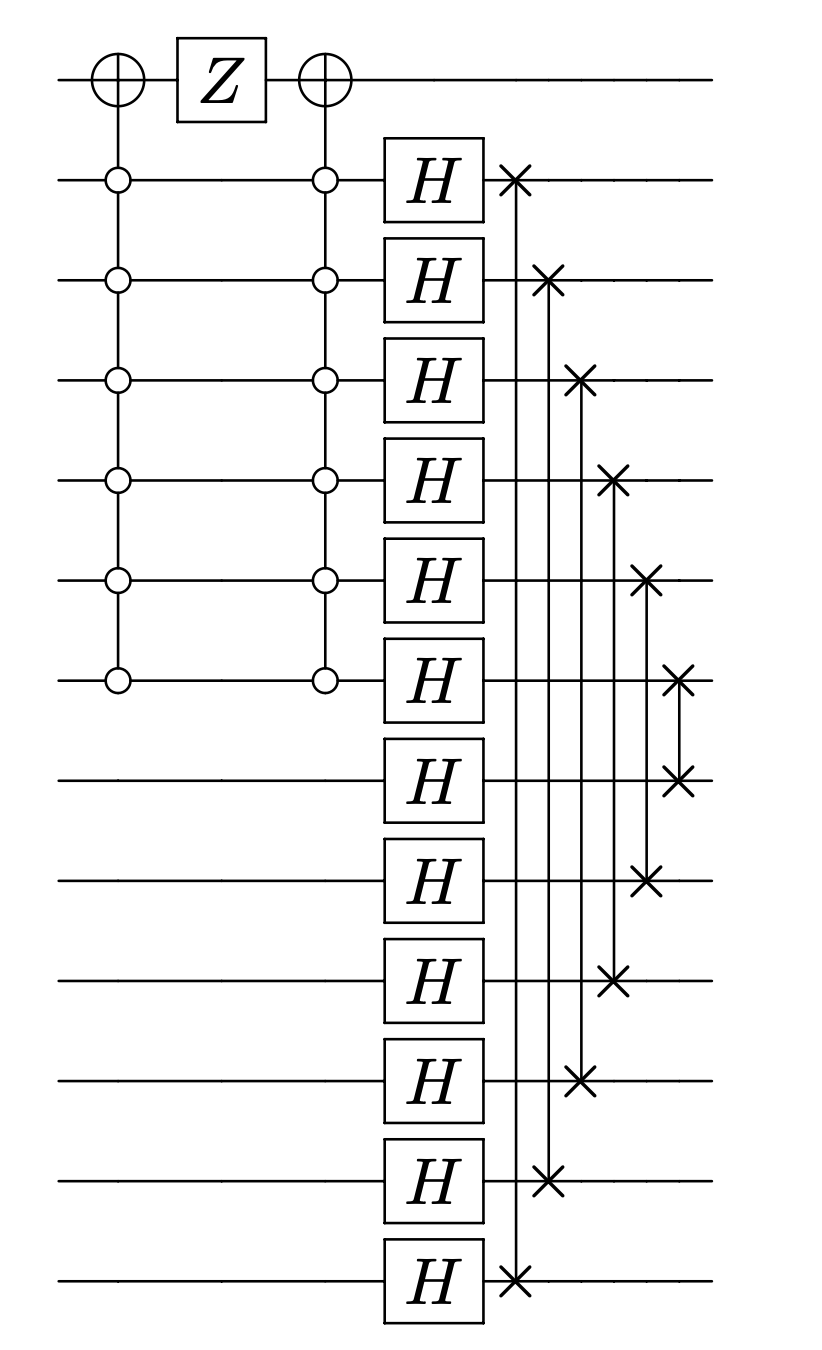



In [17]:
@qfunc
def array_swap(state: QArray, block: QArray):
    repeat(state.len, lambda i: SWAP(state[i], block[i]))


@qfunc
def non_marked_discriminant(anc: QNum, block: QNum, state: QNum):
    within_apply(lambda: control(block == 0, lambda: X(anc)), lambda: Z(anc))
    apply_to_all(H, state)
    apply_to_all(H, block)
    array_swap(state, block)


@qfunc
def main(anc: Output[QNum], block: Output[QNum], state: Output[QNum]):
    allocate(1, anc)
    n = int(np.log2(N))
    allocate(n, block)
    allocate(n, state)

    apply_to_all(H, state)  # example state for testing block encoding

    non_marked_discriminant(anc, block, state)


qmod = create_model(main)
backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
qmod = set_execution_preferences(
    qmod,
    execution_preferences=ExecutionPreferences(
        num_shots=1, backend_preferences=backend_preferences
    ),
)
qprog = synthesize(qmod)
show(qprog)
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print("The circuit width is:", circuit_width)
print("The circuit depth is:", circuit_depth)

job = execute(qprog)
results = job.result()[0].value

Quantum program link: https://platform.classiq.io/circuit/2w52znwXgZzEEo5bbgw0201hXDX?login=True&version=0.75.0
The circuit width is: 5
The circuit depth is: 26


In [18]:
reduced_state = get_projected_state_vector(results, "state", {"block": 0, "anc": 0})

print("The state vector is:")
print(reduced_state)
print("Theoretical state vector is:")
vector = [1 / np.sqrt(N) for i in range(N)]
theoretical_reduced_state = np.matmul(D_nm, vector)
print(theoretical_reduced_state)

assert np.allclose(
    reduced_state, theoretical_reduced_state, atol=1e-4
), "Implementation is incorrect"

The state vector is:
[0.5 0.5 0.5 0.5]
Theoretical state vector is:
[0.5 0.5 0.5 0.5]


#### Block encoding $D$ for the marked case:

The below circuit provides for the block-encoding of $D$ in equation $10$.

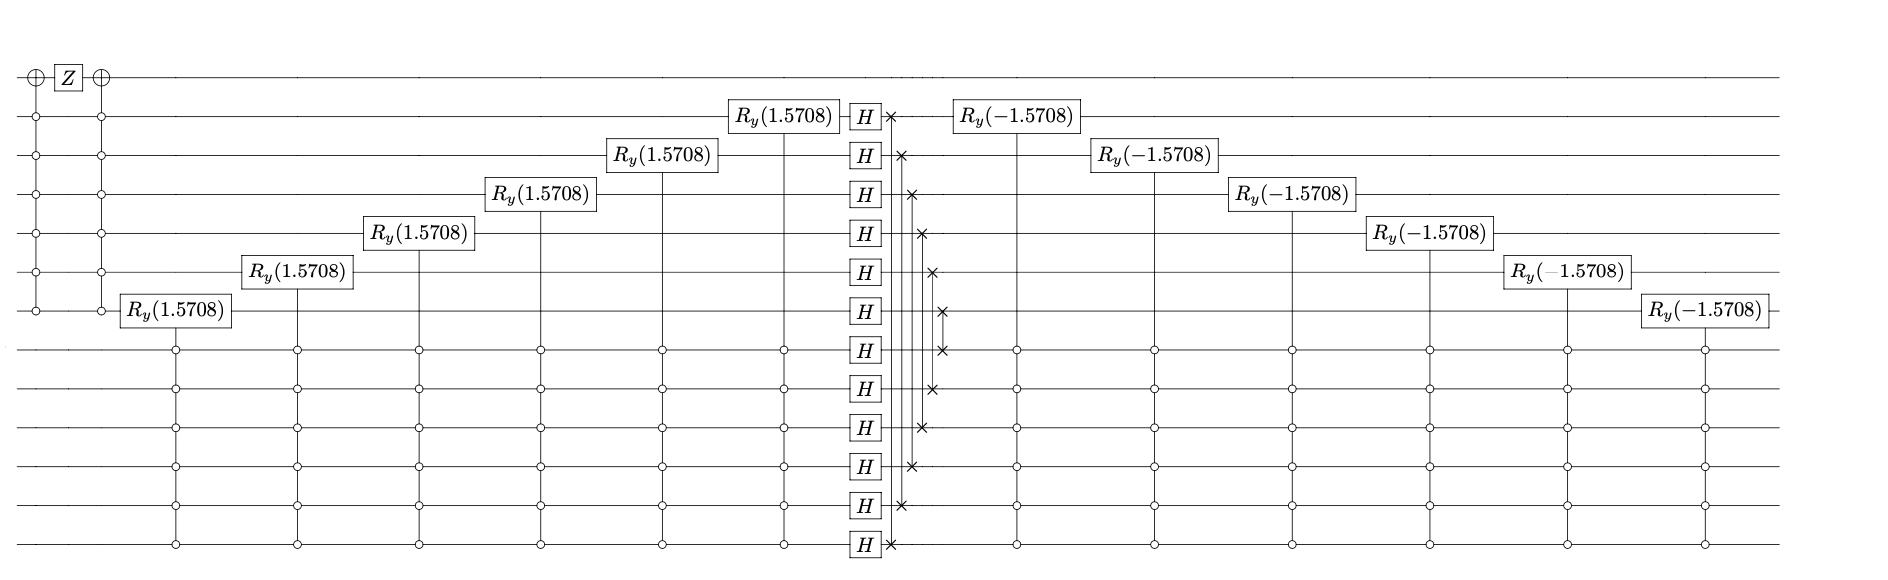

In [19]:
@qfunc
def controlled_rotations(state: QNum, block: QArray):
    repeat(block.len, lambda i: control(state == 0, lambda: RY(1.5708, block[i])))


@qfunc
def array_swap(state: QArray, block: QArray):
    repeat(state.len, lambda i: SWAP(state[i], block[i]))


@qfunc
def marked_discriminant(anc: QNum, block: QNum, state: QNum):
    within_apply(lambda: control(block == 0, lambda: X(anc)), lambda: Z(anc))
    controlled_rotations(state, block)
    apply_to_all(H, state)
    apply_to_all(H, block)
    array_swap(state, block)
    invert(lambda: controlled_rotations(state, block))


@qfunc
def main(anc: Output[QNum], block: Output[QNum], state: Output[QNum]):
    allocate(1, anc)
    n = int(np.log2(N))
    allocate(n, block)
    allocate(n, state)

    apply_to_all(H, state)  # example state for testing block encoding

    marked_discriminant(anc, block, state)


qmod = create_model(main)
backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
qmod = set_execution_preferences(
    qmod,
    execution_preferences=ExecutionPreferences(
        num_shots=1, backend_preferences=backend_preferences
    ),
)
qprog = synthesize(qmod)
show(qprog)
circuit_width = QuantumProgram.from_qprog(qprog).data.width
circuit_depth = QuantumProgram.from_qprog(qprog).transpiled_circuit.depth
print("The circuit width is:", circuit_width)
print("The circuit depth is:", circuit_depth)

job = execute(qprog)
results = job.result()[0].value

Quantum program link: https://platform.classiq.io/circuit/2w530qocfAvvNQL83MArtHvDoNY?login=True&version=0.75.0
The circuit width is: 5
The circuit depth is: 115


In [20]:
reduced_state = get_projected_state_vector(results, "state", {"block": 0, "anc": 0})

print("The state vector is:")
print(reduced_state)
print("Theoretical state vector is:")
vector = [1 / np.sqrt(N) for i in range(N)]
theoretical_reduced_state = np.matmul(D_m, vector)
print(theoretical_reduced_state)

assert np.allclose(
    reduced_state, theoretical_reduced_state, atol=1e-4
), "Implementation is incorrect"

The state vector is:
[0.49999908 0.37499954 0.37499954 0.375     ]
Theoretical state vector is:
[0.5   0.375 0.375 0.375]


Thus, the block encodings for $D$ in equation $9$ and $10$ has been implemented.
___

##### Quantum walk simulation results for $N=2^4$, for both marked and non-marked case

We start with an initial position of the walker as a uniform superposition of all vertices. 

Quantum program link: https://platform.classiq.io/circuit/2w532ANi1GmyXRZR5aUVJjRN4NP?login=True&version=0.75.0


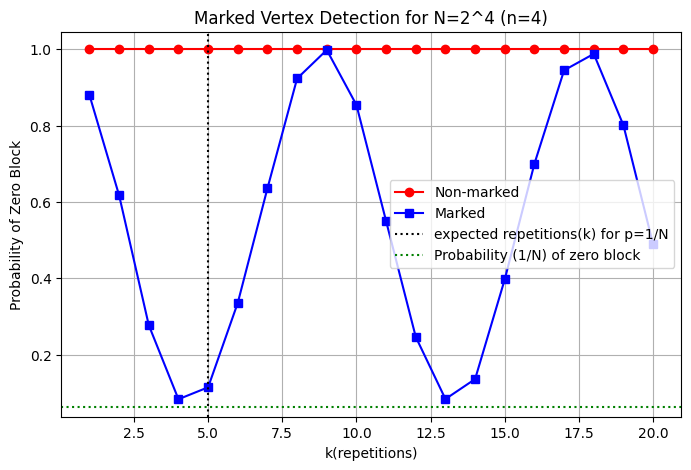

Repetitions after which probability is expected to converge to 0.0625, k = 5


In [21]:
N = 2**4
P_no_marked = construct_P_no_marked(N)
P_marked = construct_P_marked(N)
D_nm = discriminant_matrix(N, P_no_marked)
D_m = discriminant_matrix(N, P_marked)


def compute_k(N):
    """function to calculate the number of repetitions k after which the probability is expected to converge to 1/N"""
    return math.ceil((math.pi / 2) * math.sqrt(N / 2))


@qfunc
def main(k: CReal, anc: Output[QNum], block: Output[QNum], state: Output[QNum]):
    allocate(1, anc)
    n = int(np.log2(N))
    allocate(n, block)
    allocate(n, state)

    apply_to_all(H, state)  # initial position of the walker

    power(k, lambda: non_marked_discriminant(anc, block, state))


qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)
es = ExecutionSession(qprog)

repetitions = [i for i in range(1, 21)]
obtained_prob_zero_block_nonmarkedN2 = []
for k in repetitions:
    sample_result = es.sample({"k": k})
    # Collecting relevant states
    filtered_state = []
    for key, value in sample_result.parsed_states.items():
        if value["block"] == 0.0:
            filtered_state.append(key)

    # Calculate the obtained probability
    total_sum = sum(
        sample_result.counts[key]
        for key in filtered_state
        if key in sample_result.counts
    )
    obtained_prob = total_sum / sample_result.num_shots
    obtained_prob_zero_block_nonmarkedN2.append(obtained_prob)


@qfunc
def main(k: CReal, anc: Output[QNum], block: Output[QNum], state: Output[QNum]):
    allocate(1, anc)
    n = int(np.log2(N))
    allocate(n, block)
    allocate(n, state)

    apply_to_all(H, state)  # initial position of the walker

    power(k, lambda: marked_discriminant(anc, block, state))


qmod = create_model(main)
qprog = synthesize(qmod)
es = ExecutionSession(qprog)

obtained_prob_zero_block_markedN2 = []
for k in repetitions:
    sample_result = es.sample({"k": k})

    # Collecting relevant states
    filtered_state = []
    for key, value in sample_result.parsed_states.items():
        if value["block"] == 0.0:
            filtered_state.append(key)

    # Calculate the obtained probability
    total_sum = sum(
        sample_result.counts[key]
        for key in filtered_state
        if key in sample_result.counts
    )
    obtained_prob = total_sum / sample_result.num_shots
    obtained_prob_zero_block_markedN2.append(obtained_prob)

# Plot both datasets
plt.figure(figsize=(8, 5))
plt.plot(
    repetitions,
    obtained_prob_zero_block_nonmarkedN2,
    marker="o",
    label="Non-marked",
    color="red",
)
plt.plot(
    repetitions,
    obtained_prob_zero_block_markedN2,
    marker="s",
    label="Marked",
    color="blue",
)

# Add vertical and horizontal dotted lines
plt.axvline(
    x=compute_k(N),
    linestyle="dotted",
    color="black",
    label="expected repetitions(k) for p=1/N",
)
plt.axhline(
    y=1 / N, linestyle="dotted", color="green", label="Probability (1/N) of zero block"
)

# Labels and title
plt.xlabel("k(repetitions)")
plt.ylabel("Probability of Zero Block")
plt.title("Marked Vertex Detection for N=2^4 (n=4)")
plt.legend()
plt.grid()
plt.show()

k = compute_k(N)
print(f"Repetitions after which probability is expected to converge to {1/N}, k = {k}")

Thus, as we see from simulations, the result of $p(|0^n\rangle)$ is always $1$ irrespective of the repetitions $k$ of the quantum walk, in the case of non-marked vertices in a graph. In the presence of marked vertex, the behaviour $p(|0^n\rangle)$ is roughly oscillatory. As per theory, we expect $p(|0^n\rangle)$ to be minimal (close to $\frac{1}{N}$, for large $N$) after around $5$ steps of the quantum walk. Thus, simulations almost agree with theory. Increasing the number of shots and the value of $N$ would lead to further convergence of theory with simulations.

____
### References

- Camps, D., Lin, L., Van Beeumen, R., & Yang, C. (2023). *Explicit Quantum Circuits for Block Encodings of Certain Sparse Matrices*. arXiv: [2203.10236](https://arxiv.org/abs/2203.10236).
- Loke, T., & Wang, J. B. (2017). *Efficient quantum circuits for Szegedy quantum walks*. Annals of Physics, **382**, 64–84. [https://doi.org/10.1016/j.aop.2017.04.006](https://doi.org/10.1016/j.aop.2017.04.006).
____
